In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from einops import rearrange
from pathlib import Path
import copy

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from case_studies.dc2_mdt.utils.encoder import DiffusionEncoder

In [3]:
model_tag_name = "mdt"
model_name = "exp_04-12-1"
model_check_point_name = "encoder_152.ckpt"
model_path = f"../../../bliss_output/DC2_mdt_exp/{model_name}/checkpoints/{model_check_point_name}"
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:3")
with initialize(config_path="./mdt_config", version_base=None):
    cfg = compose("mdt_train_config")
infer_batch_size = 800

In [4]:
seed = cfg.train.seed
print(f"using seed {seed}")
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


using seed 7272


7272

In [5]:
dc2: DC2DataModule = instantiate(cfg.surveys.dc2)
dc2.batch_size = infer_batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

diffusion_encoder: DiffusionEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
diffusion_encoder.load_state_dict(pretrained_weights)
diffusion_encoder.eval();

In [6]:
diffusion_encoder.reconfig_sampling(new_sampling_time_steps=50, new_ddim_eta=0.0)

In [7]:
max_fluxes = diffusion_encoder.max_fluxes
print(f"max_fluxes: {max_fluxes}")

max_fluxes: 22025.0


In [8]:
mag_bin_boundaries = {
    "u": torch.tensor([21.0428, 23.5071, 25.9714, 28.4357, 30.9001]),
    "g": torch.tensor([21.0428, 22.8431, 24.6434, 26.4437, 28.2440]),
    "r": torch.tensor([21.0428, 22.2571, 23.4714, 24.6857, 25.9001]),
    "i": torch.tensor([21.0428, 22.3778, 23.7127, 25.0477, 26.3827]),
    "z": torch.tensor([21.0428, 22.3861, 23.7295, 25.0728, 26.4162]),
    "y": torch.tensor([21.0428, 22.3502, 23.6575, 24.9649, 26.2723]),
}

In [9]:
test_band_index = 3
test_true_mag_bin_index = 1
test_pred_dev_mag_bin_index = 2
test_sample_iters = 500

In [10]:
one_batch = next(iter(dc2_val_dataloader))
one_batch = move_data_to_device(one_batch, device=device)

In [11]:
target_tile_cat = TileCatalog(one_batch["tile_catalog"])
target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2)
target_n_sources = target_tile_cat["n_sources"]
target_locs = target_tile_cat["locs"]
target_fluxes = target_tile_cat["fluxes"].clamp(max=max_fluxes)
target_images = one_batch["images"]

with torch.inference_mode():
    sample_tile_cat = diffusion_encoder.sample(one_batch)
pred_n_sources = sample_tile_cat["n_sources"]
pred_locs = sample_tile_cat["locs"]
pred_fluxes = sample_tile_cat["fluxes"]  # (b, h, w, 1, 6)

ns_mask = (target_n_sources > 0) & (pred_n_sources > 0)
true_fluxes_m = convert_flux_to_magnitude(target_fluxes[ns_mask][..., 0, test_band_index].clamp(min=1.0), zero_point=3631e9)
pred_fluxes_m = convert_flux_to_magnitude(pred_fluxes[ns_mask][..., 0, test_band_index].clamp(min=1.0), zero_point=3631e9)
true_m_bin_indexes = torch.bucketize(true_fluxes_m, mag_bin_boundaries["ugrizy"[test_band_index]].to(device=device))
pred_m_bin_indexes = torch.bucketize(pred_fluxes_m, mag_bin_boundaries["ugrizy"[test_band_index]].to(device=device))
dev_mask = (true_m_bin_indexes == test_true_mag_bin_index) & (pred_m_bin_indexes == test_pred_dev_mag_bin_index)

dense_dev_mask = torch.zeros_like(target_n_sources, dtype=torch.bool)
dense_dev_mask.masked_scatter_(ns_mask, dev_mask);  # (b, h, w)
print(f"{dense_dev_mask.sum().item()} sources satisfy the condition")

37 sources satisfy the condition


In [12]:
batch_wise_dense_dev_mask = (dense_dev_mask.sum(dim=(-1, -2)) == 1)
print(f"keep {batch_wise_dense_dev_mask.sum().item()} images")
sub_one_batch = copy.copy(one_batch)
sub_one_batch["images"] = one_batch["images"][batch_wise_dense_dev_mask]
target_n_sources = target_n_sources[batch_wise_dense_dev_mask]
target_locs = target_locs[batch_wise_dense_dev_mask]
target_fluxes = target_fluxes[batch_wise_dense_dev_mask]
target_images = target_images[batch_wise_dense_dev_mask]
pred_n_sources = pred_n_sources[batch_wise_dense_dev_mask]
pred_locs = pred_locs[batch_wise_dense_dev_mask]
pred_fluxes = pred_fluxes[batch_wise_dense_dev_mask]
dense_dev_mask = dense_dev_mask[batch_wise_dense_dev_mask]

keep 33 images


In [13]:
dense_dev_mask.shape

torch.Size([33, 20, 20])

In [14]:
sample_n_sources = []
sample_locs = []
sample_fluxes = []
diffusion_encoder.my_net.fast_inference_mode = True
for _ in tqdm.tqdm(list(range(test_sample_iters))):
    with torch.inference_mode():
        sample_tile_cat = diffusion_encoder.sample(sub_one_batch)
    sample_n_sources.append(sample_tile_cat["n_sources"].cpu())
    sample_locs.append(sample_tile_cat["locs"].cpu())
    sample_fluxes.append(sample_tile_cat["fluxes"].cpu())
diffusion_encoder.my_net.fast_inference_mode = False
sample_n_sources = torch.stack(sample_n_sources, dim=0)
sample_locs = torch.stack(sample_locs, dim=0)
sample_fluxes = torch.stack(sample_fluxes, dim=0)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [10:04<00:00,  1.21s/it]


In [15]:
sample_n_sources.shape, sample_locs.shape, sample_fluxes.shape

(torch.Size([500, 33, 20, 20]),
 torch.Size([500, 33, 20, 20, 1, 2]),
 torch.Size([500, 33, 20, 20, 1, 6]))

In [16]:
def get_image_for_plot(image):
    return ((image + 0.5).norm(dim=0, p=1) / 6).clamp(min=0, max=1) * 255

/tmp/ipykernel_1487188/3712767536.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 2, figsize=(16, 16))


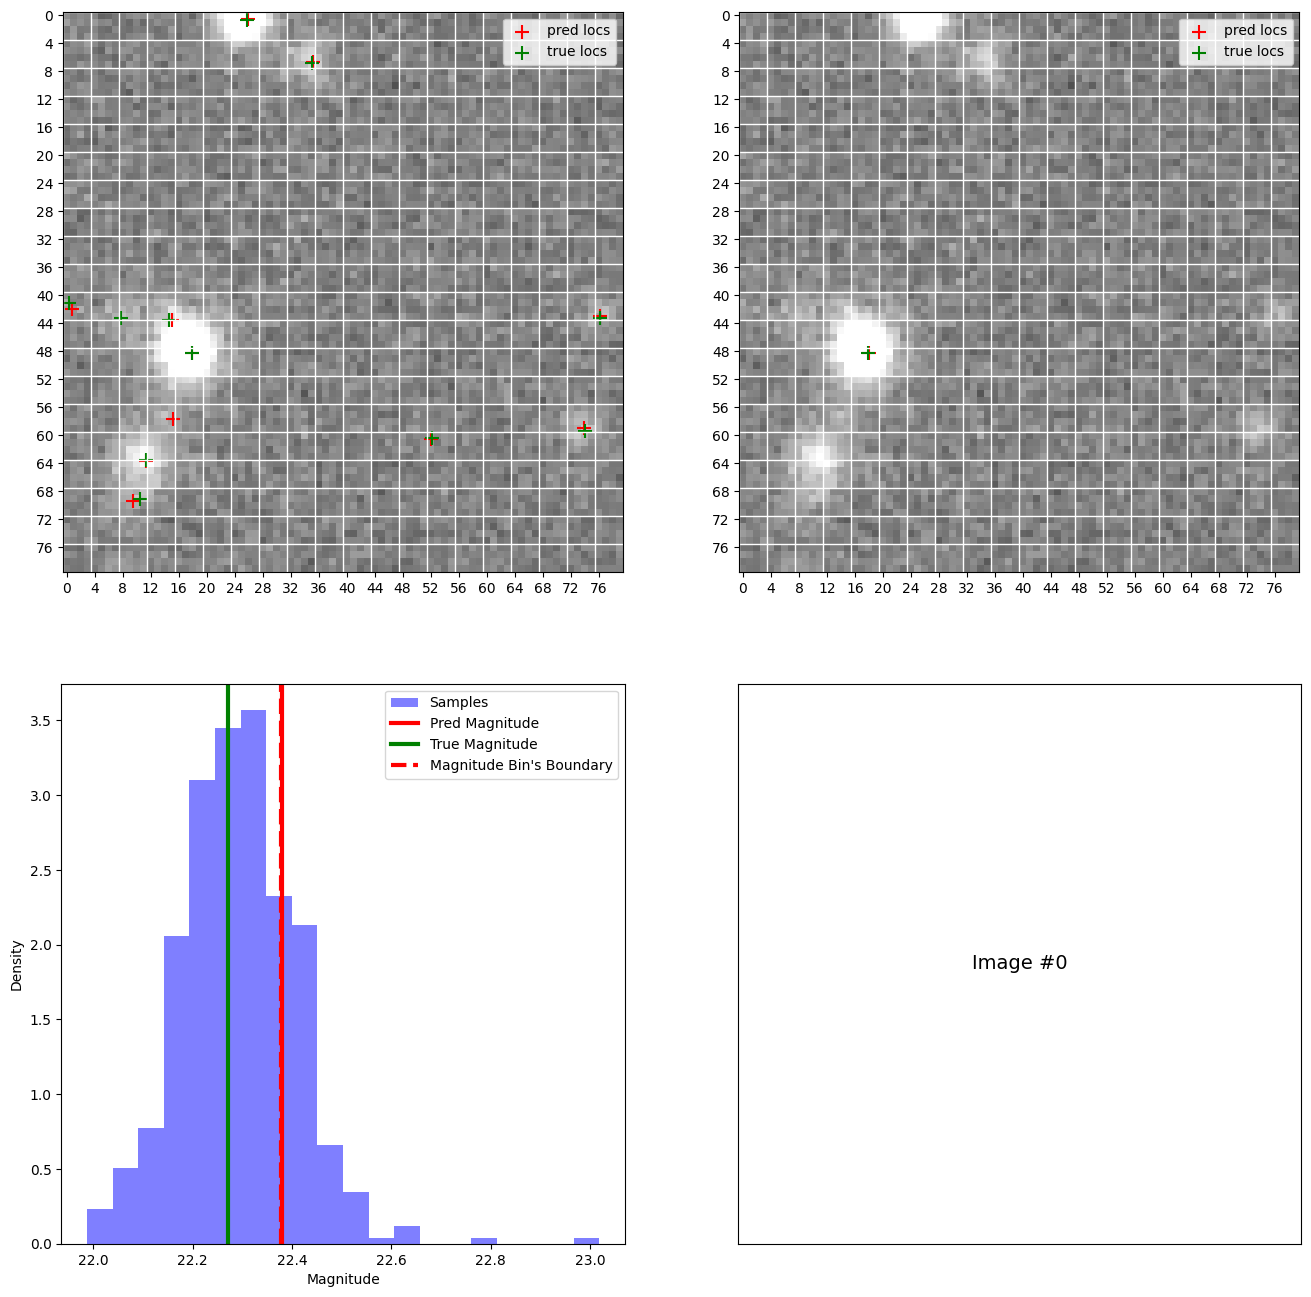

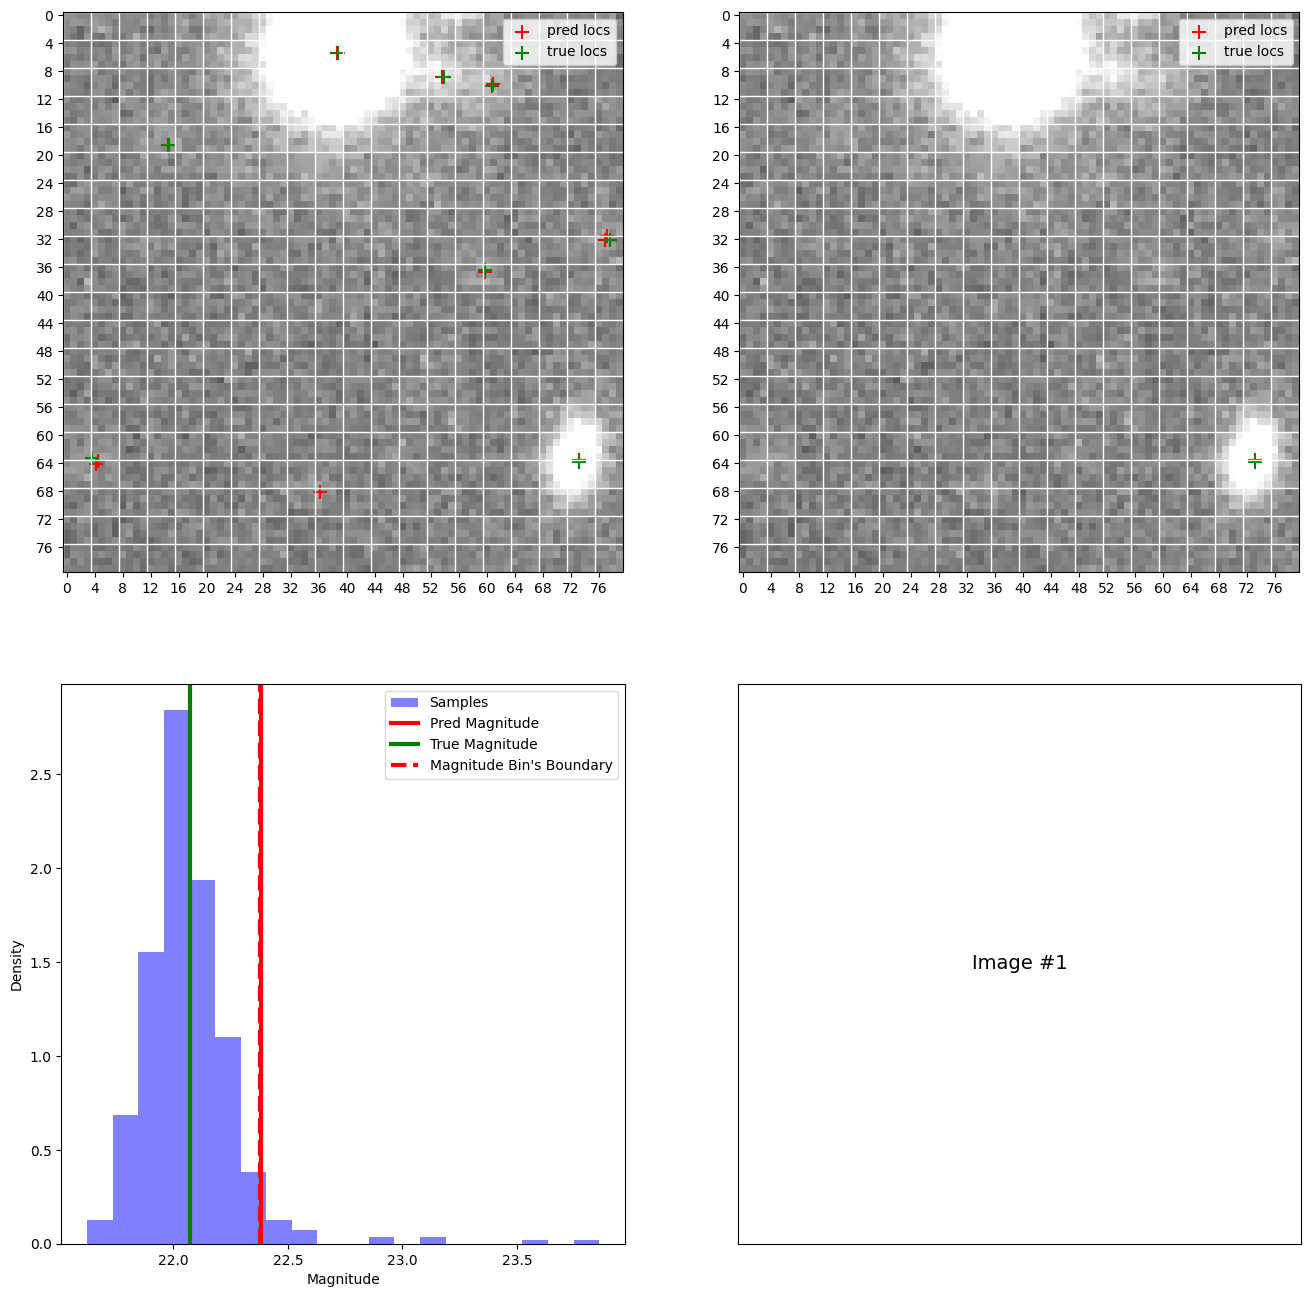

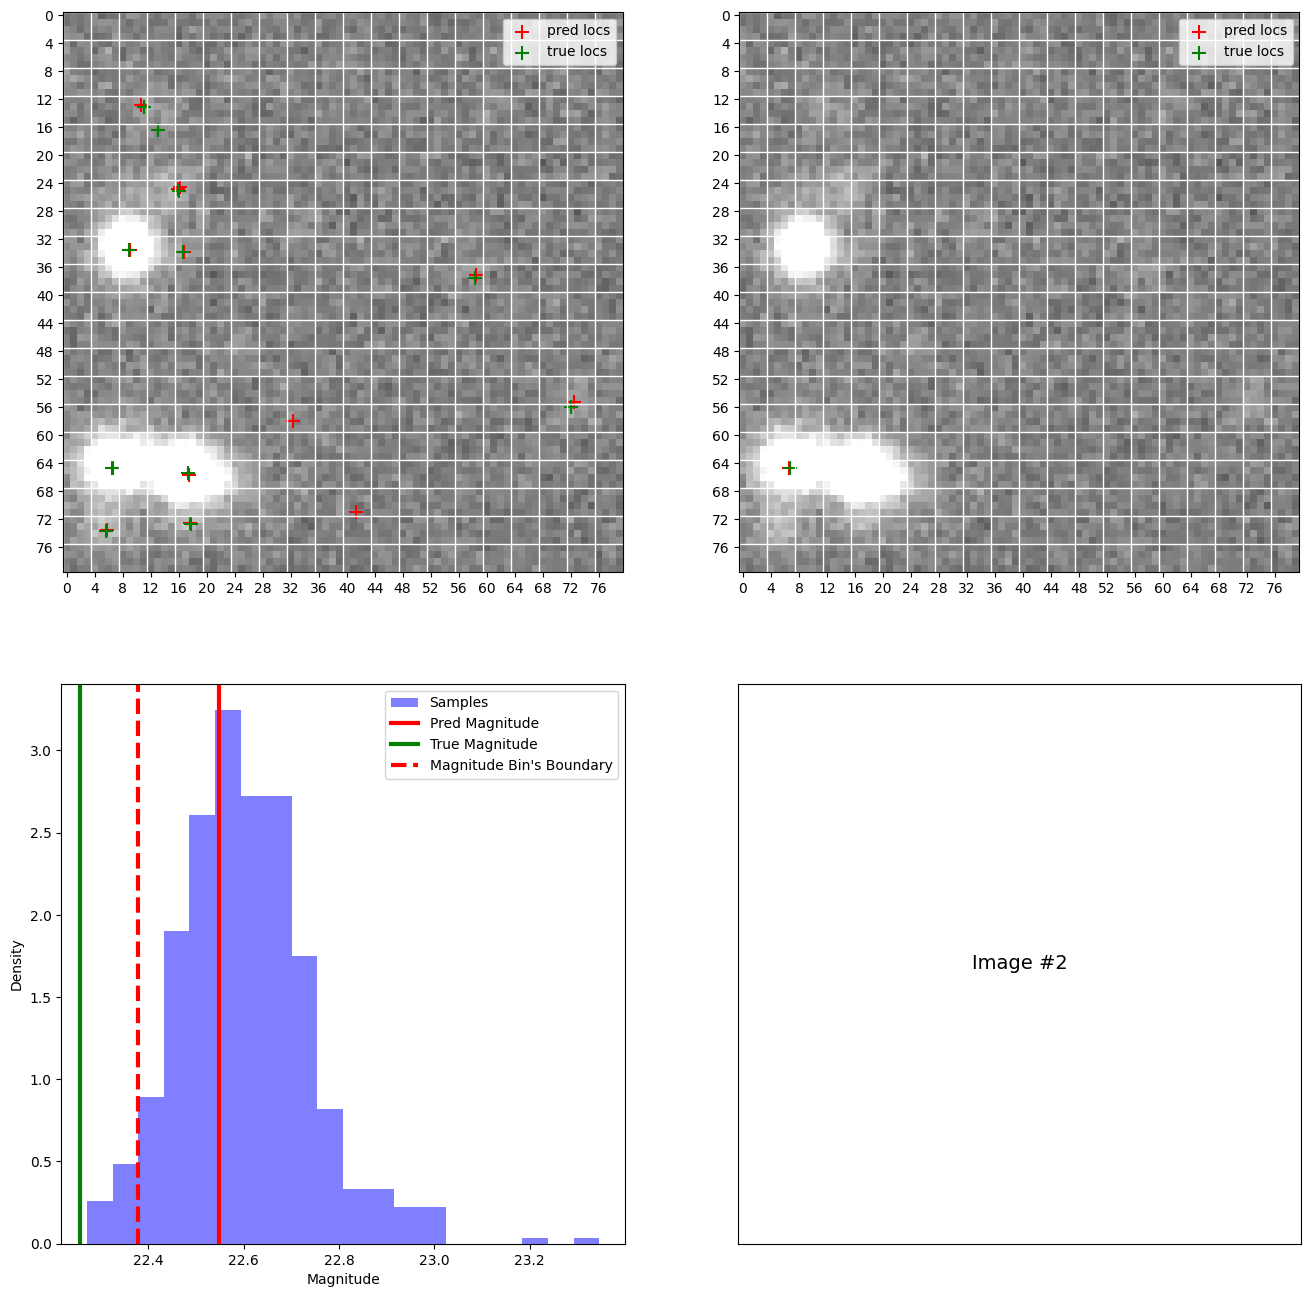

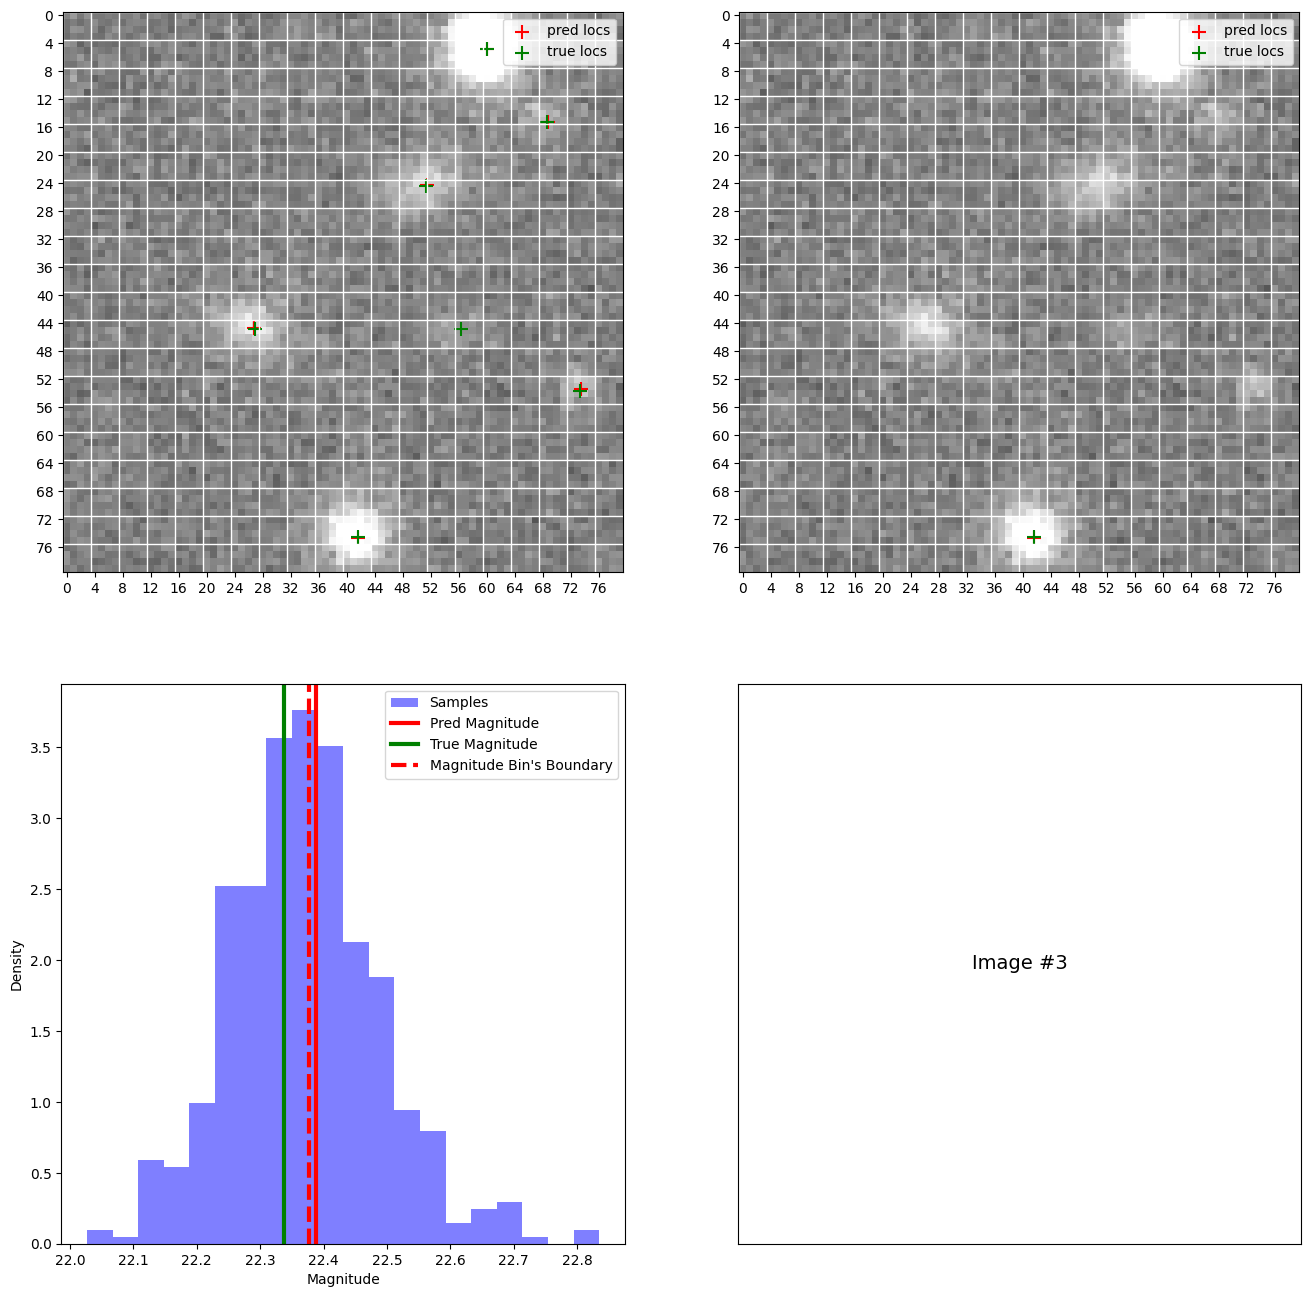

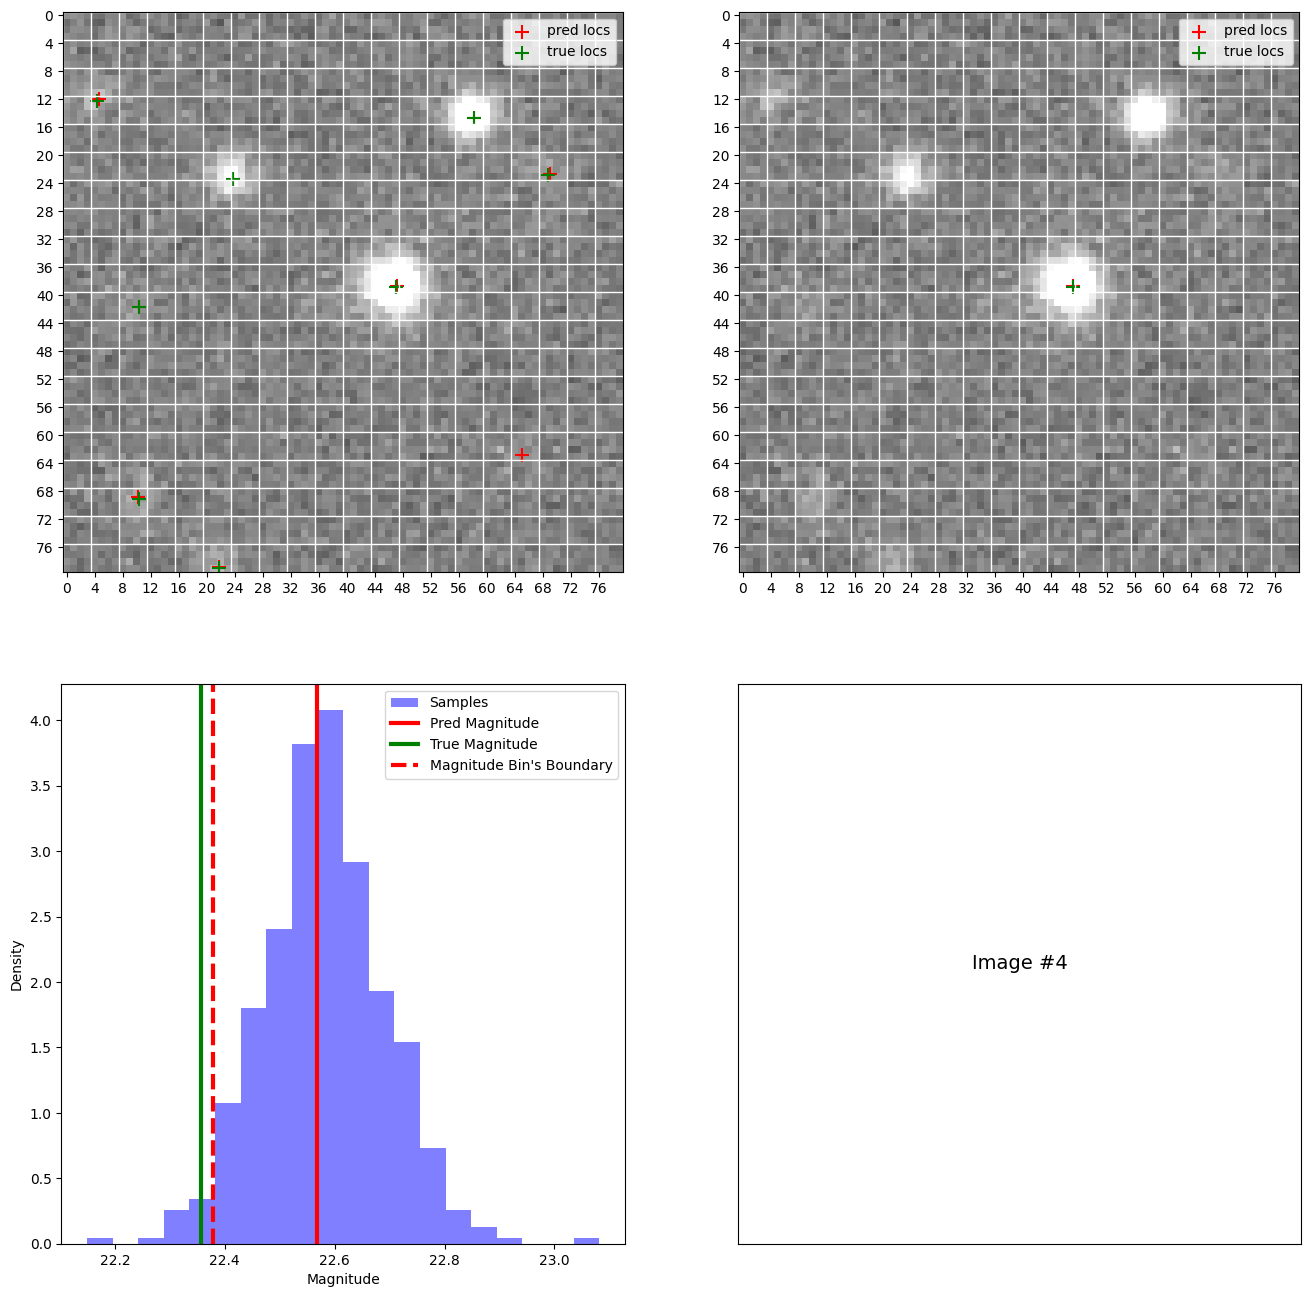

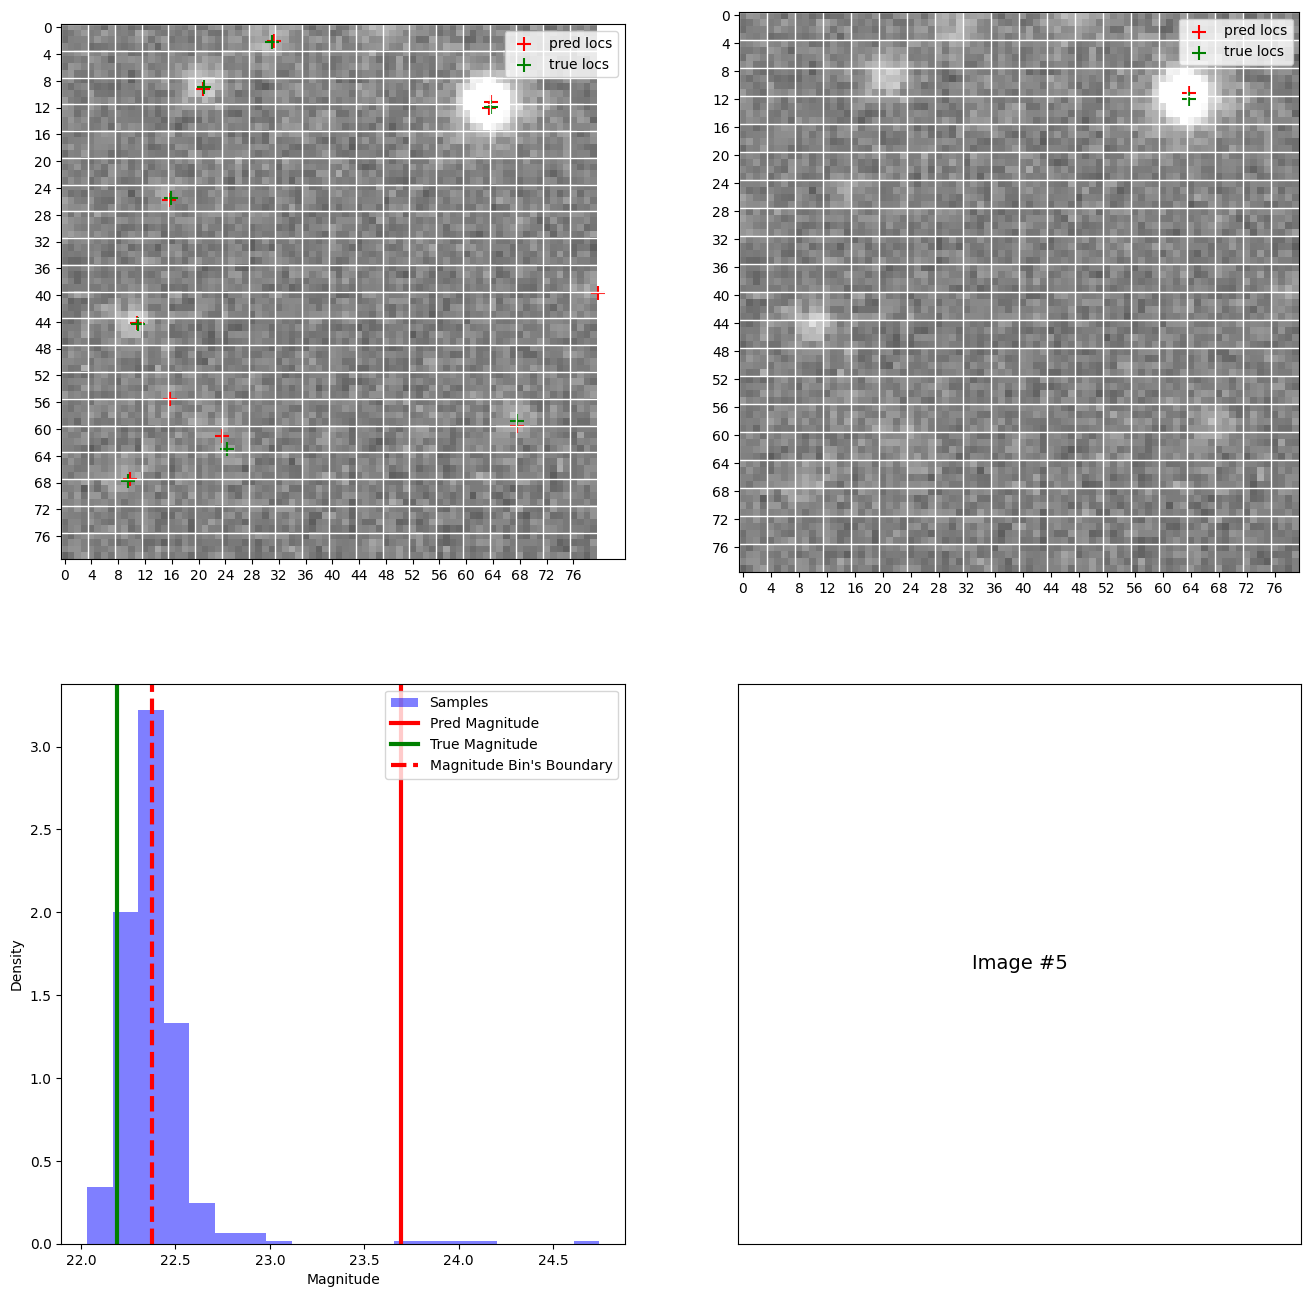

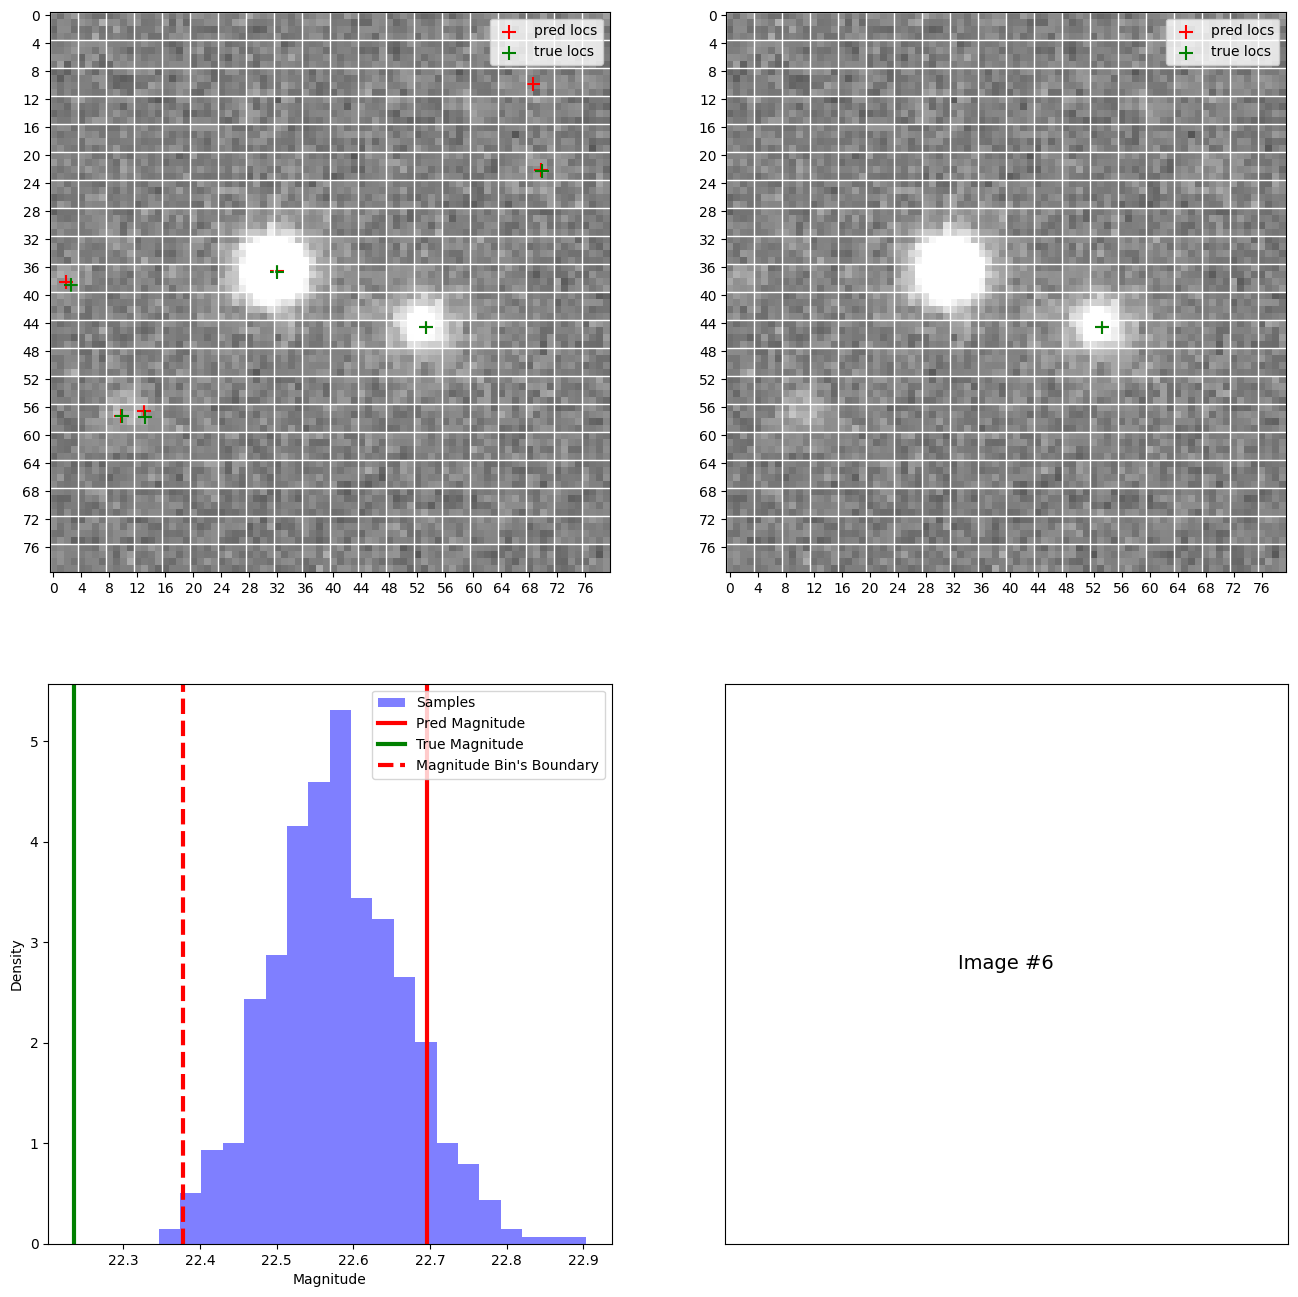

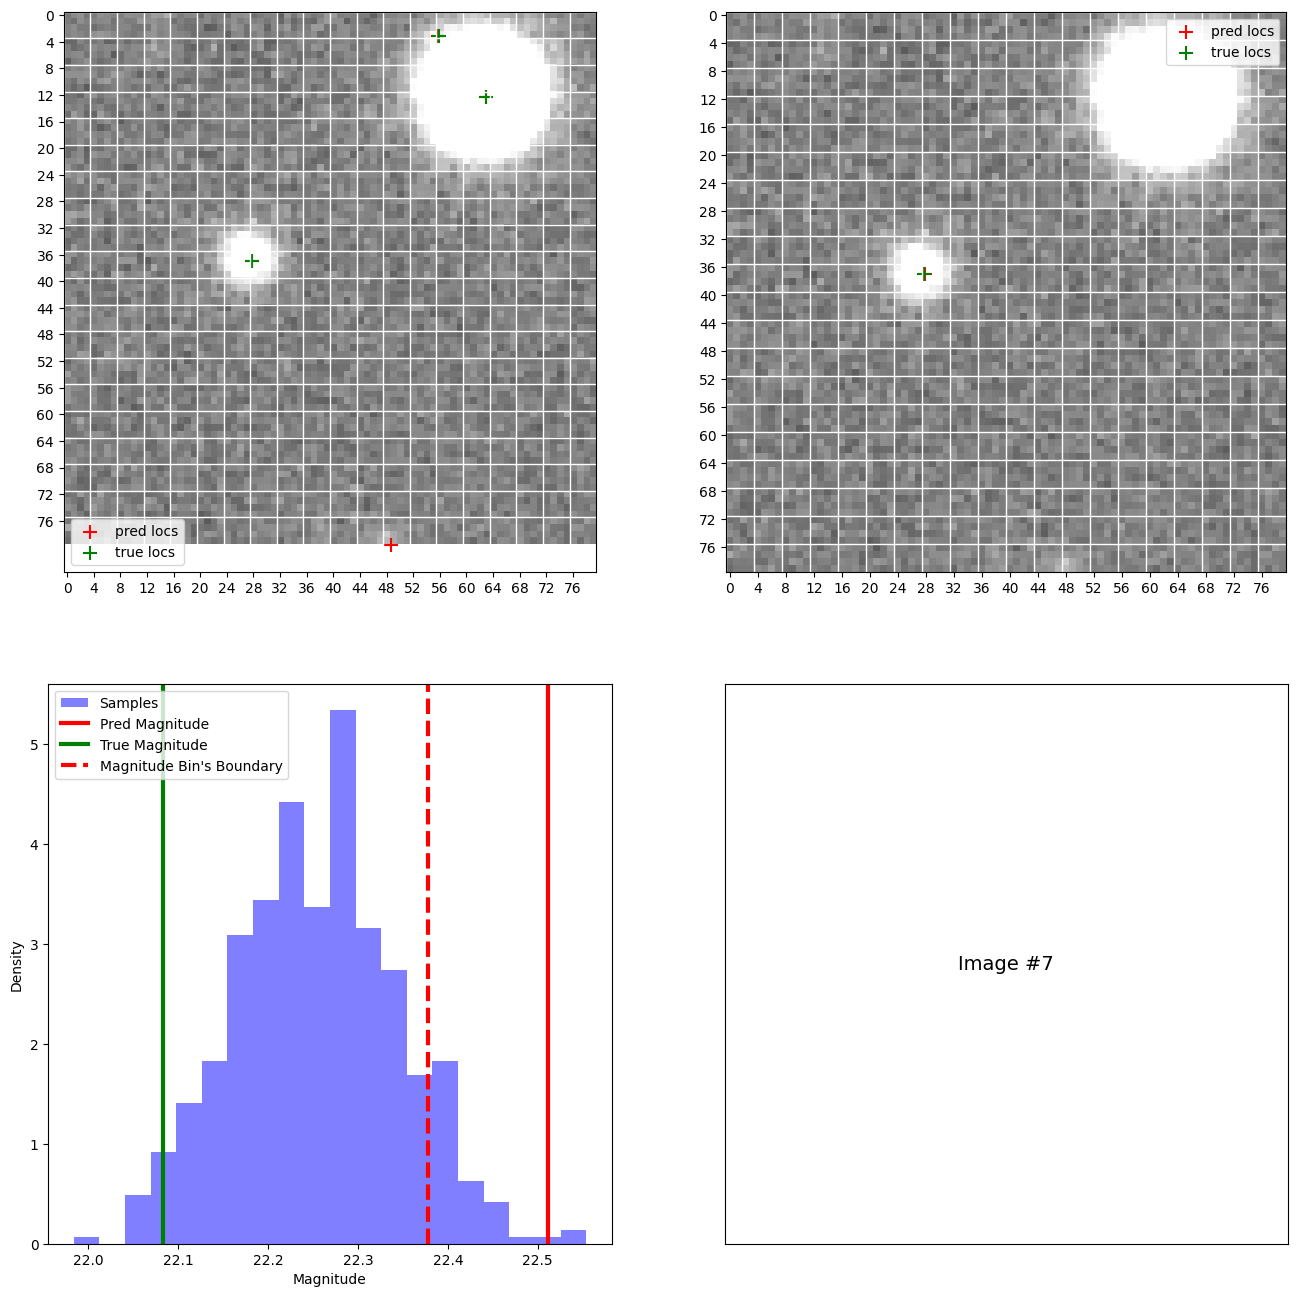

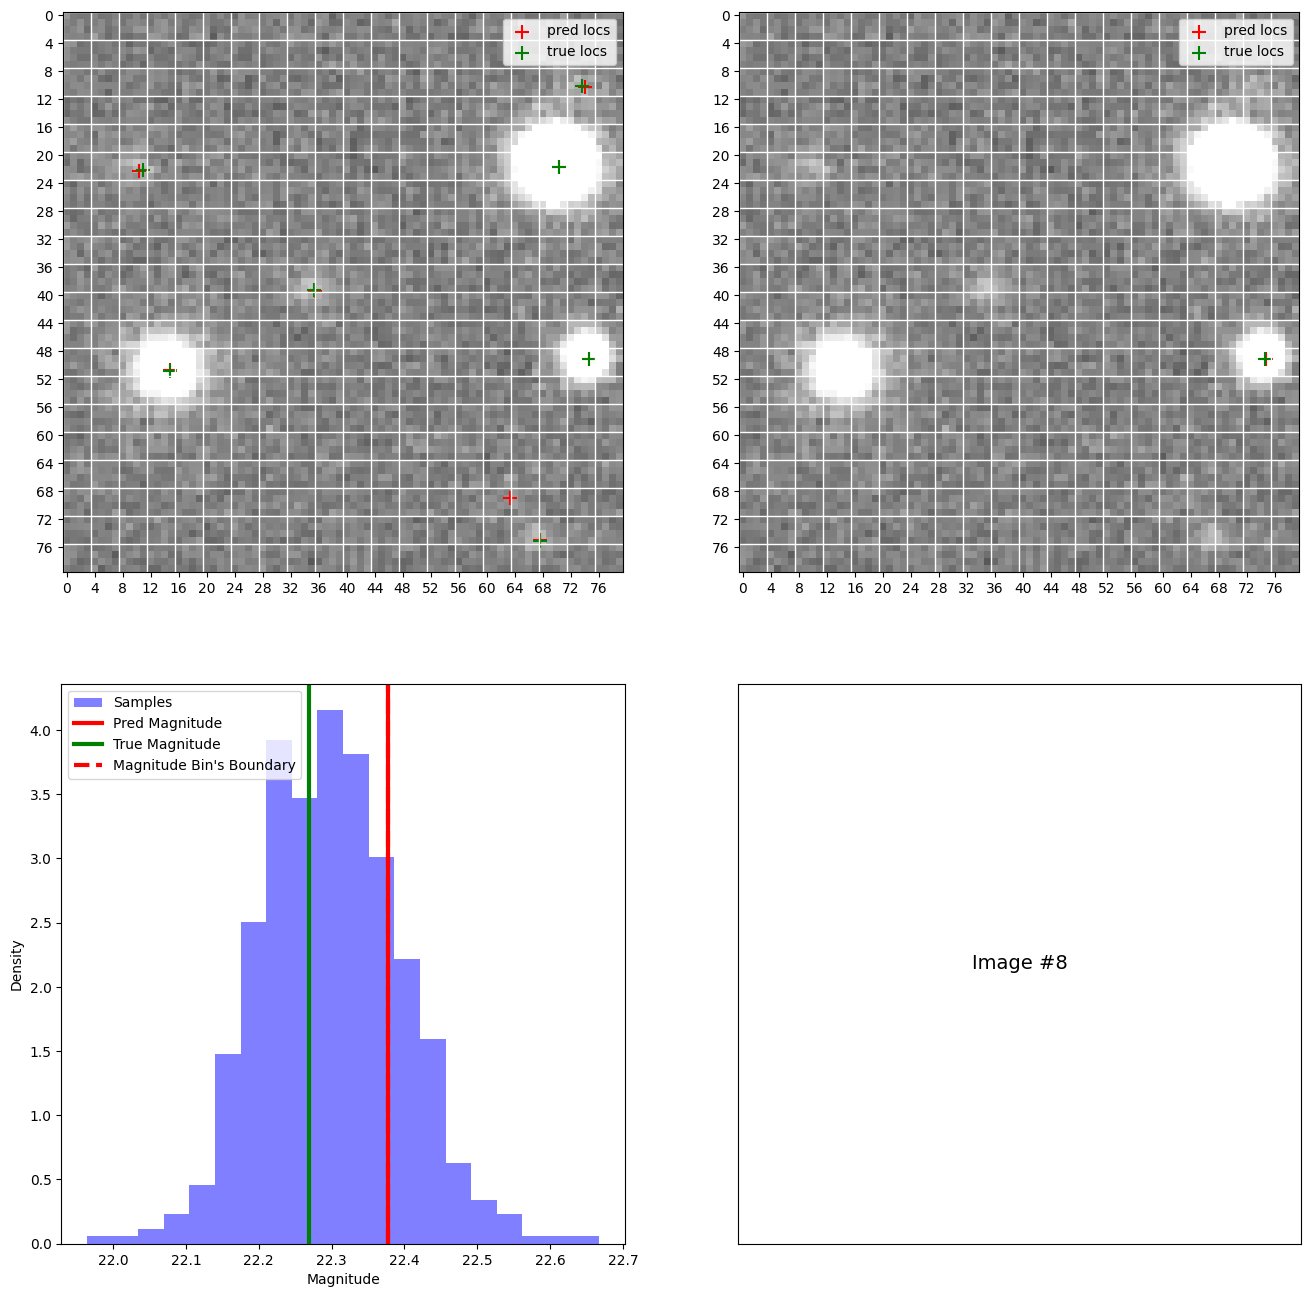

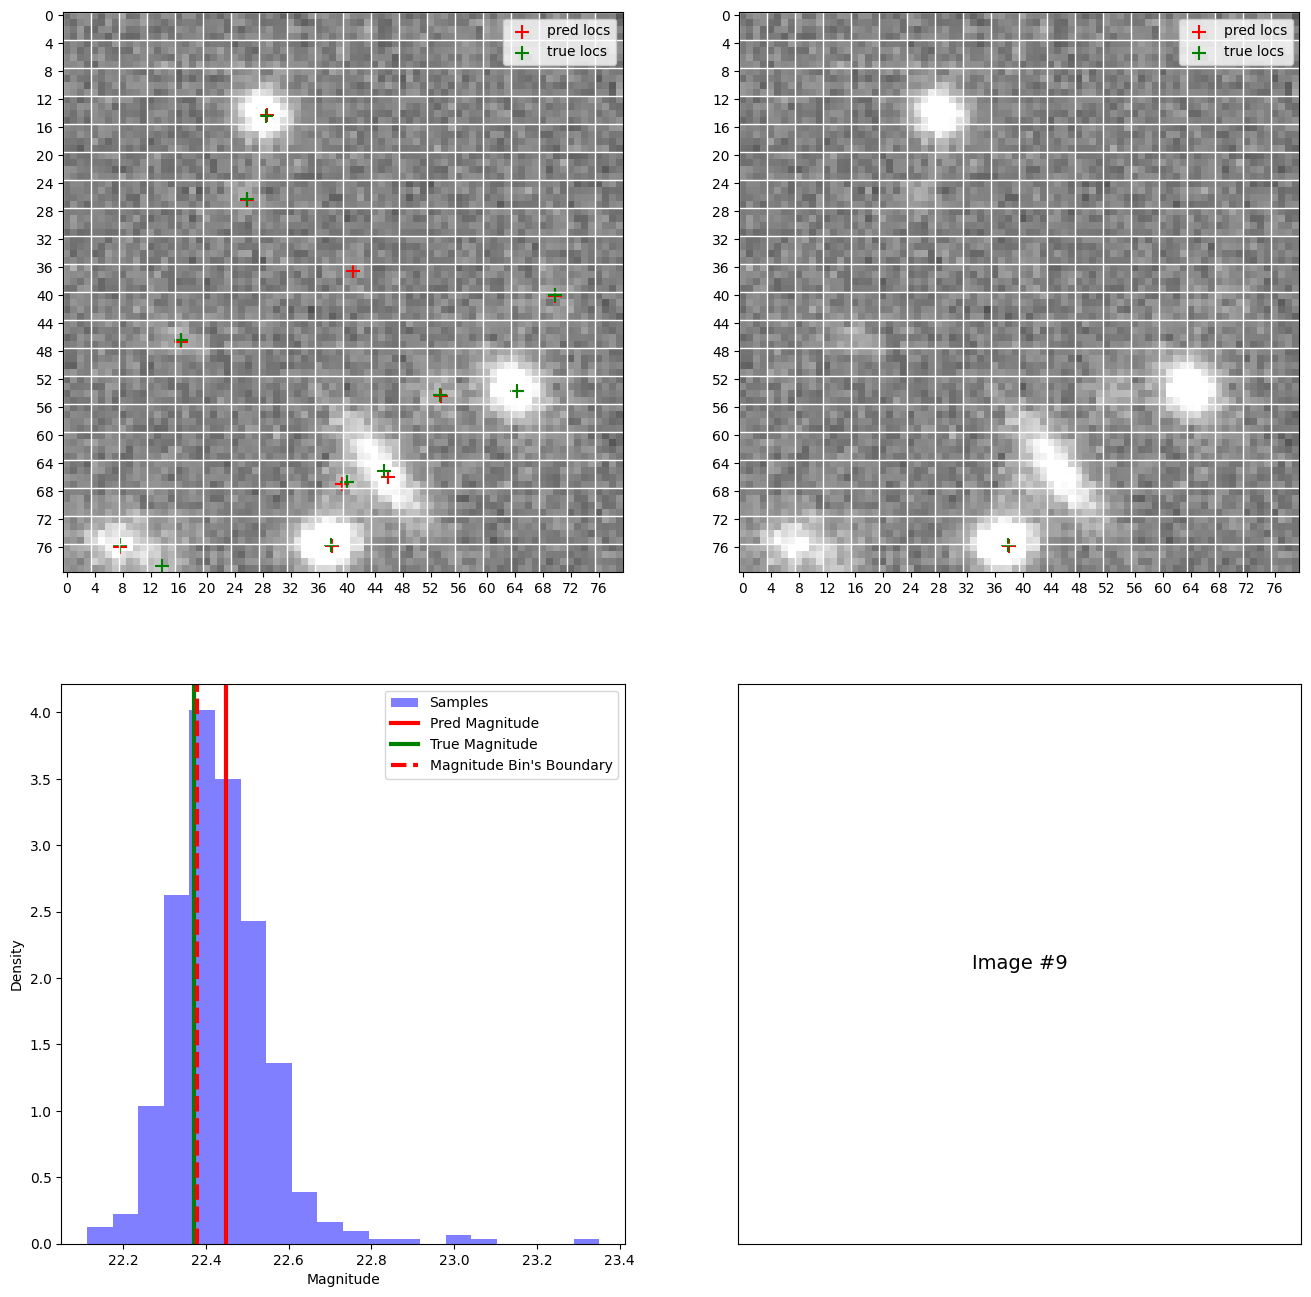

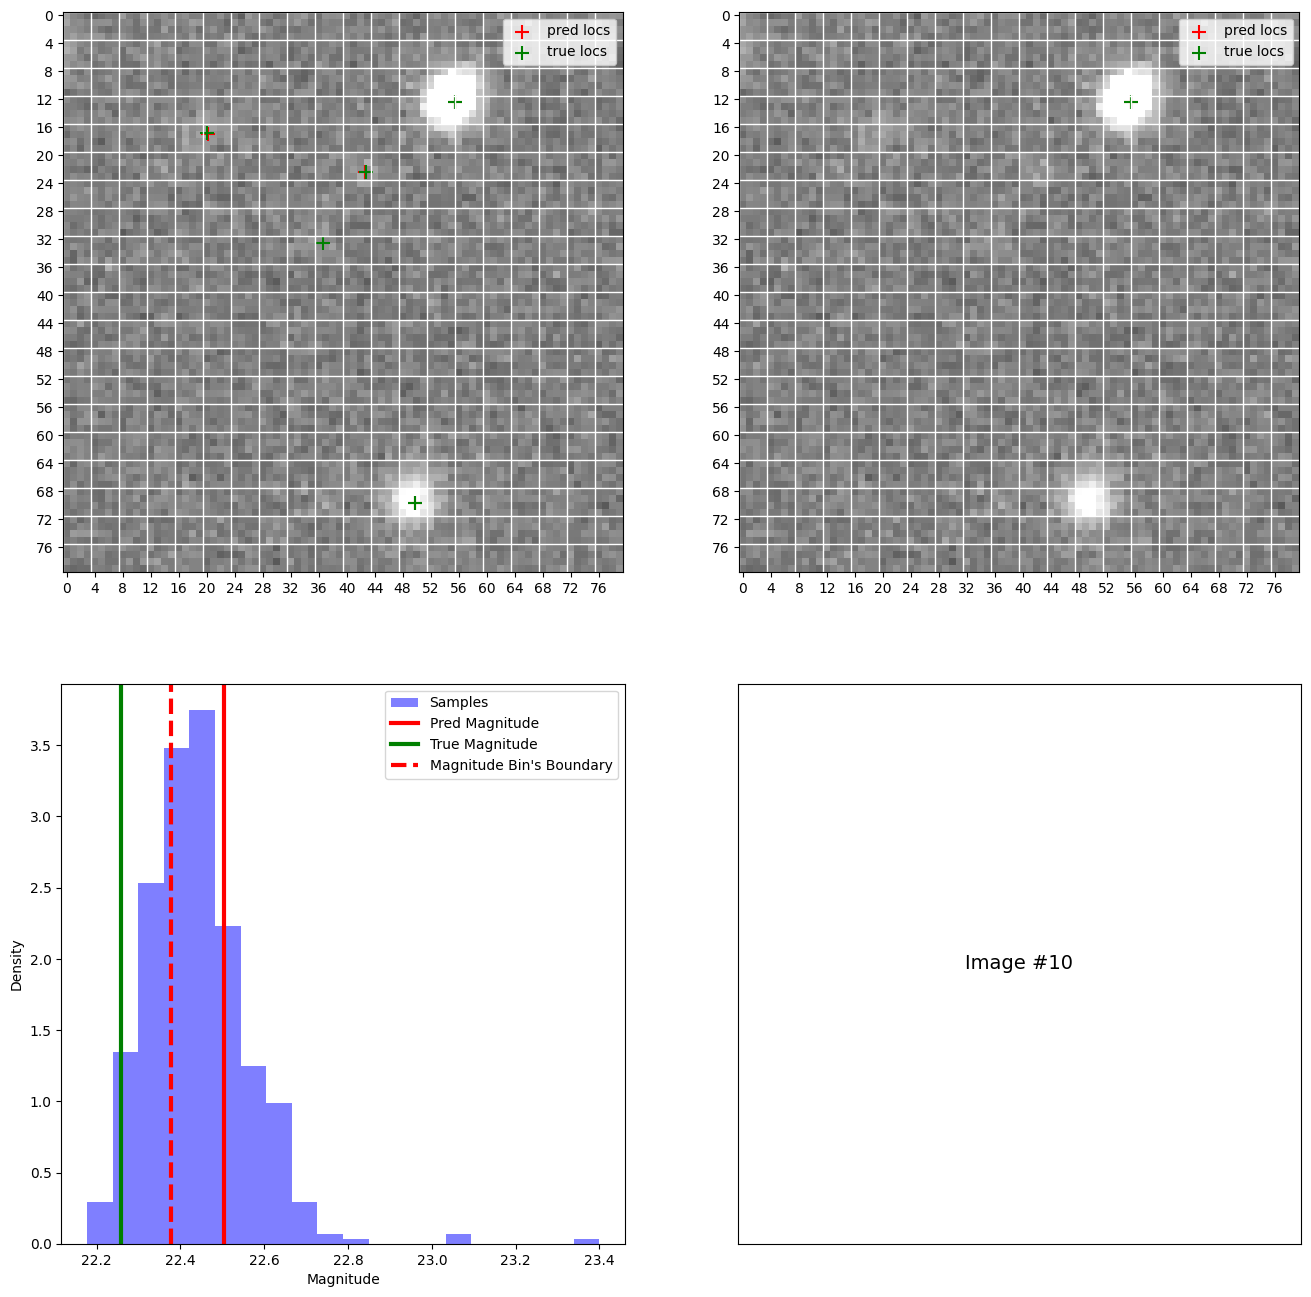

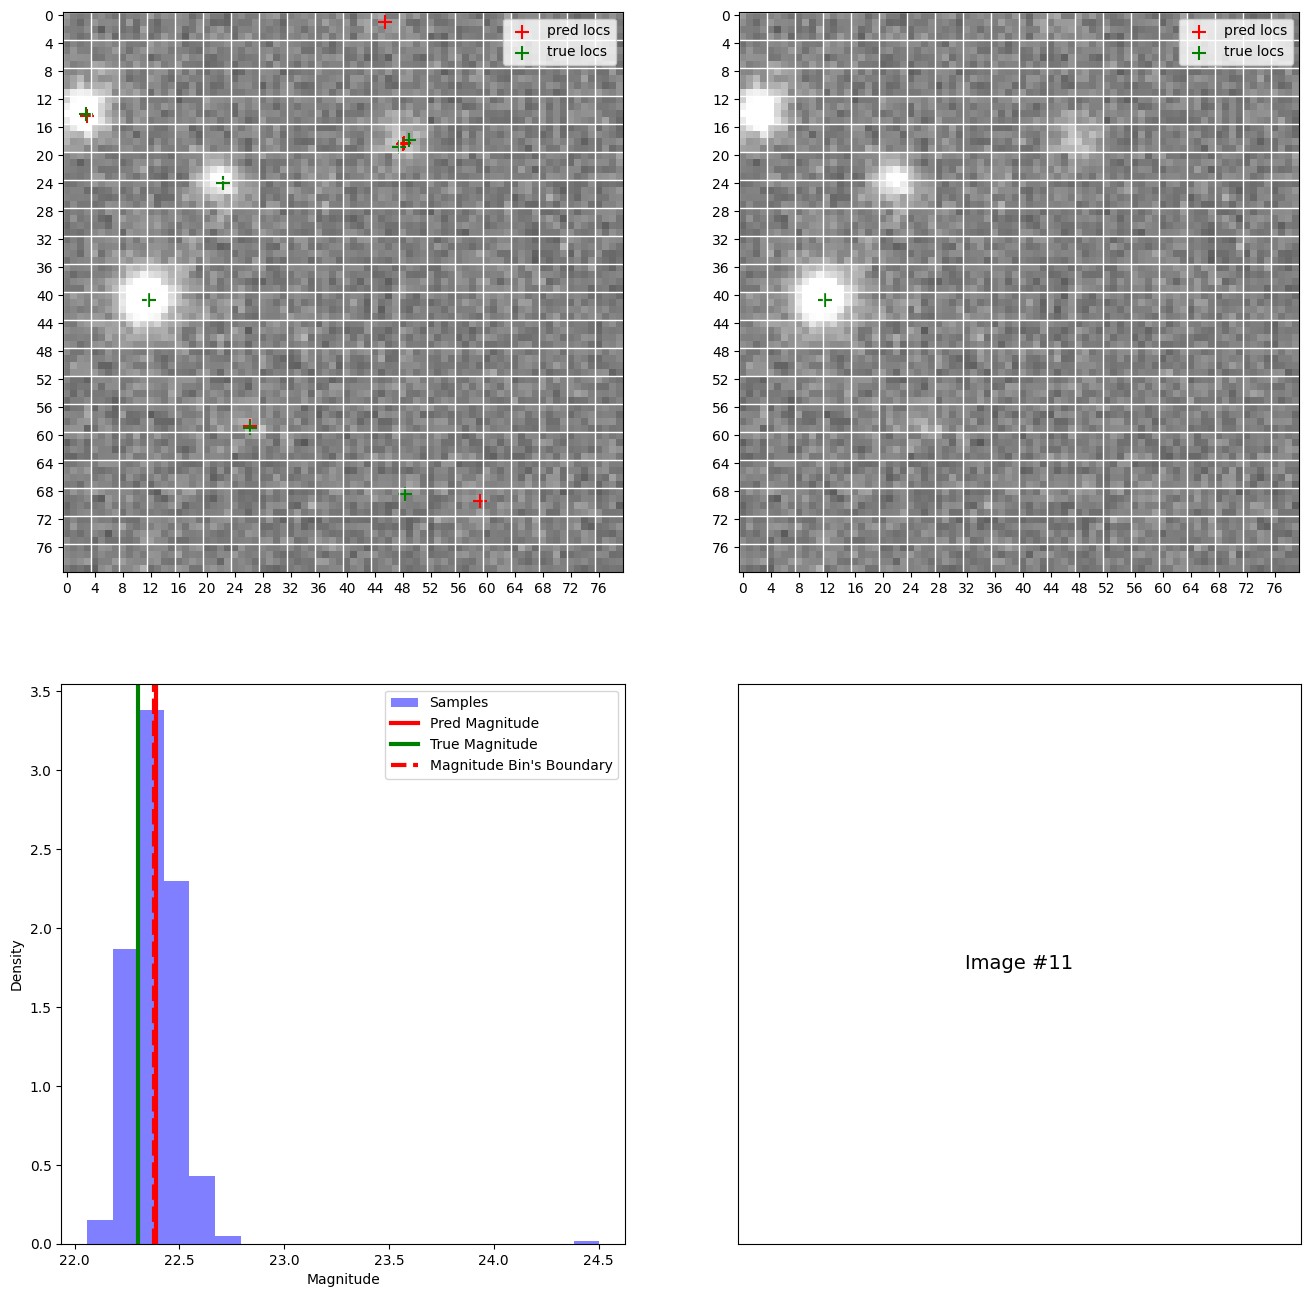

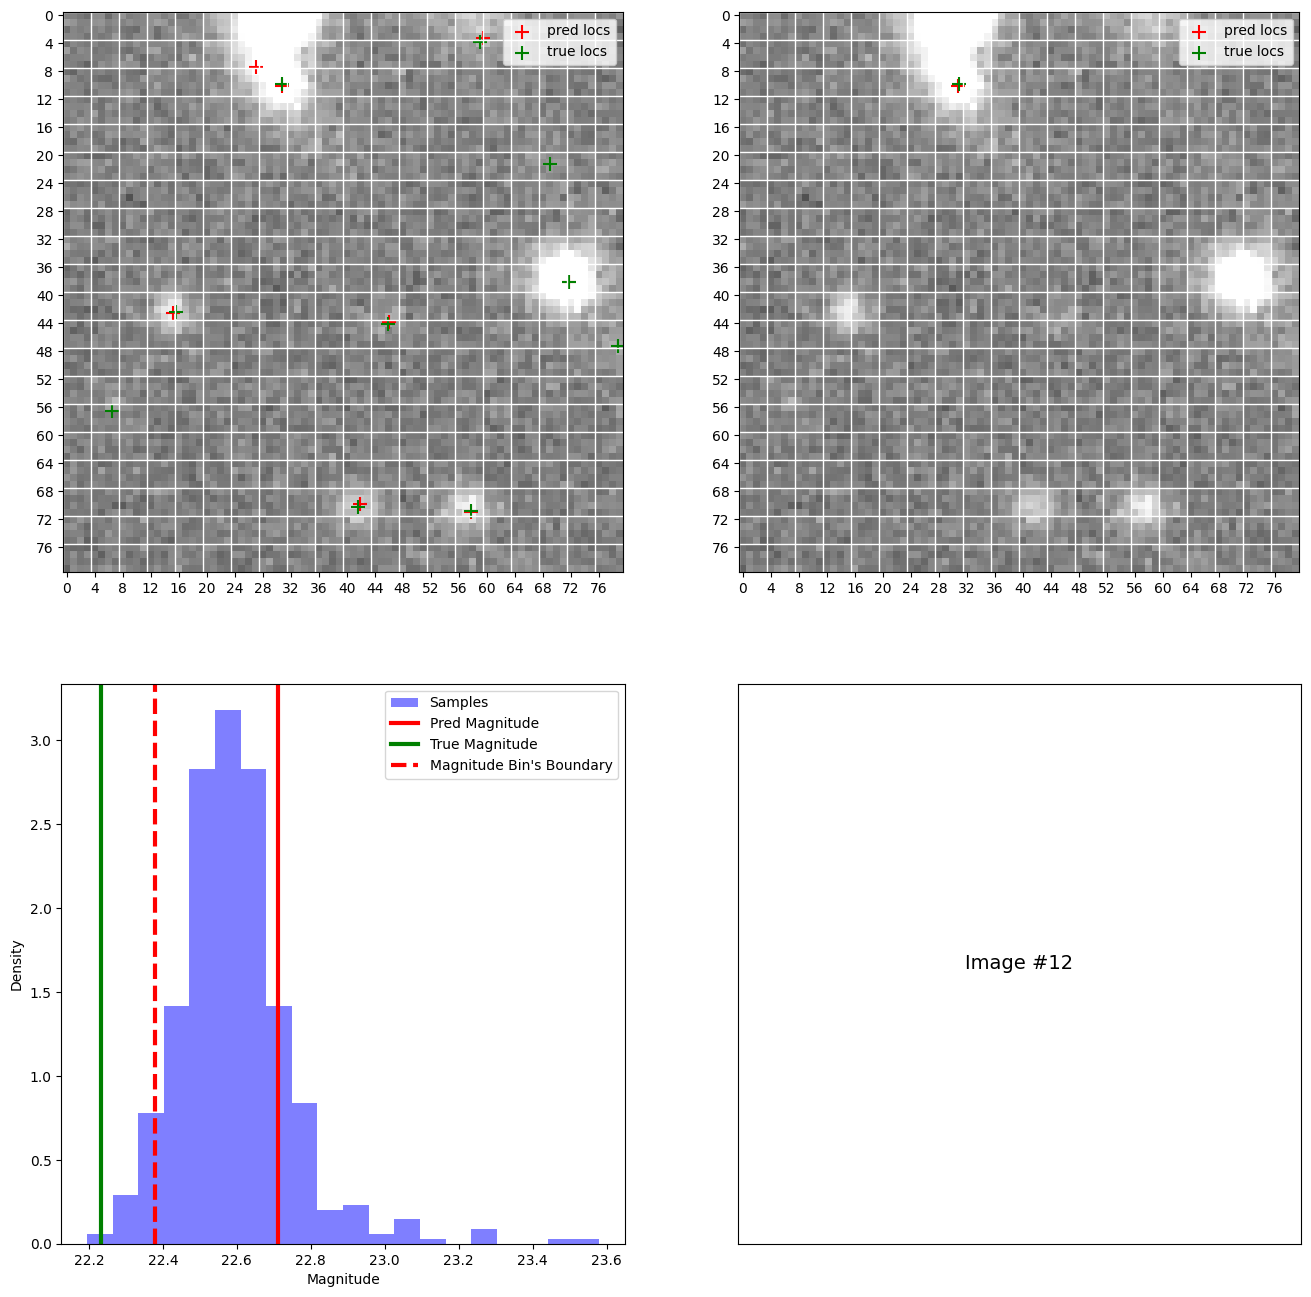

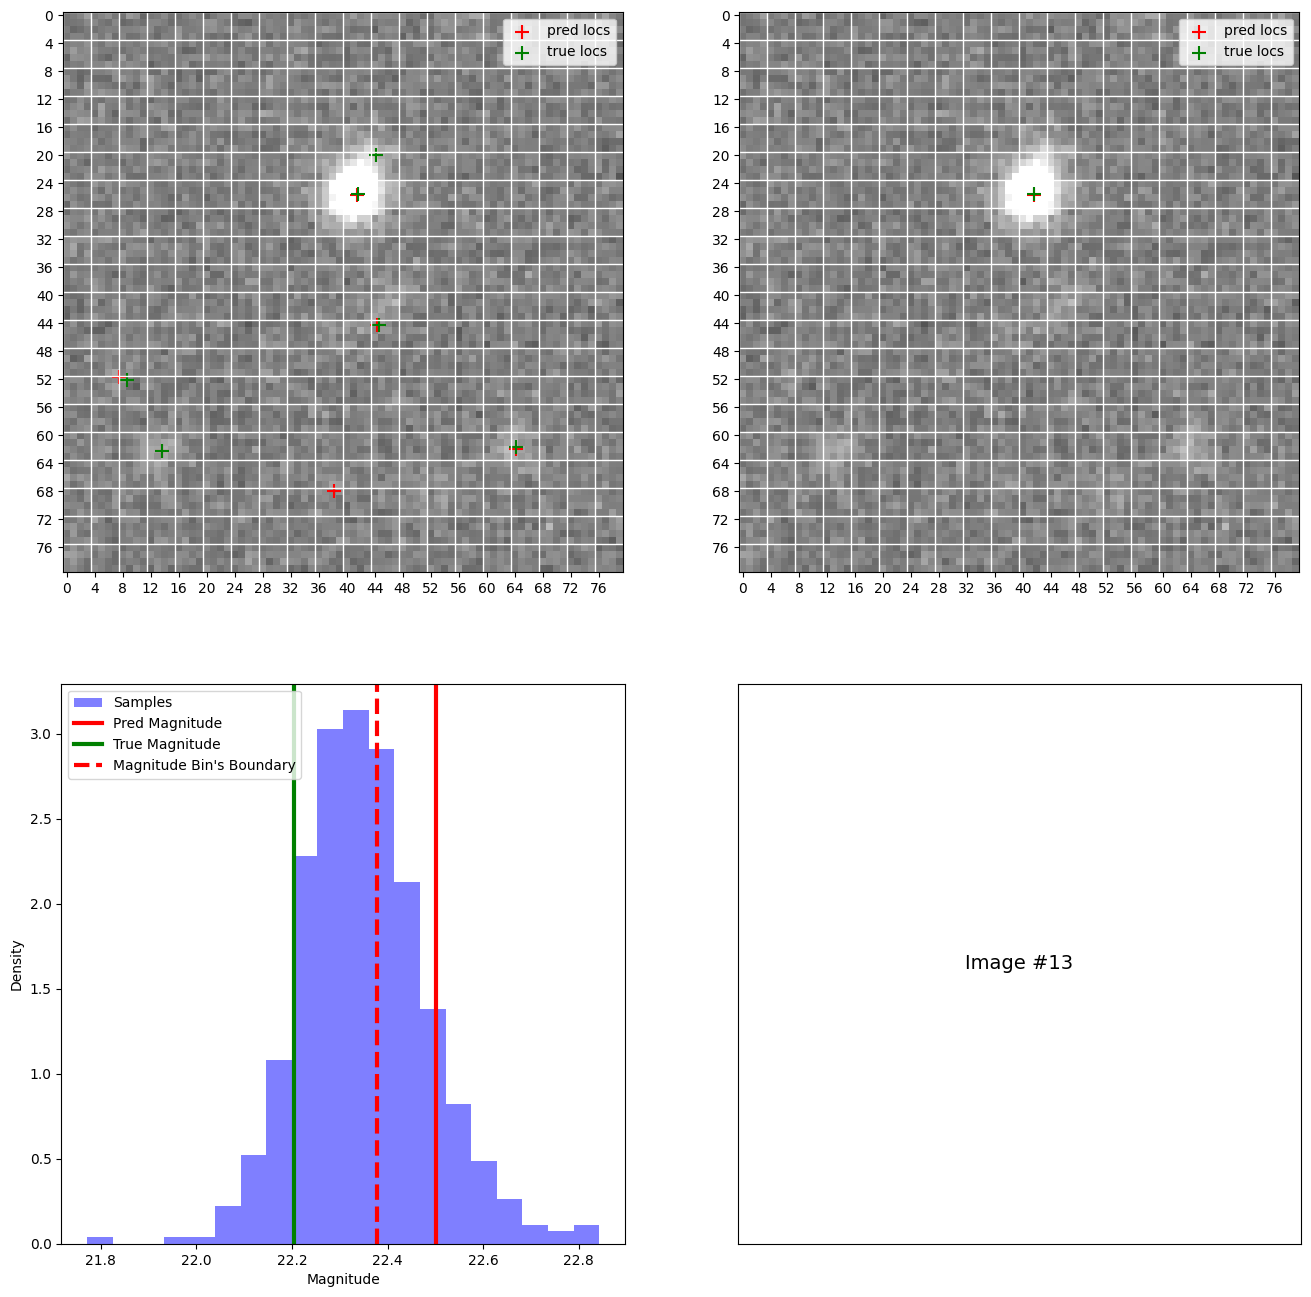

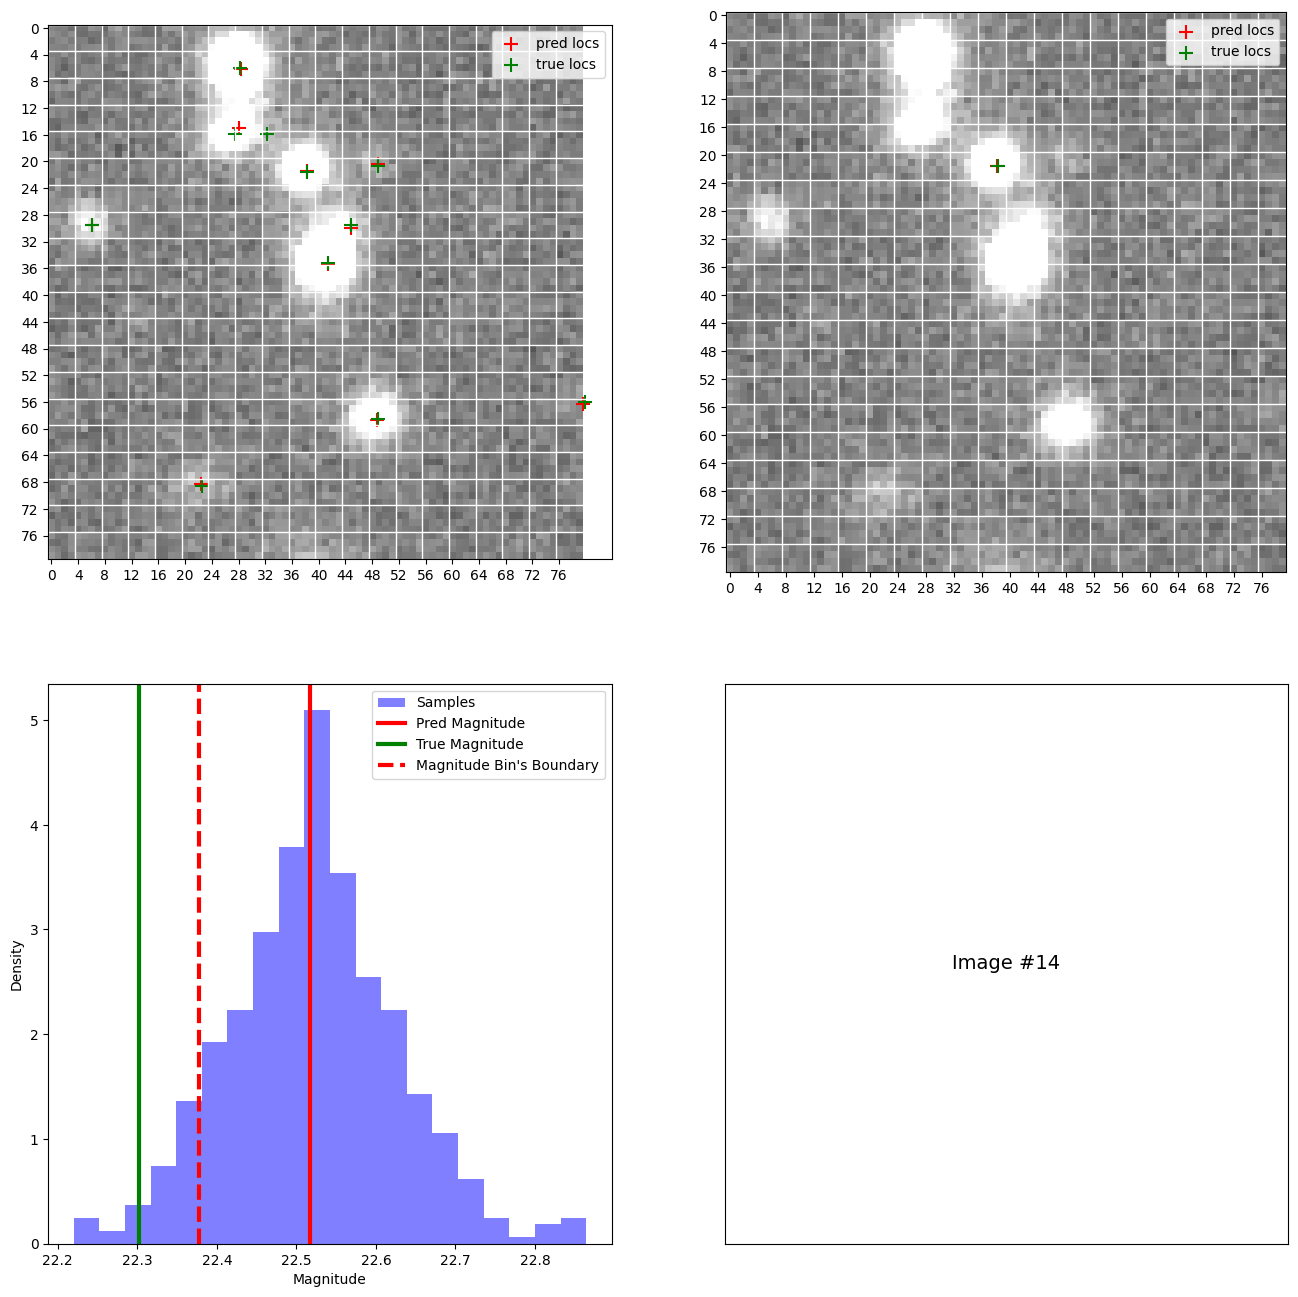

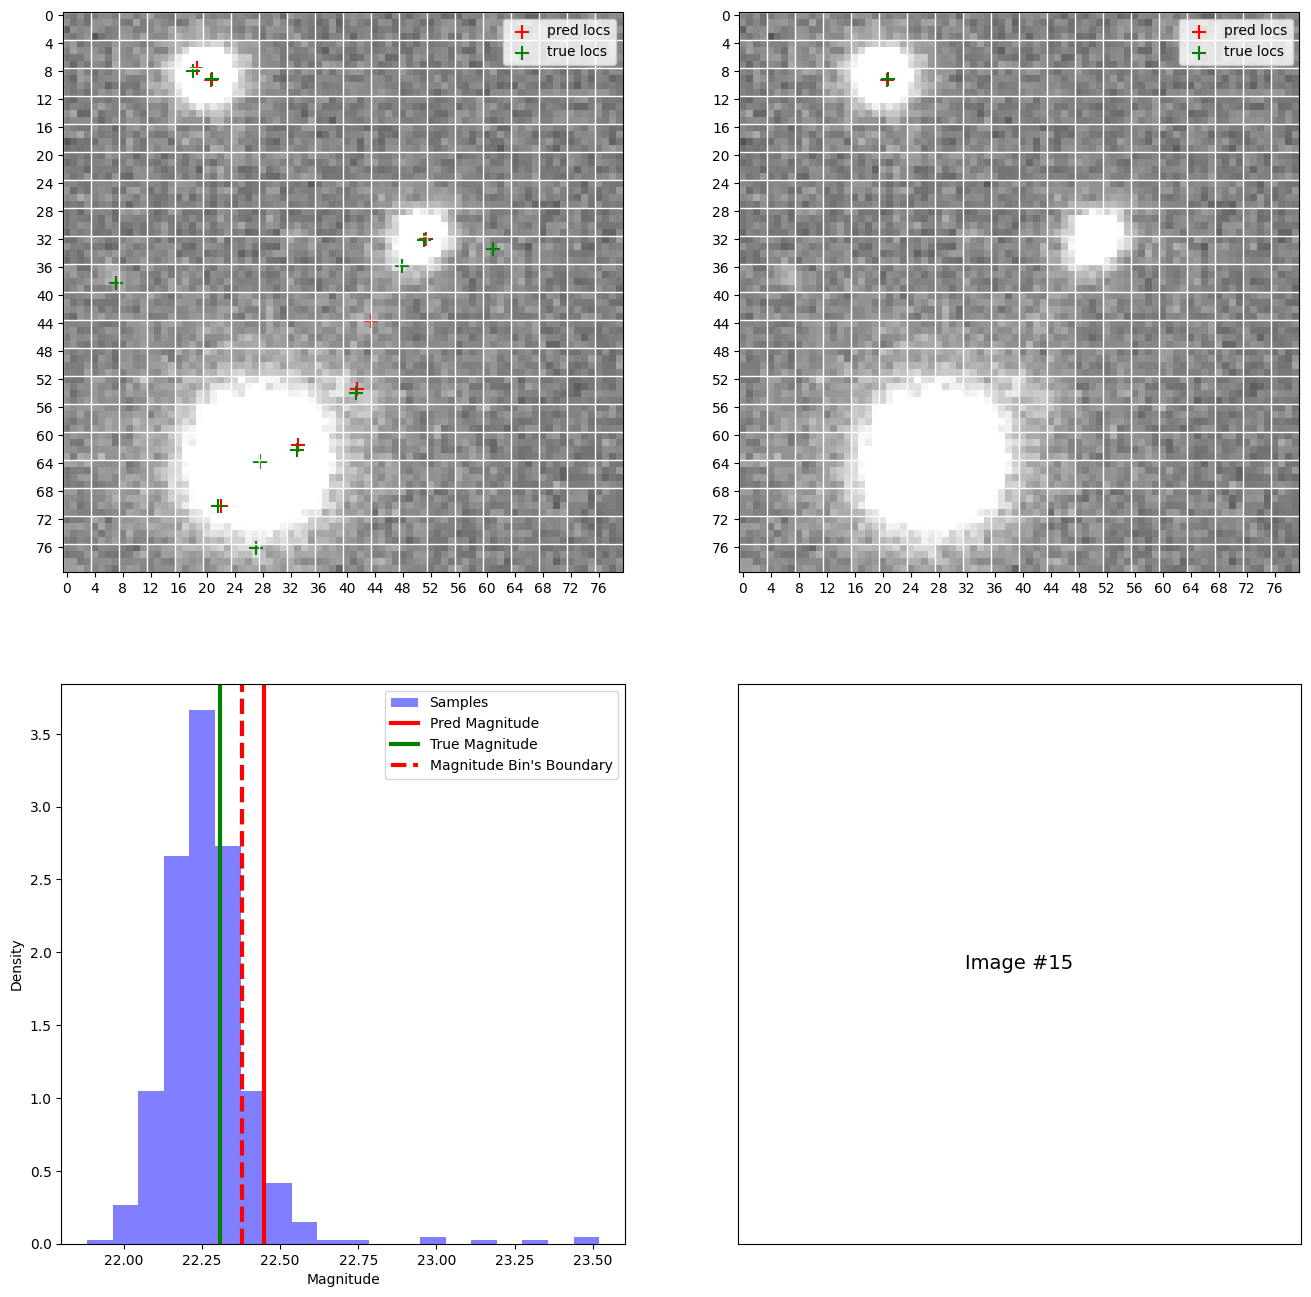

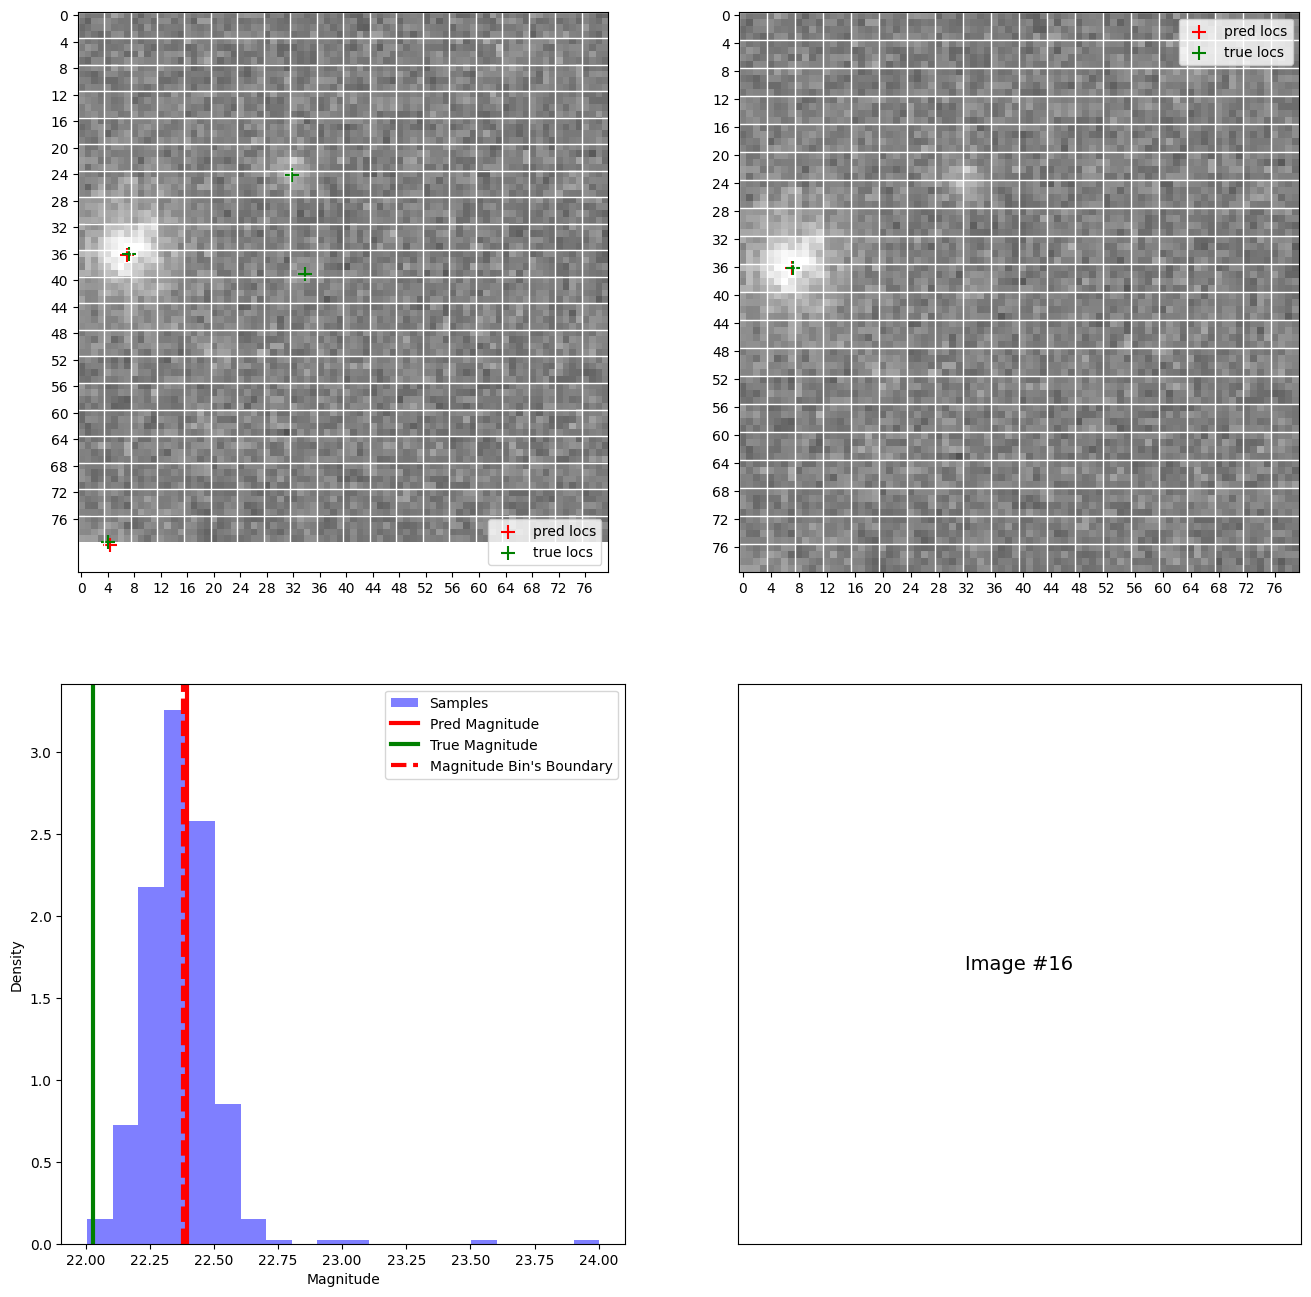

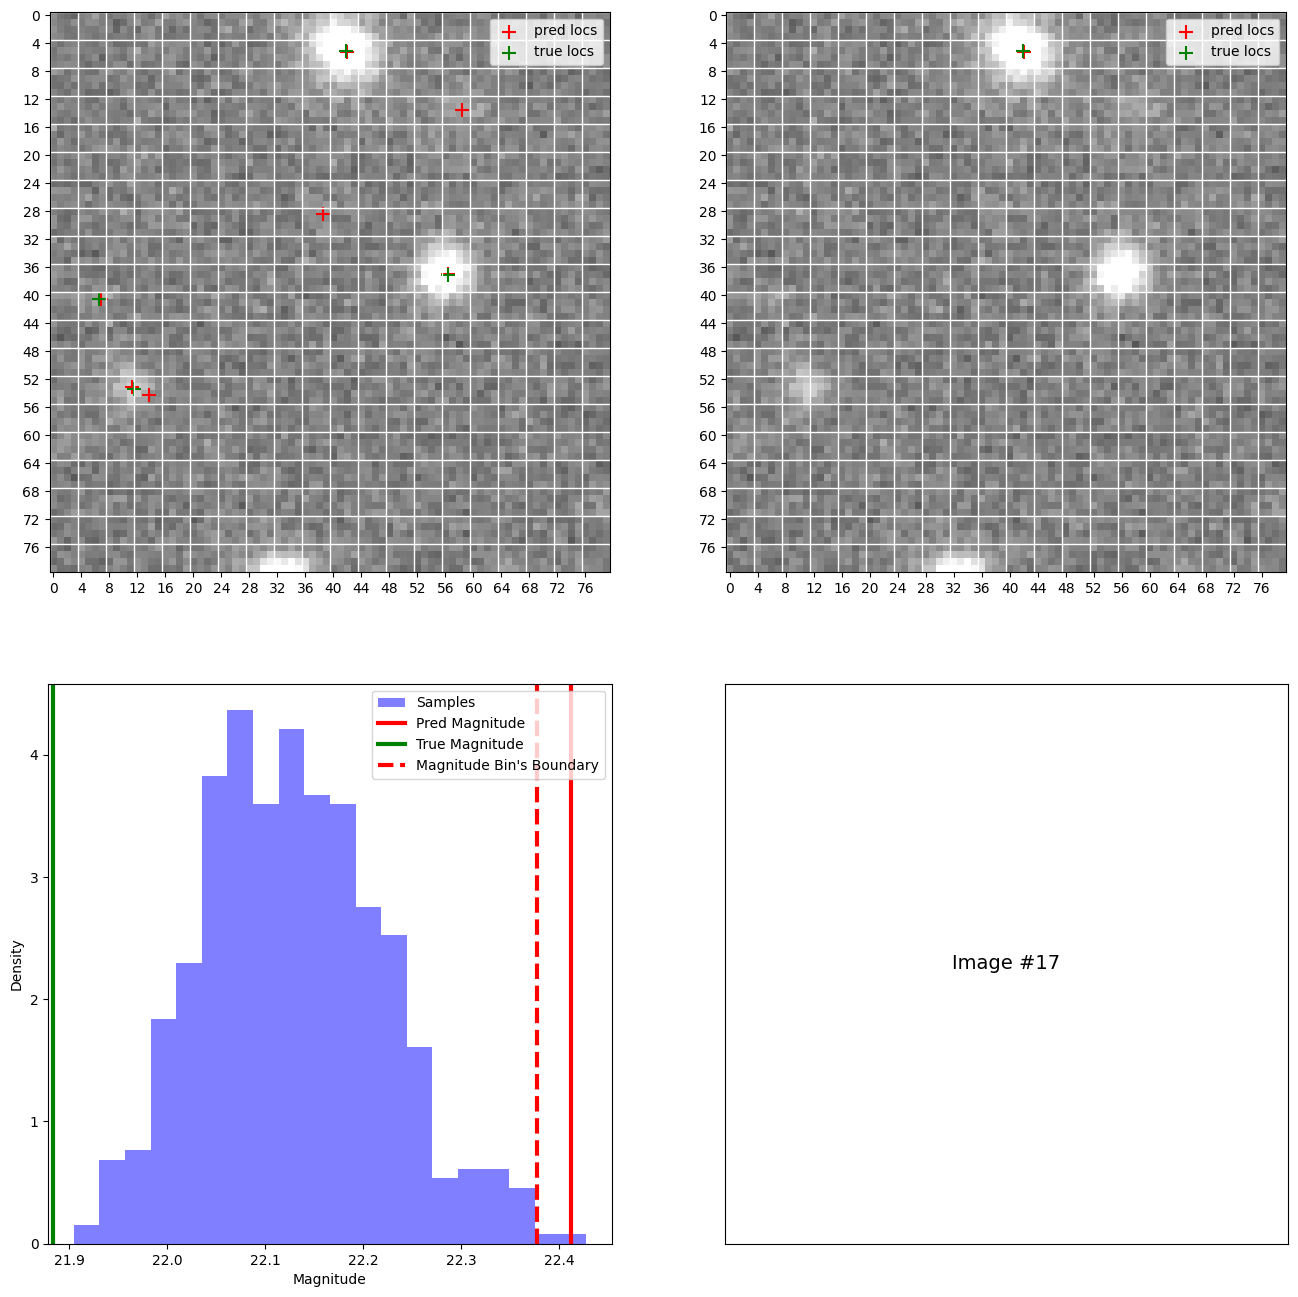

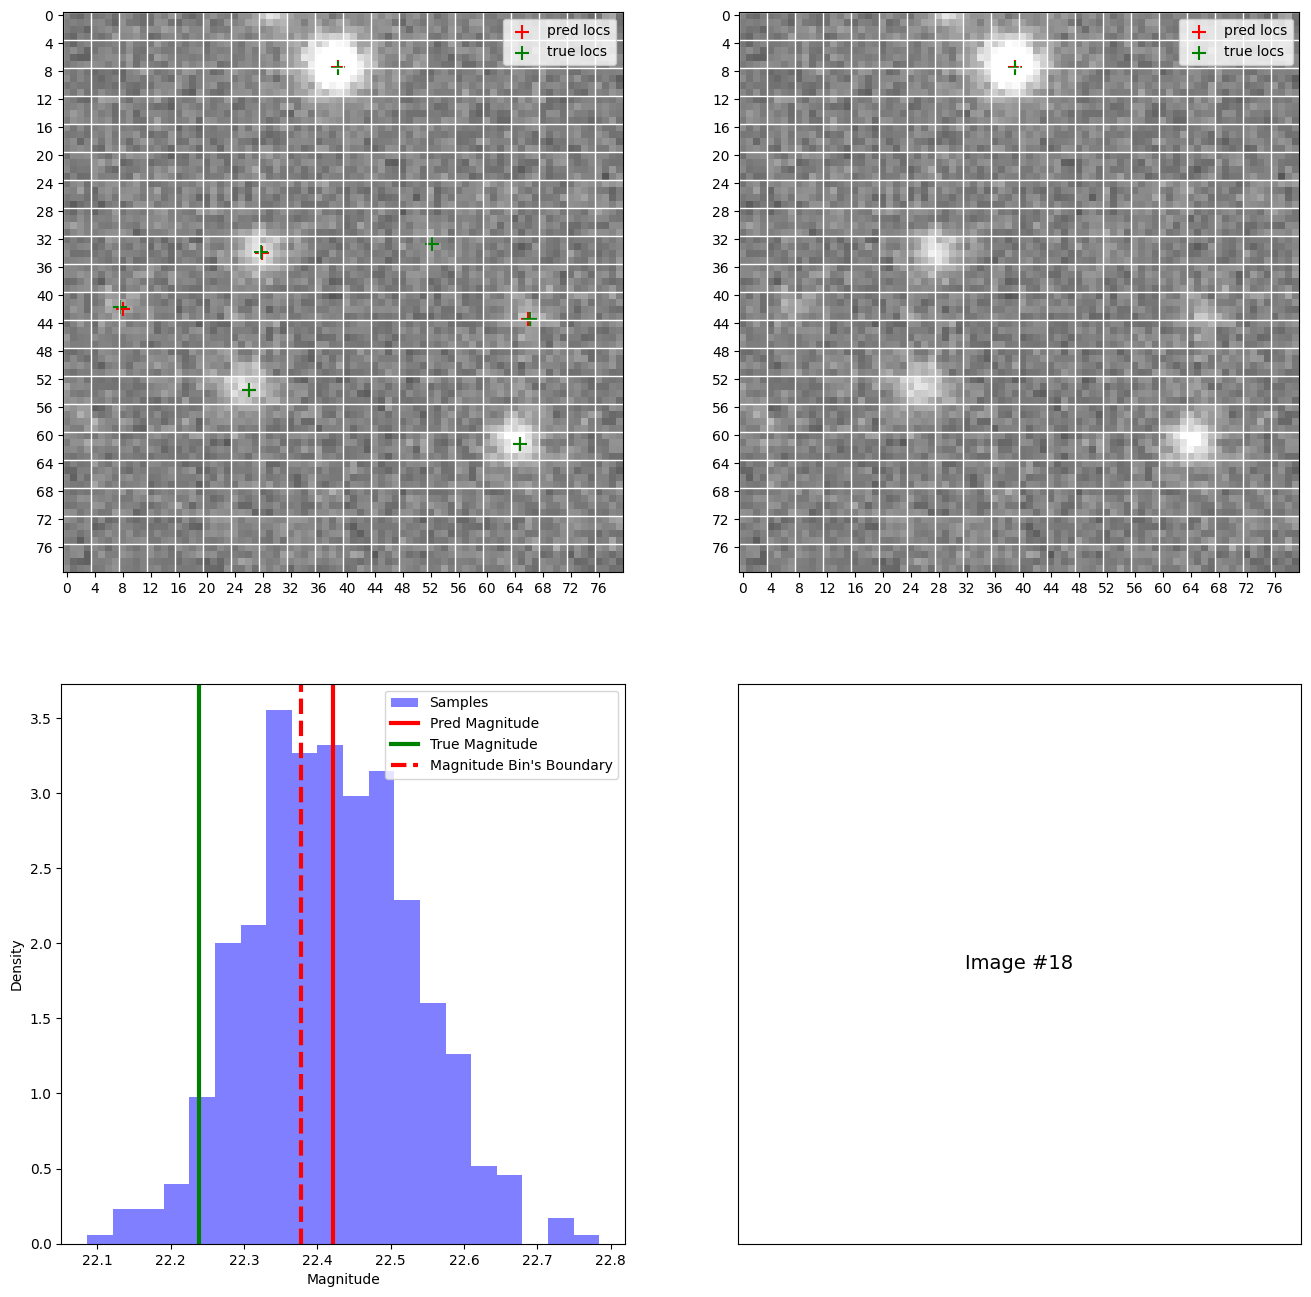

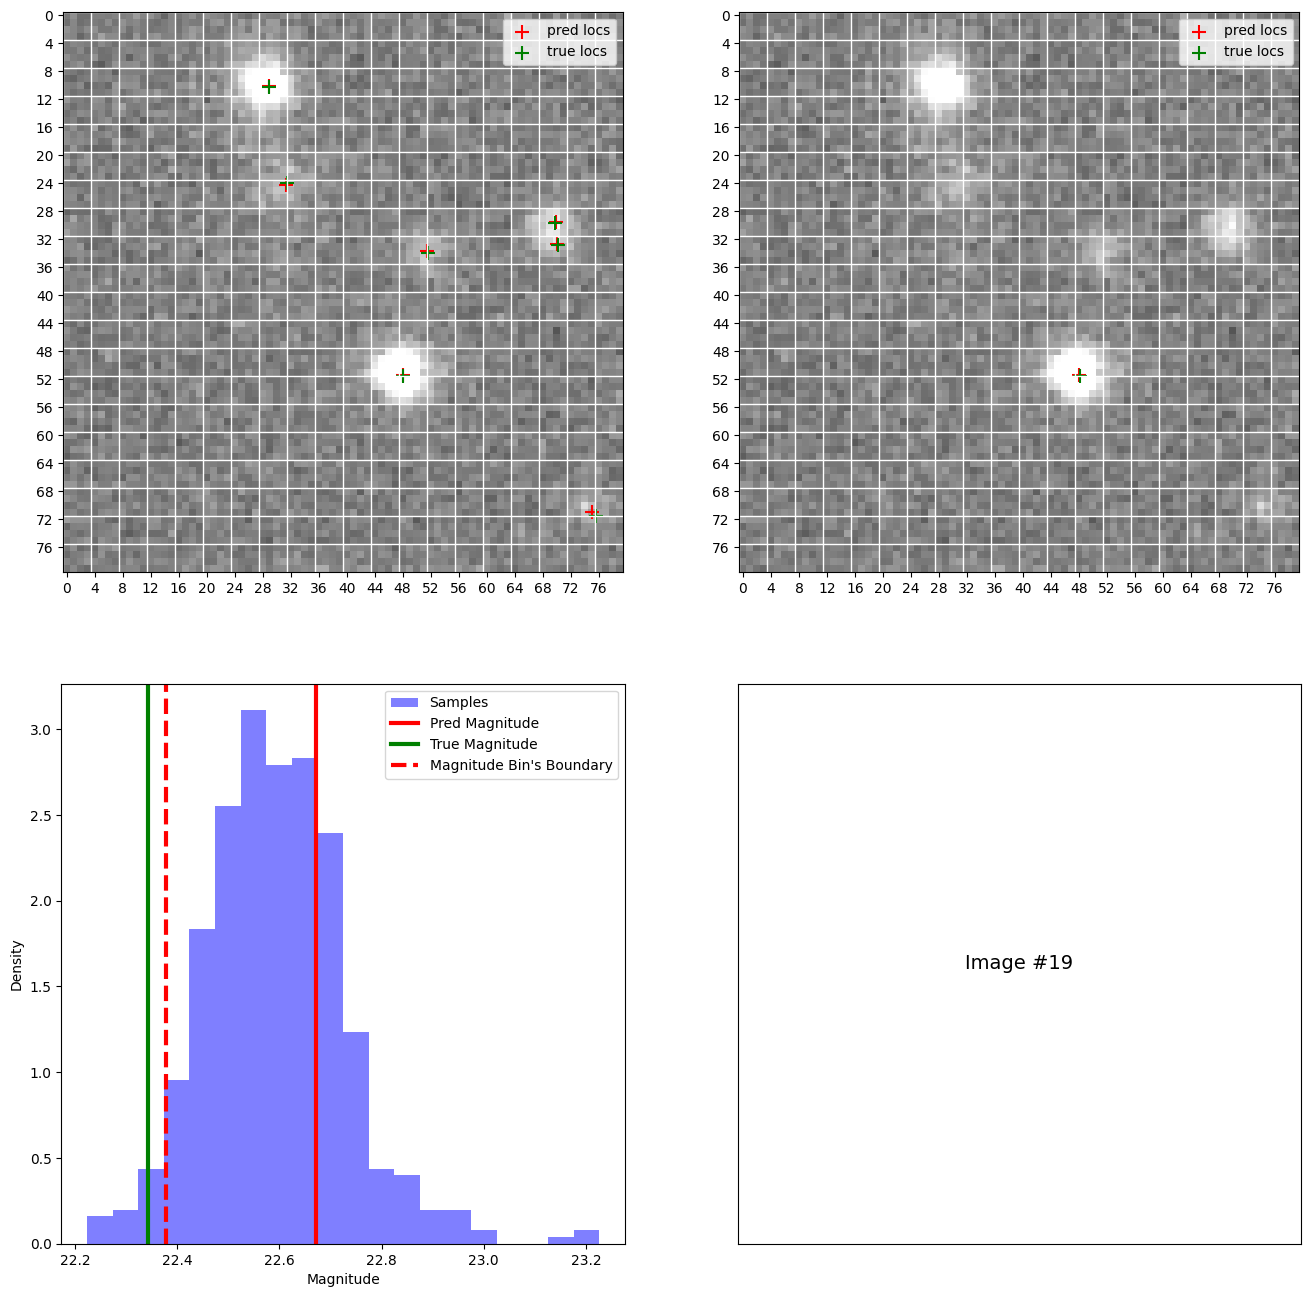

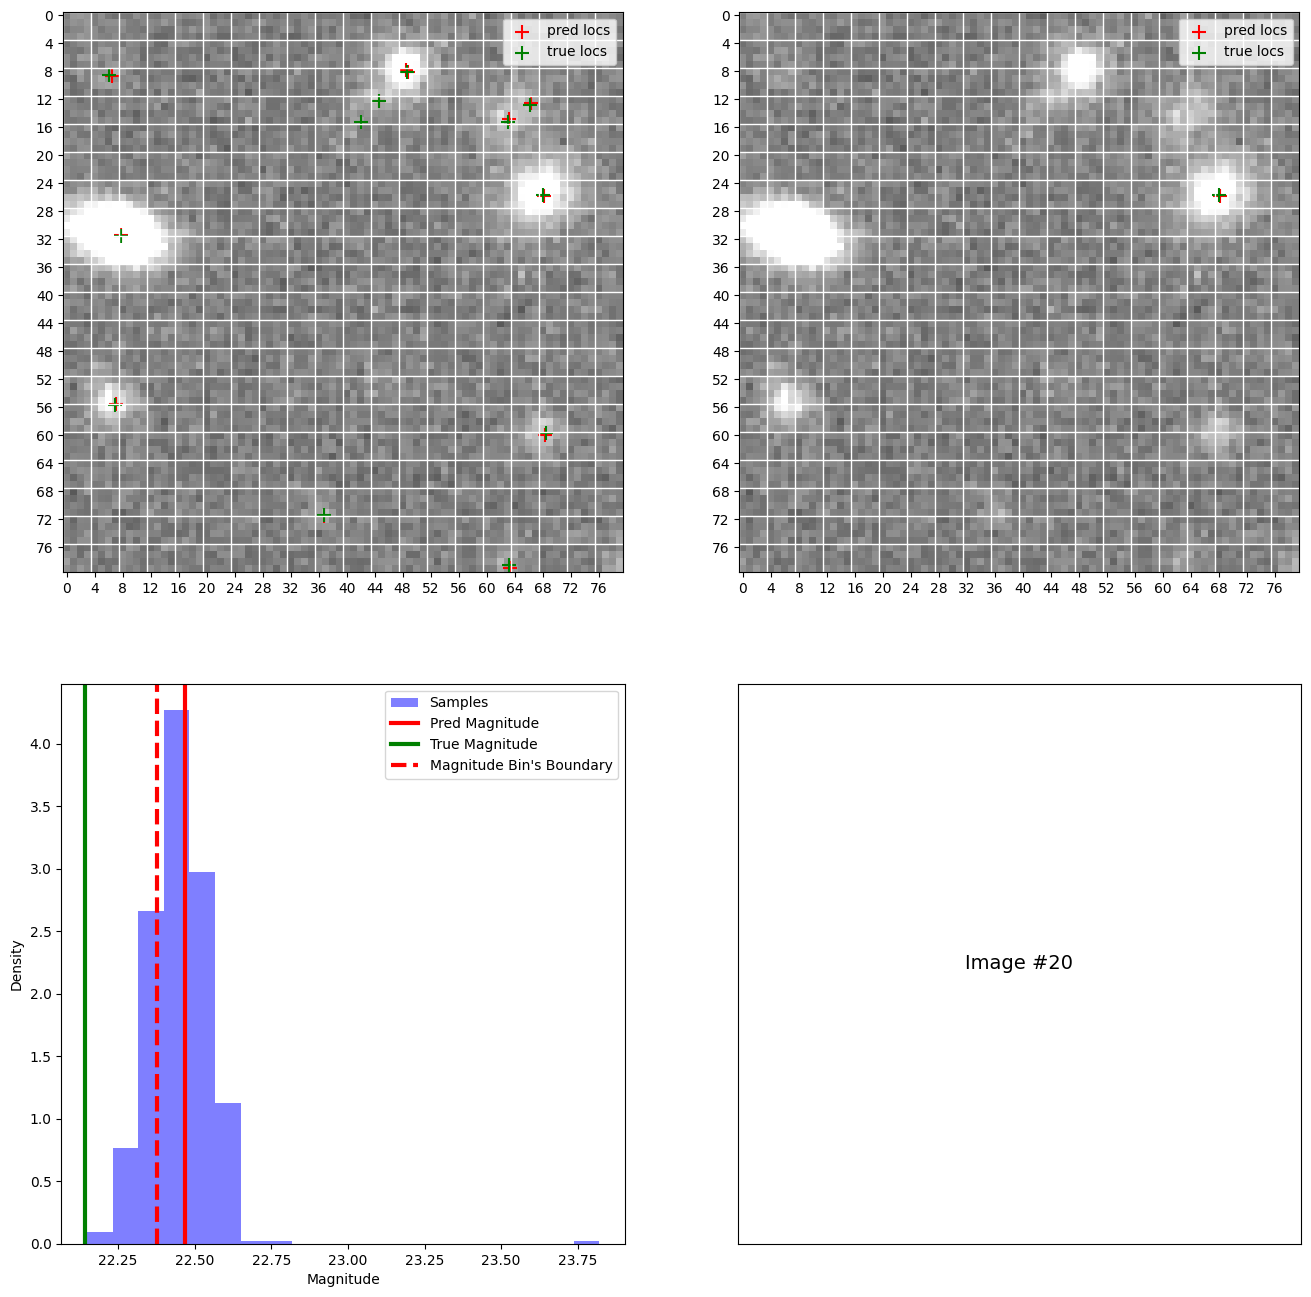

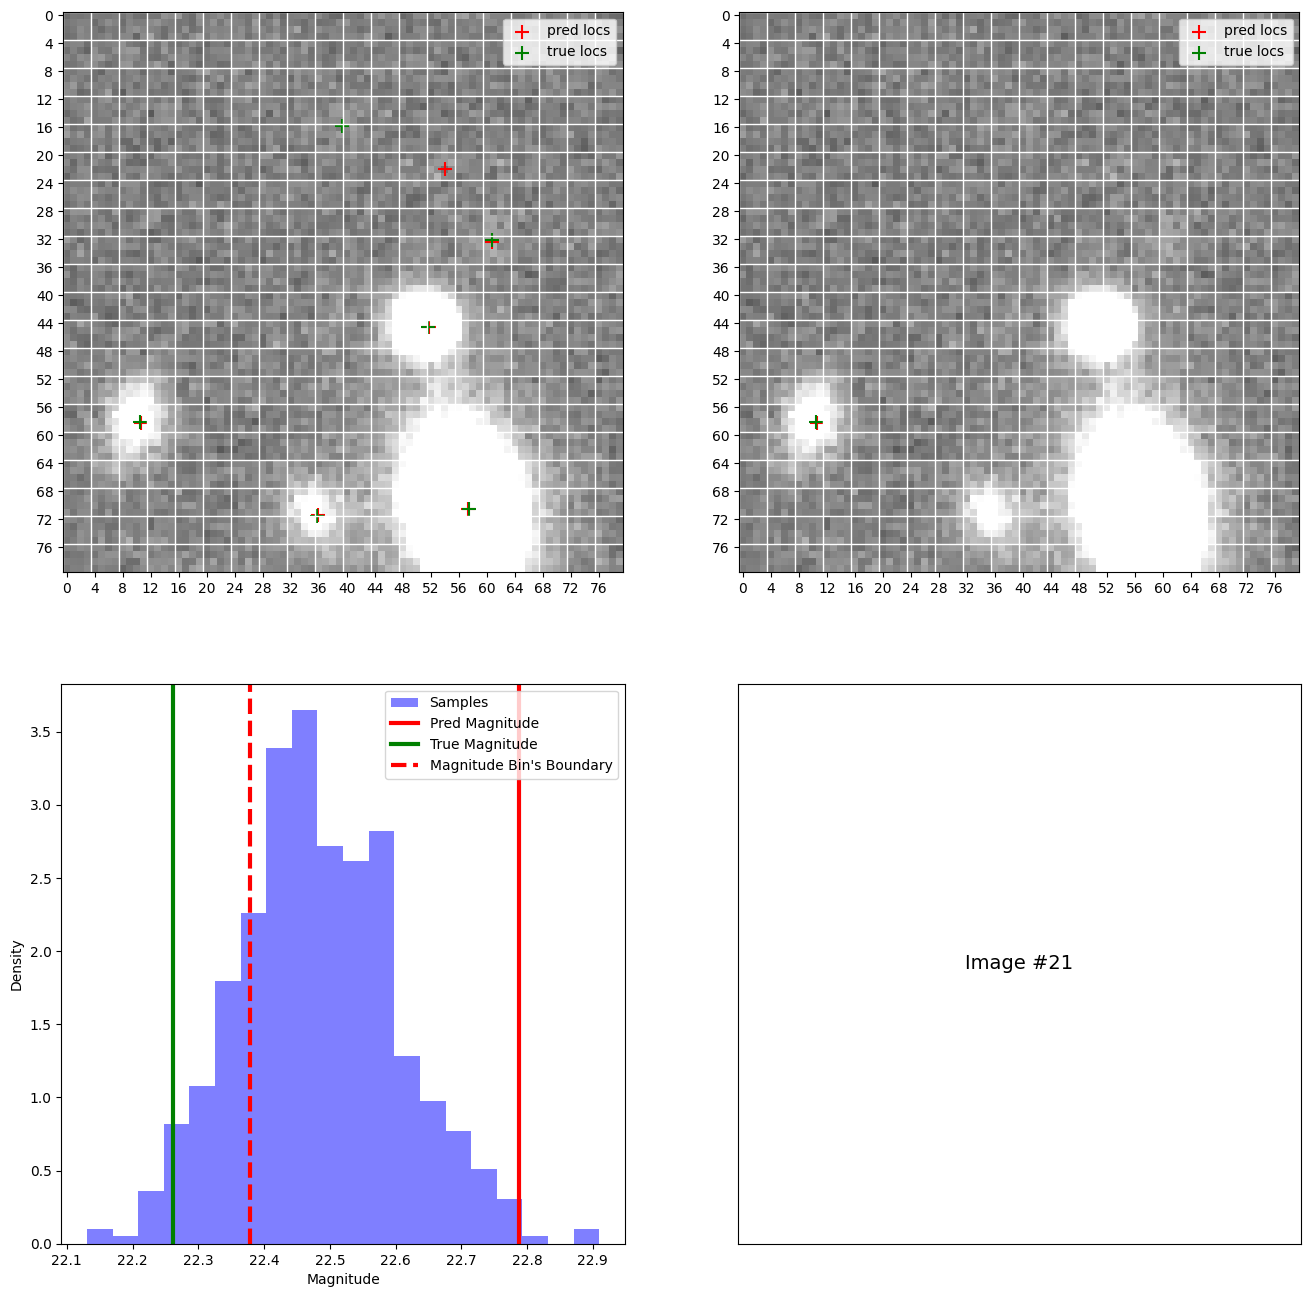

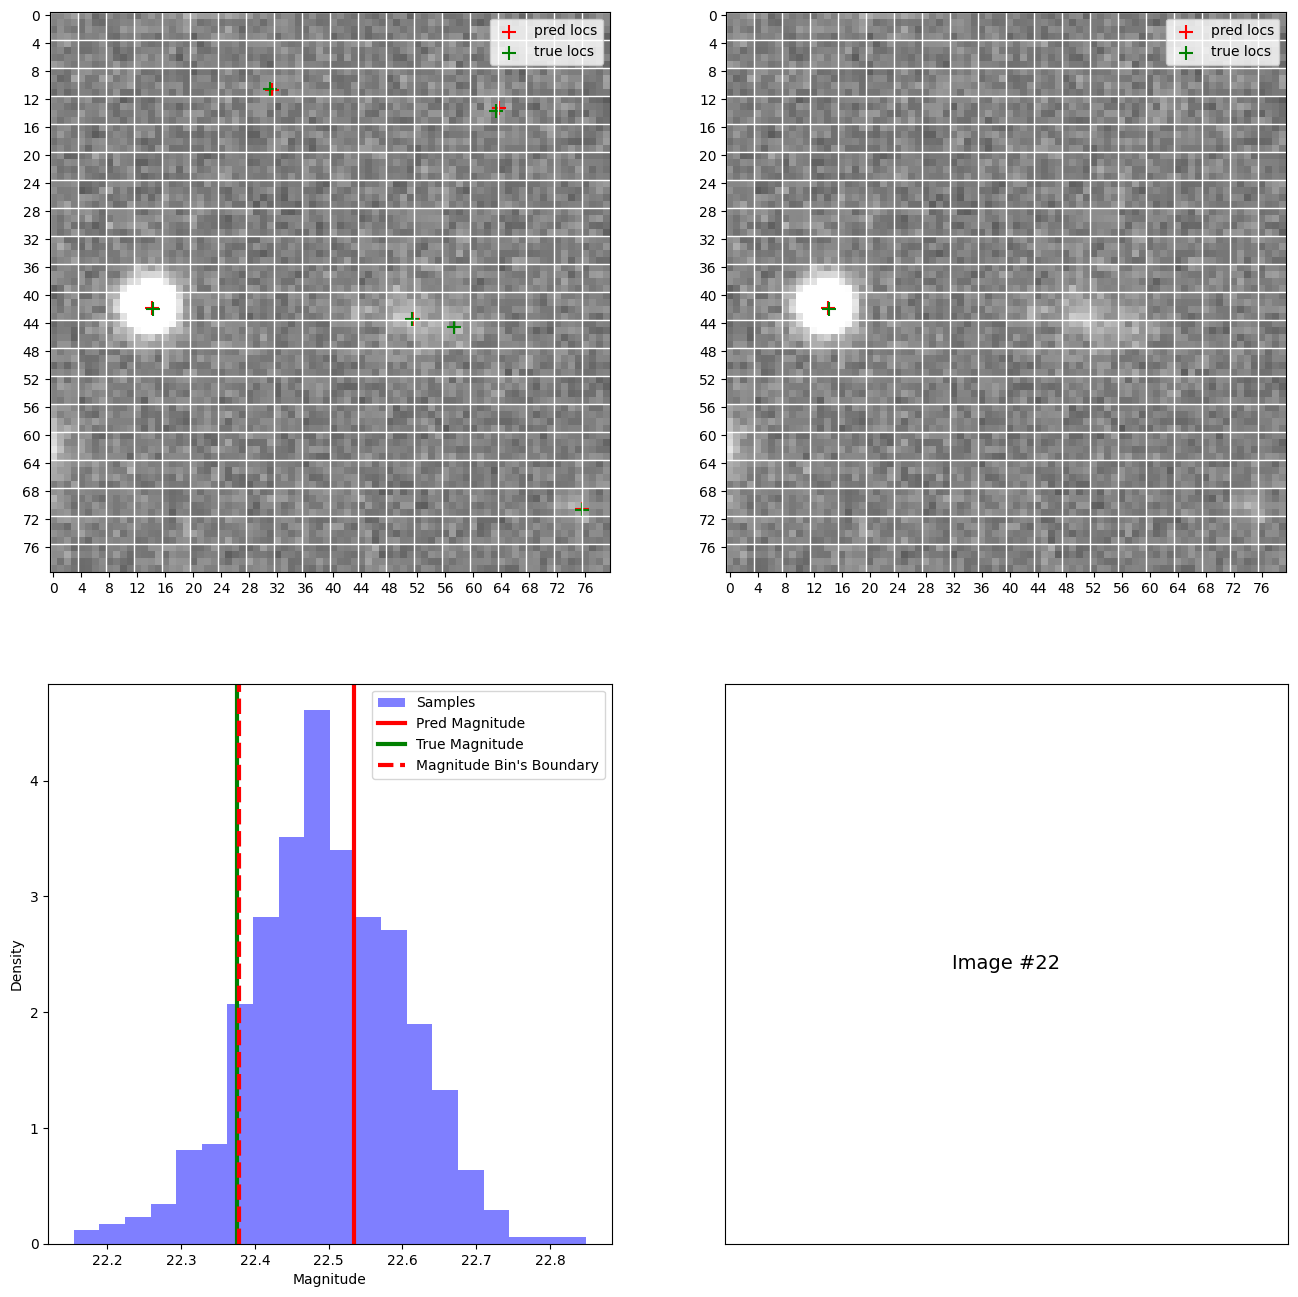

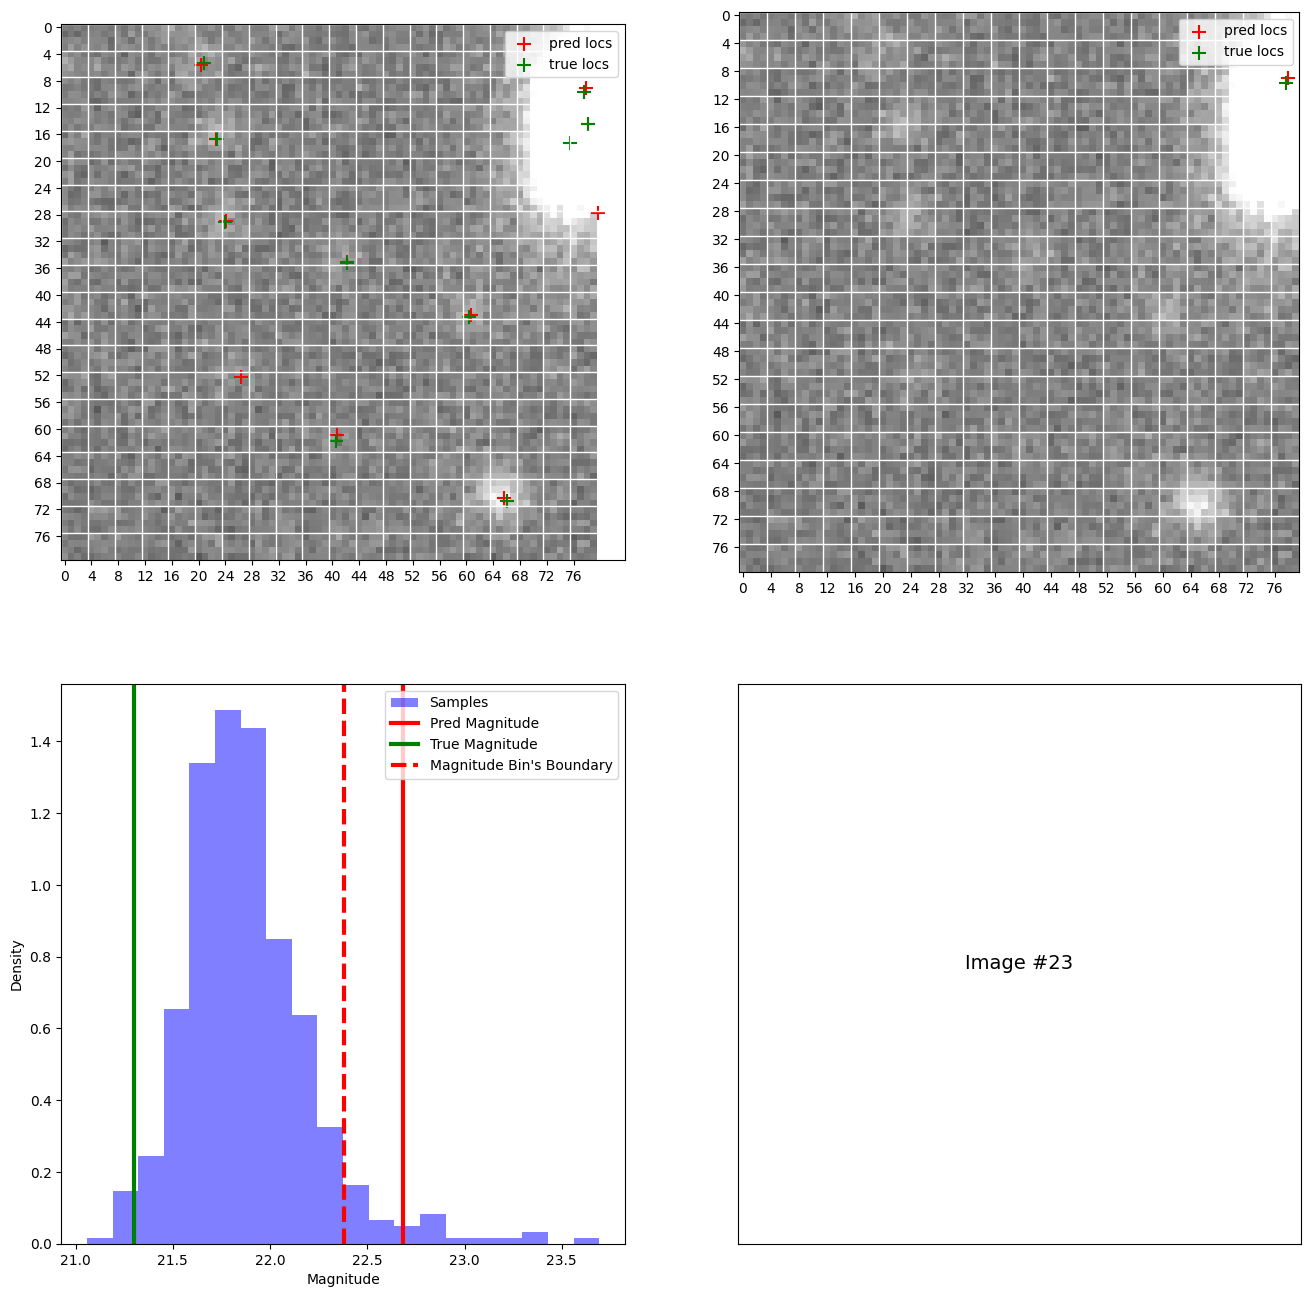

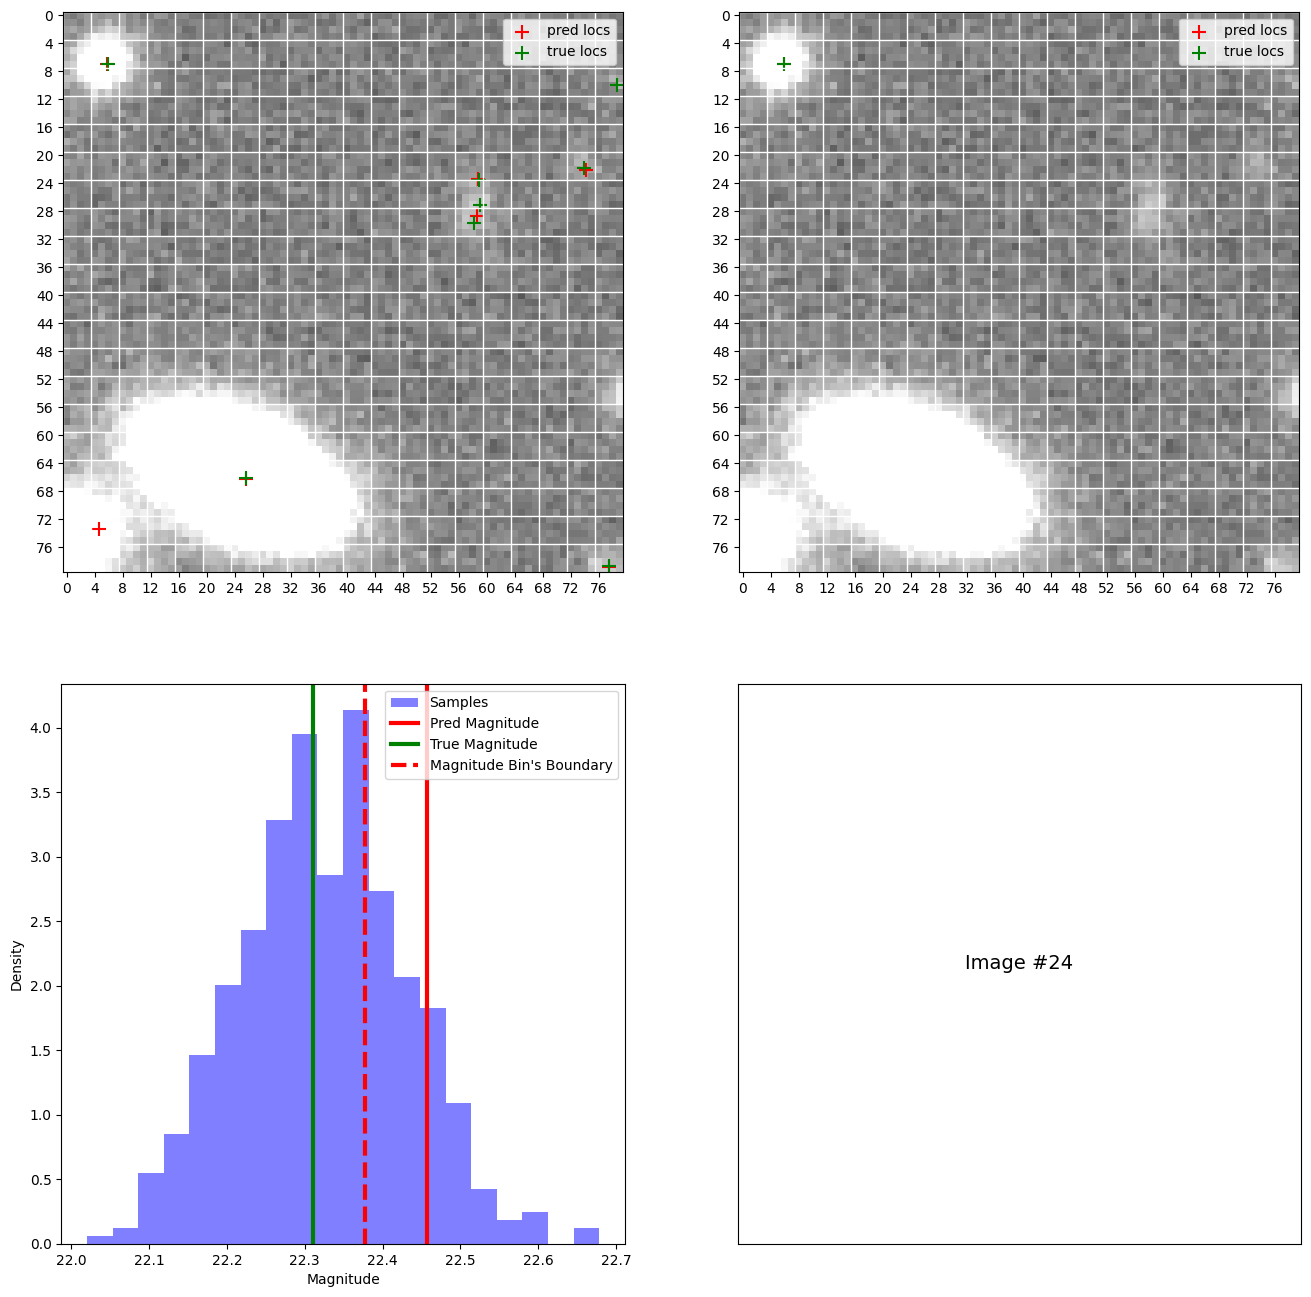

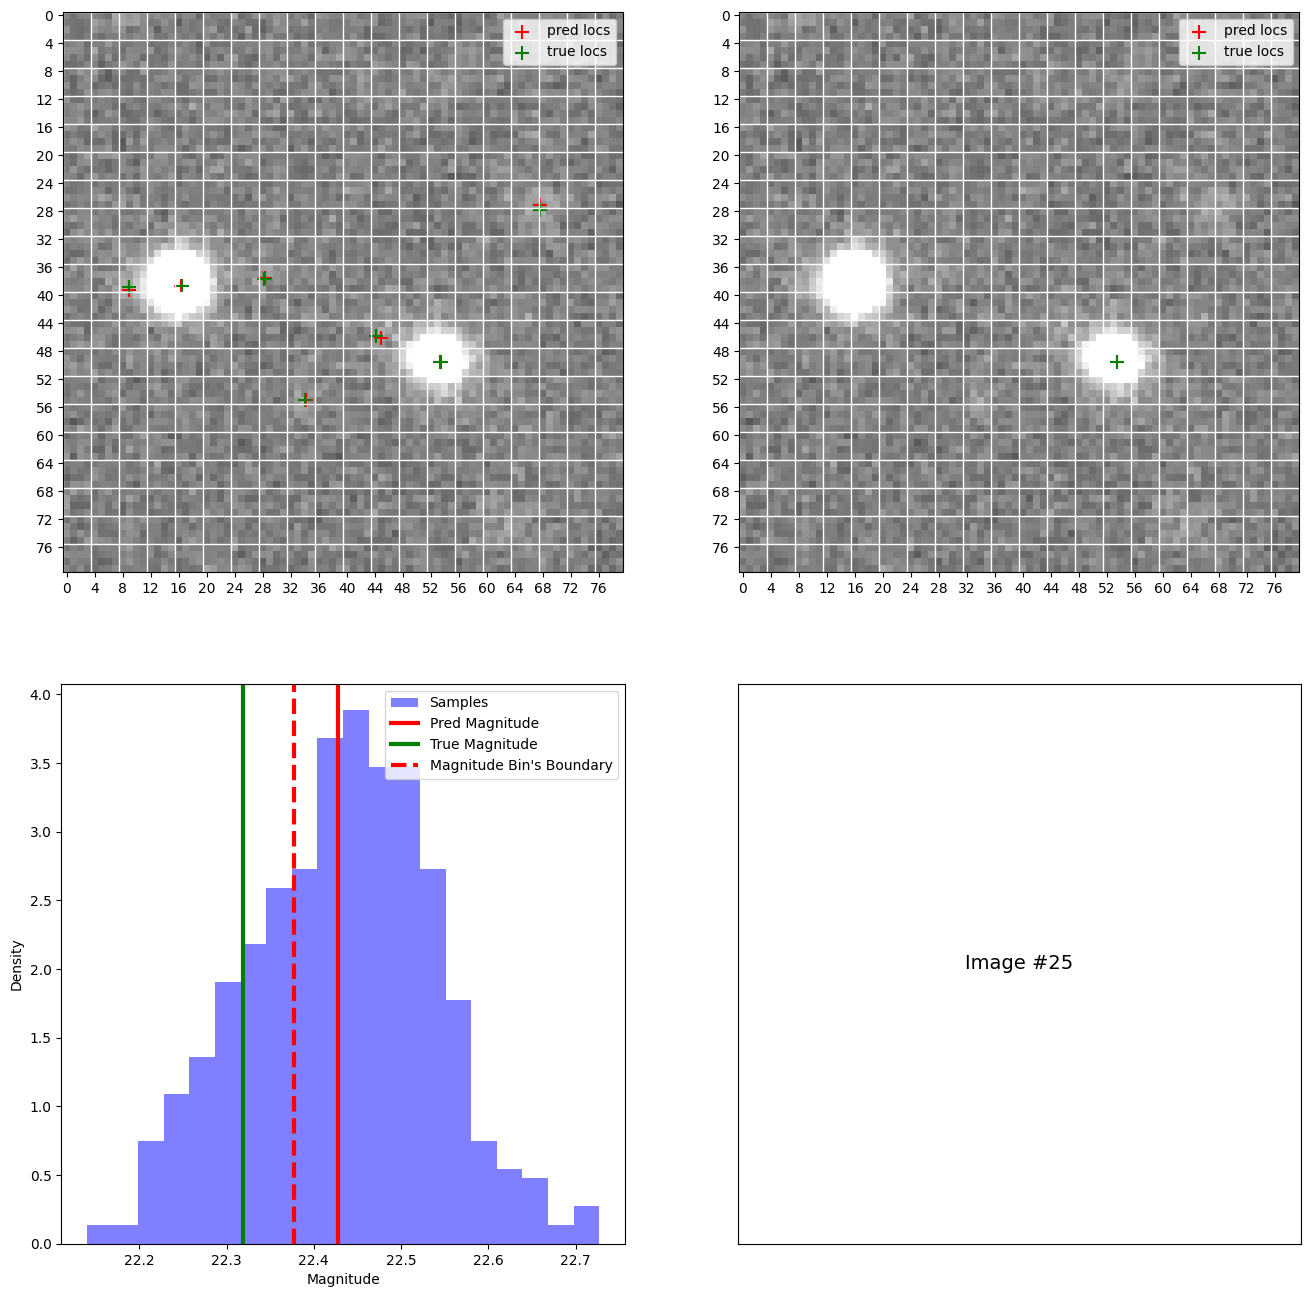

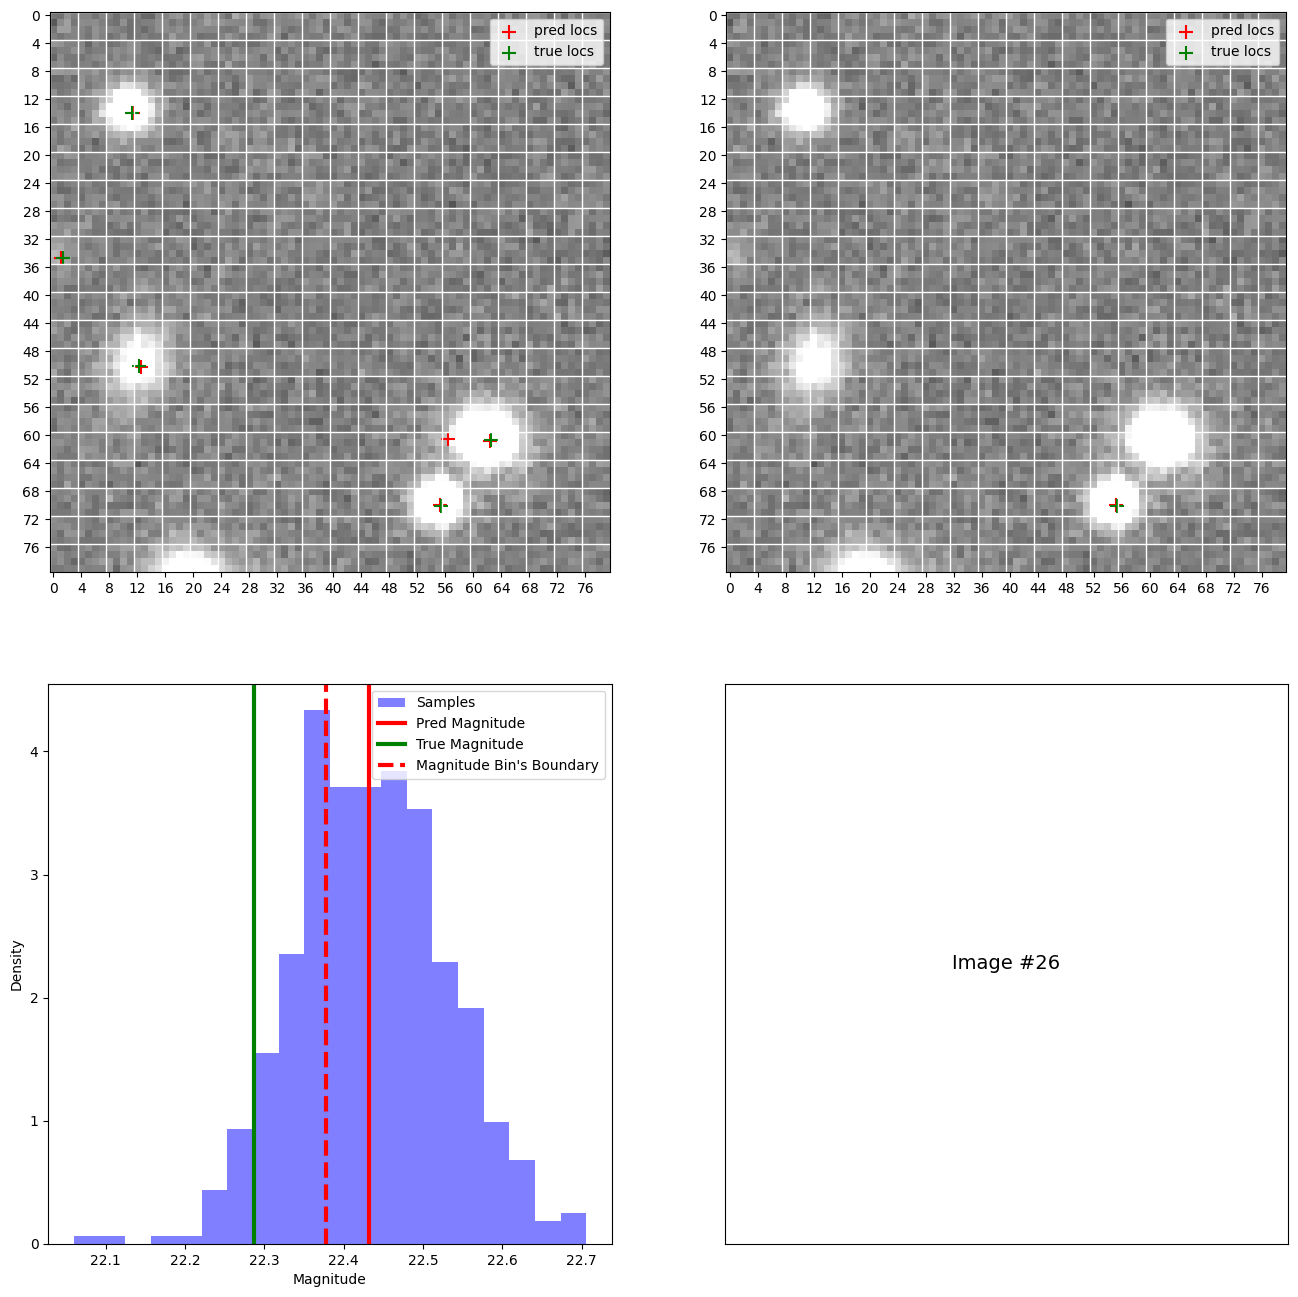

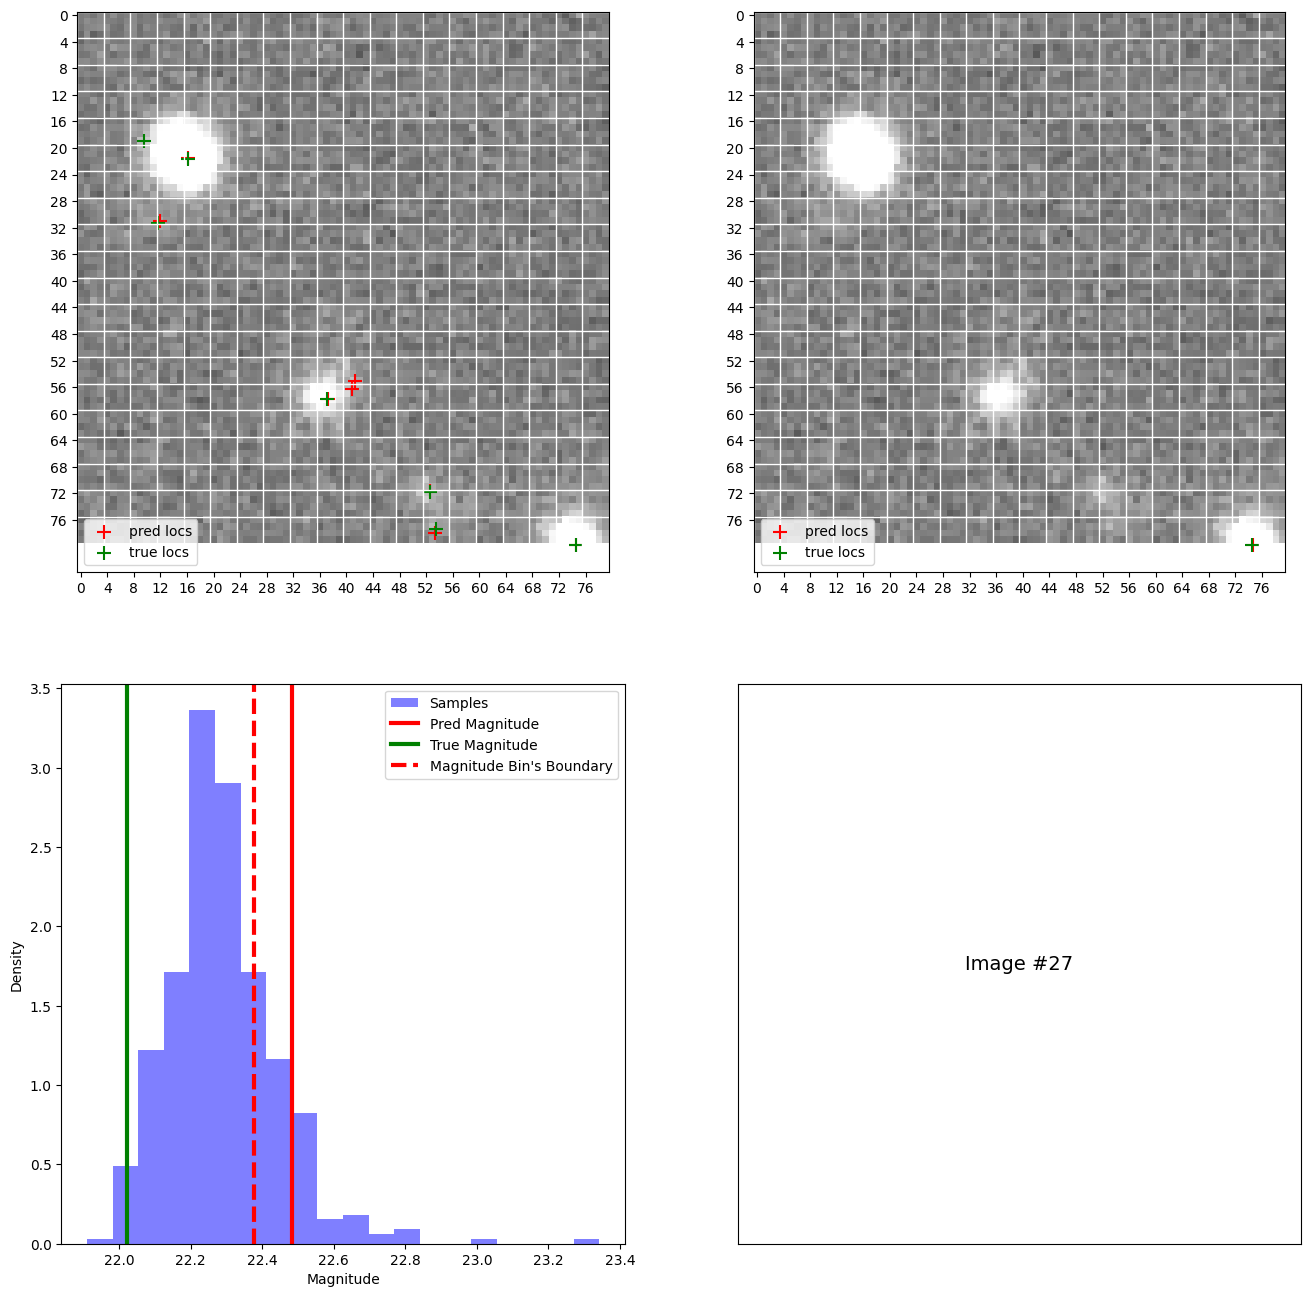

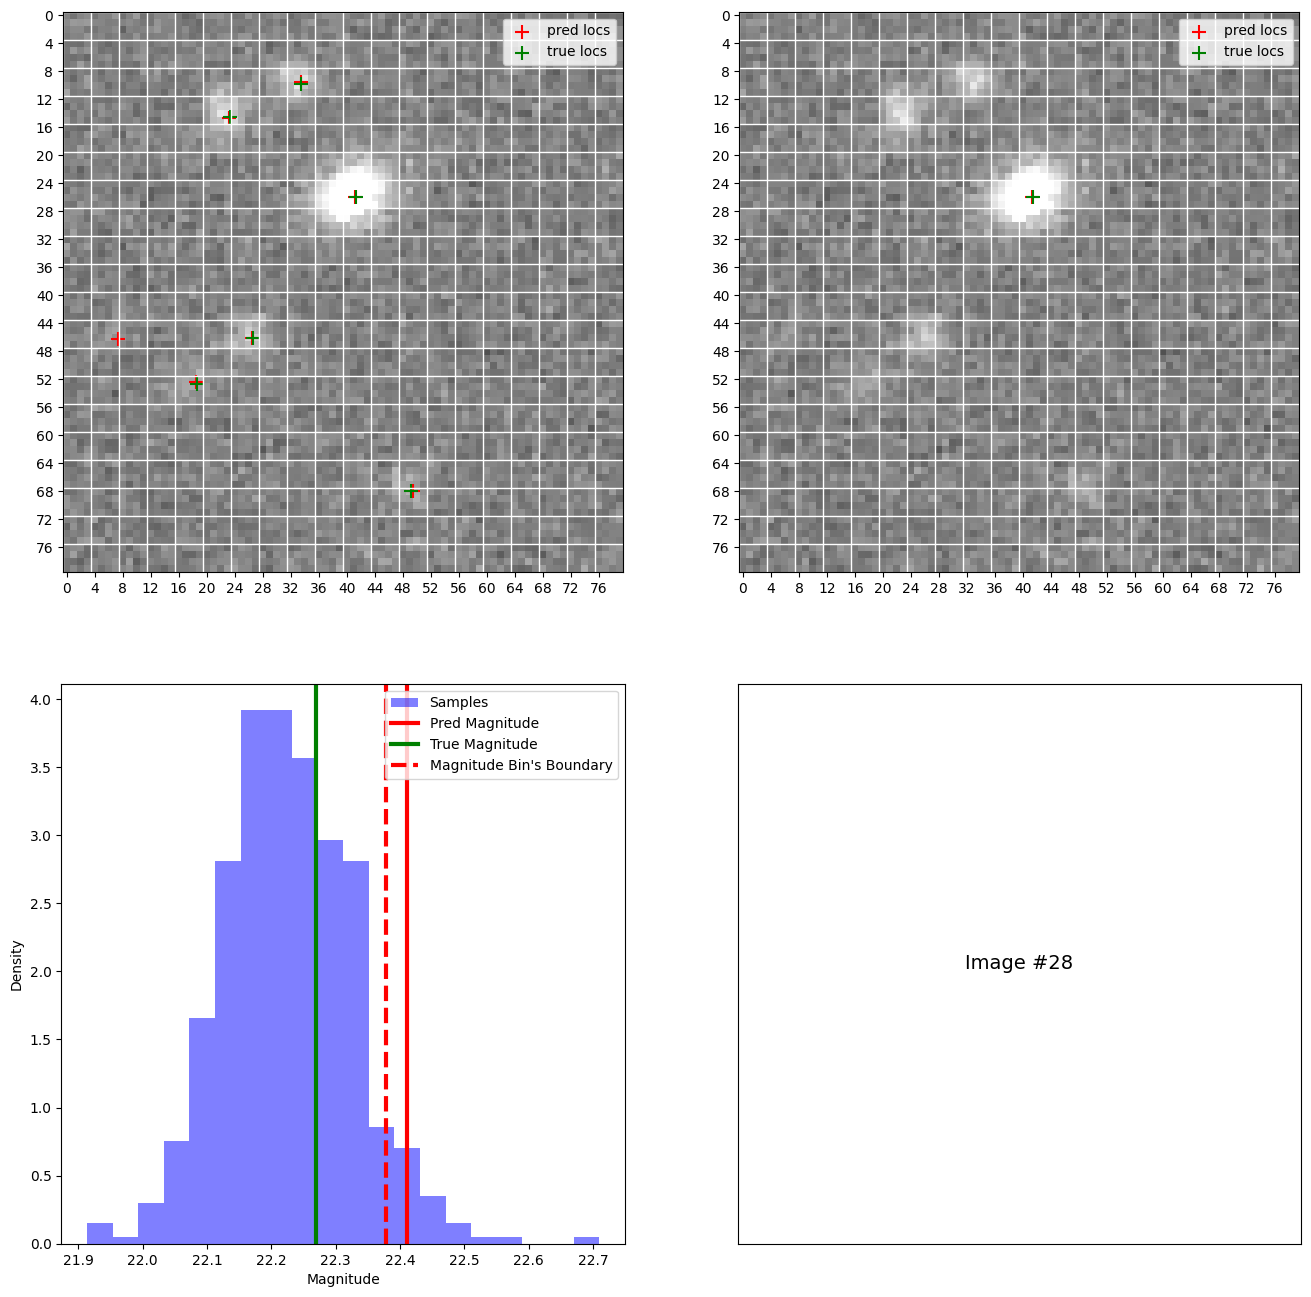

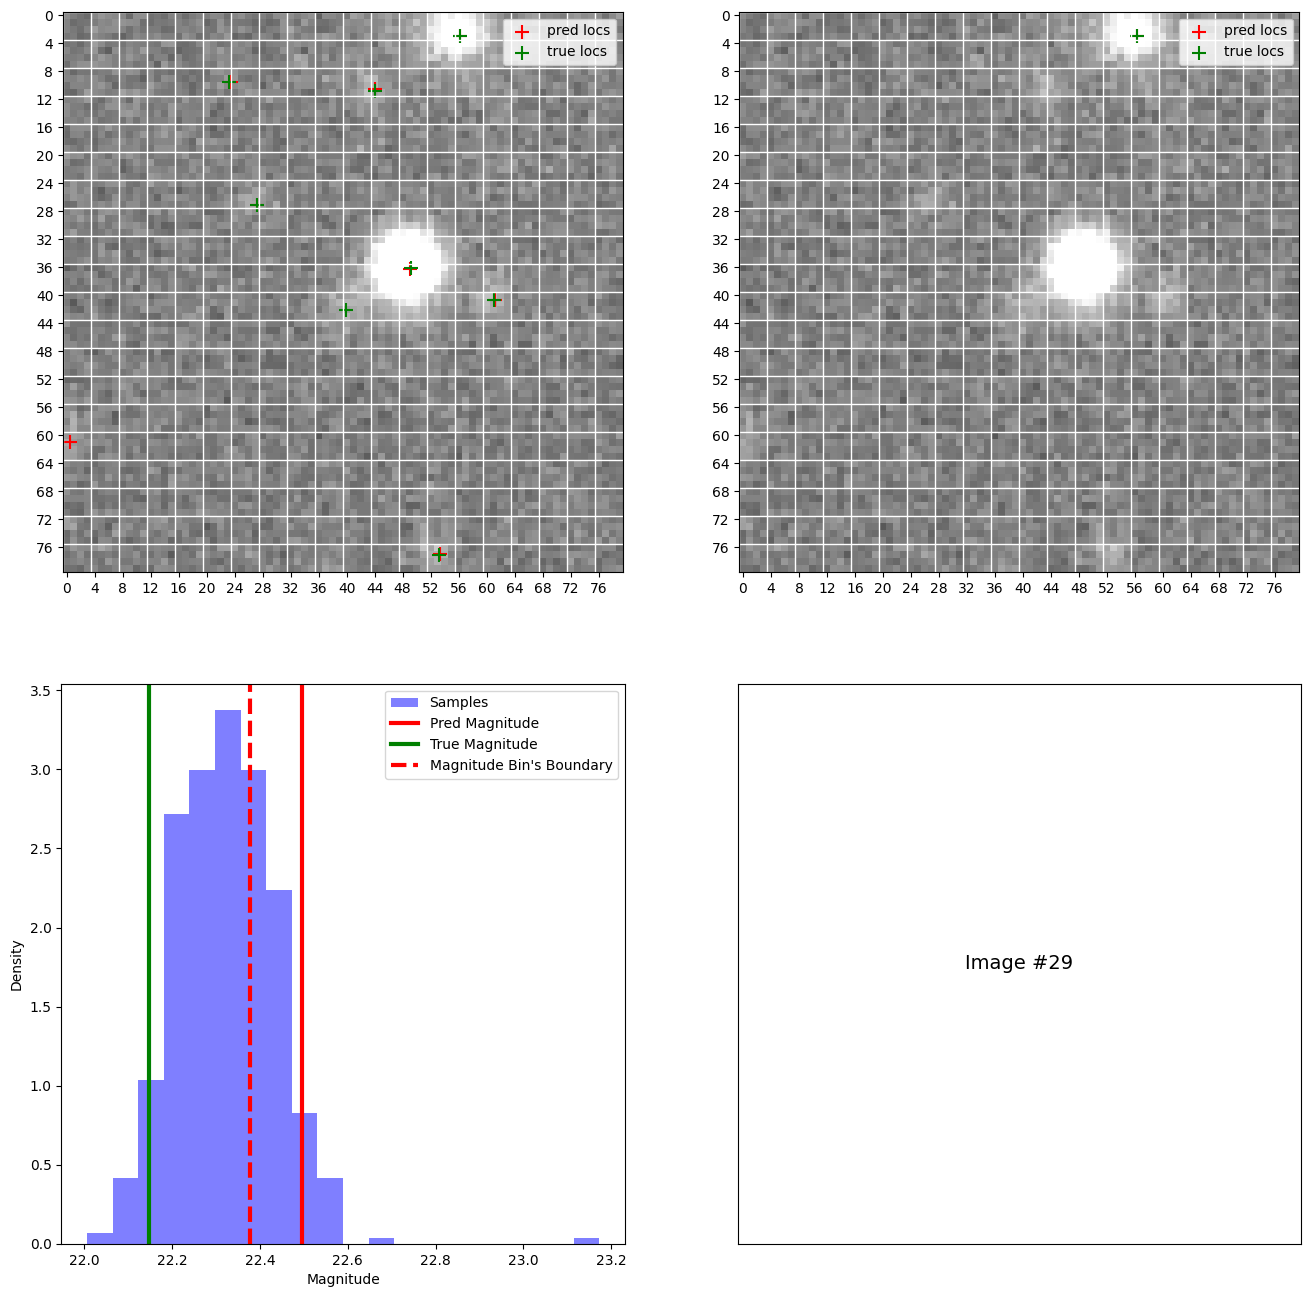

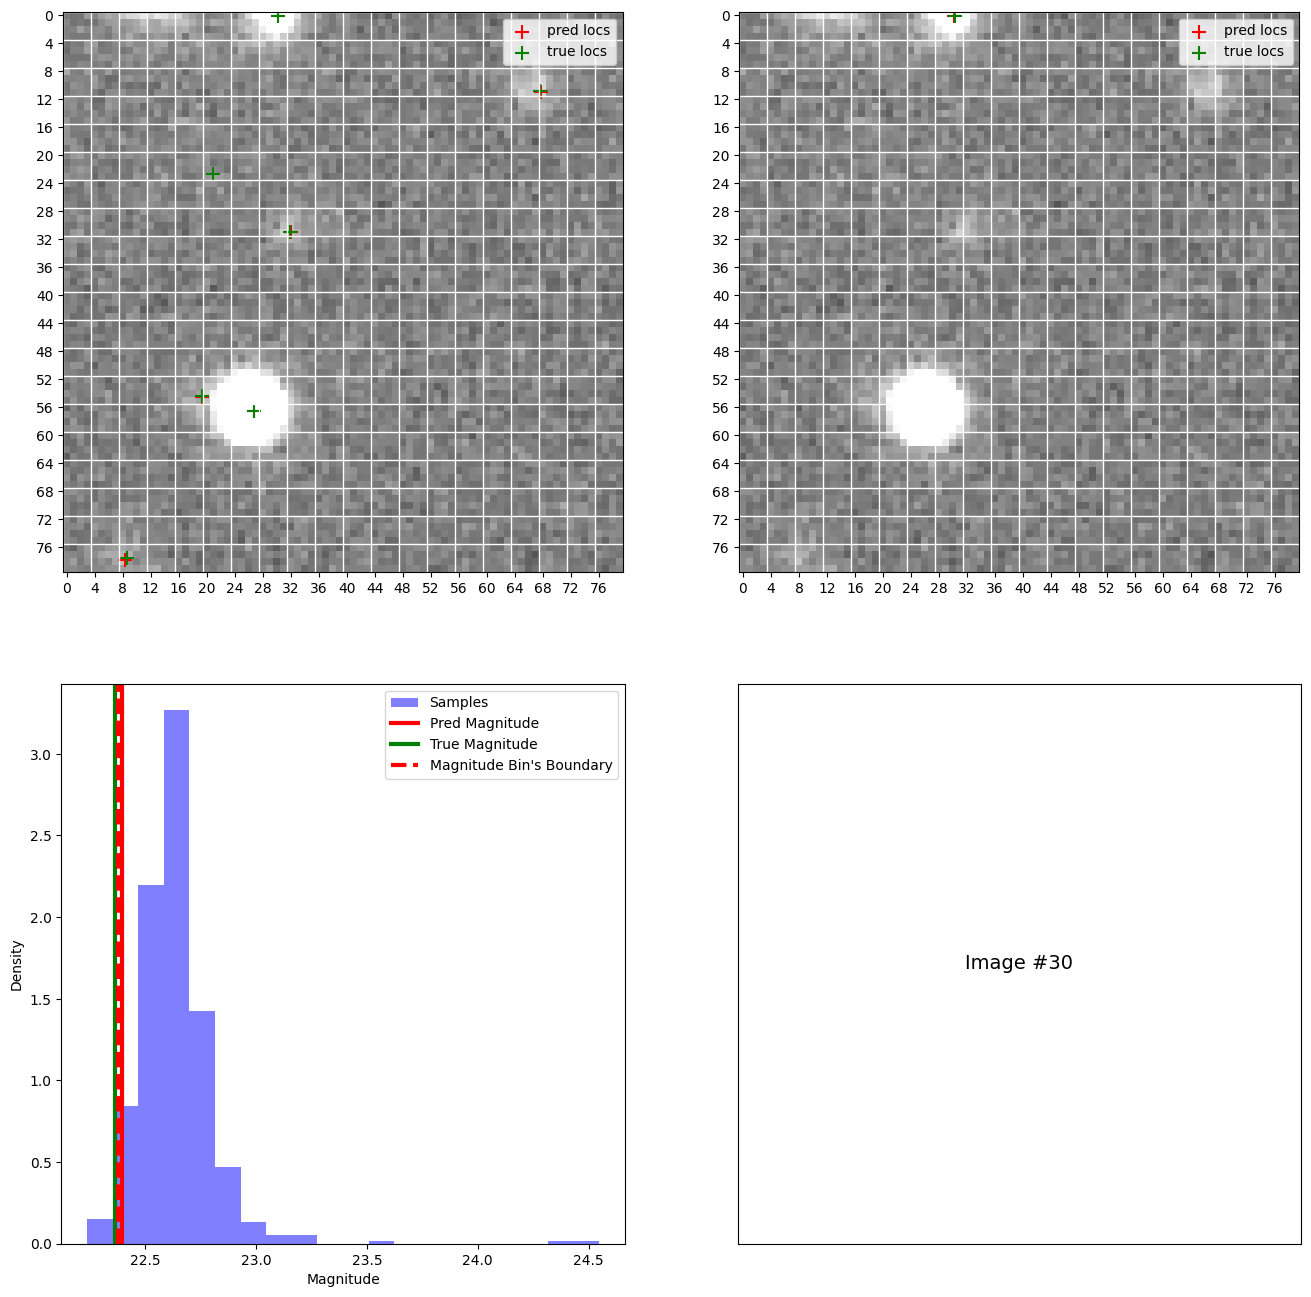

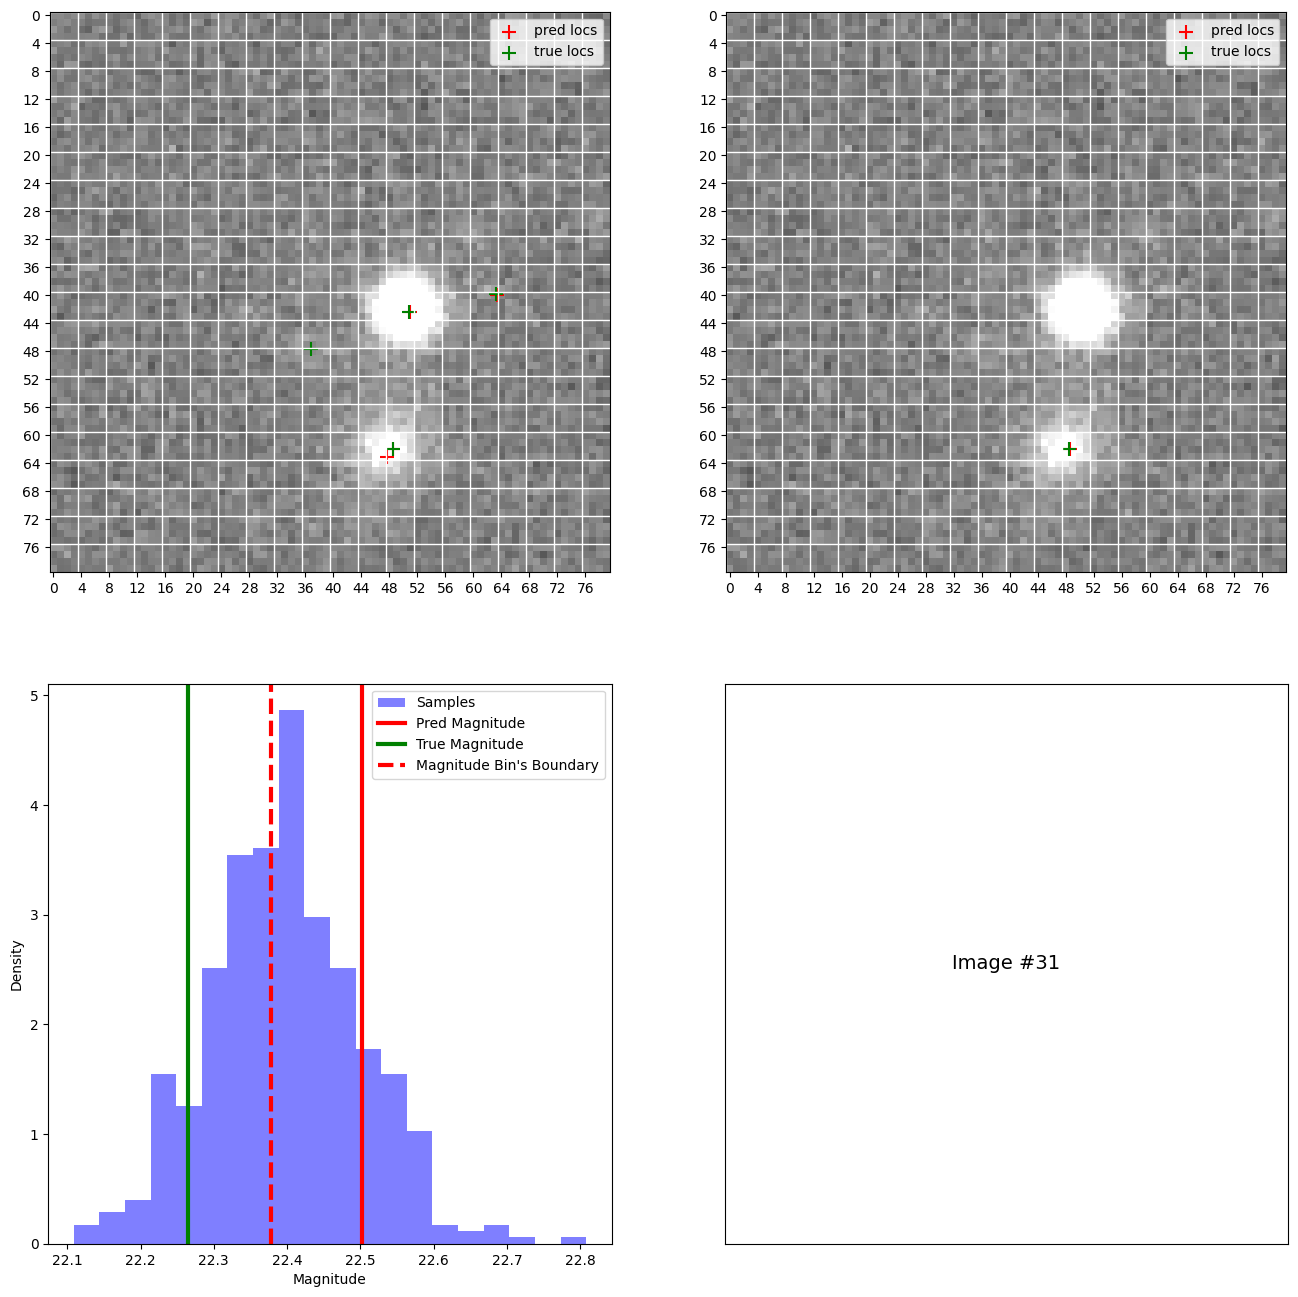

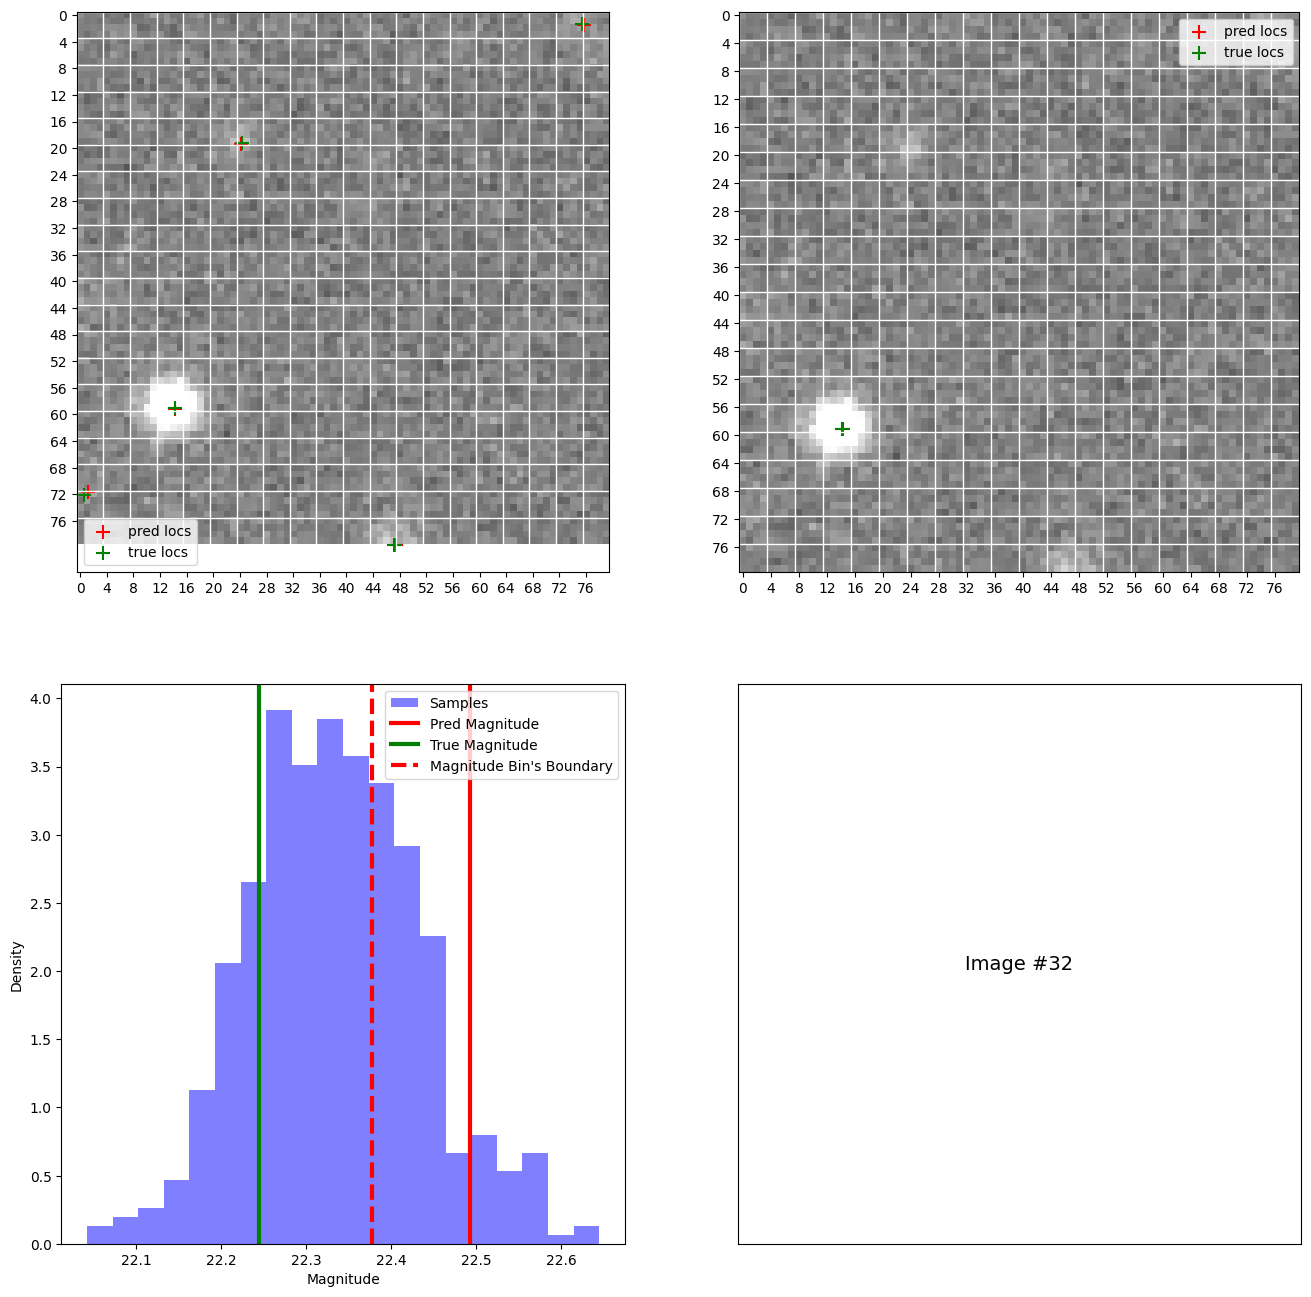

In [17]:
locs_mesh = torch.stack(torch.meshgrid(torch.arange(20, device=device), 
                                       torch.arange(20, device=device), indexing="ij"), dim=-1)  # (20, 20, 2)

for i in range(batch_wise_dense_dev_mask.sum().item()):
    cur_pred_locs = ((pred_locs[i][..., 0, :] + locs_mesh) * 4)[pred_n_sources[i] > 0].cpu()
    cur_true_locs = ((target_locs[i][..., 0, :] + locs_mesh) * 4)[target_n_sources[i] > 0].cpu()
    cur_dev_pred_locs = ((pred_locs[i][..., 0, :] + locs_mesh) * 4)[dense_dev_mask[i]].cpu()
    cur_dev_true_locs = ((target_locs[i][..., 0, :] + locs_mesh) * 4)[dense_dev_mask[i]].cpu()

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()
    axes[0].imshow(get_image_for_plot(target_images[i]).cpu(), cmap="gray", vmin=0, vmax=255)
    line_width = 1.0
    for x in range(0, 80, 4):
        axes[0].axvline(x=x - 0.5, color="white", linewidth=line_width)
    for y in range(0, 80, 4):
        axes[0].axhline(y=y - 0.5, color="white", linewidth=line_width)
    axes[0].scatter(cur_pred_locs[:, 1], cur_pred_locs[:, 0], color="red", marker="+", s=100, label="pred locs")
    axes[0].scatter(cur_true_locs[:, 1], cur_true_locs[:, 0], color="green", marker="+", s=100, label="true locs")
    axes[0].set_xticks(list(range(0, 80, 4)))
    axes[0].set_yticks(list(range(0, 80, 4)))
    axes[0].legend()

    axes[1].imshow(get_image_for_plot(target_images[i]).cpu(), cmap="gray", vmin=0, vmax=255)
    line_width = 1.0
    for x in range(0, 80, 4):
        axes[1].axvline(x=x - 0.5, color="white", linewidth=line_width)
    for y in range(0, 80, 4):
        axes[1].axhline(y=y - 0.5, color="white", linewidth=line_width)
    axes[1].scatter(cur_dev_pred_locs[:, 1], cur_dev_pred_locs[:, 0], color="red", marker="+", s=100, label="pred locs")
    axes[1].scatter(cur_dev_true_locs[:, 1], cur_dev_true_locs[:, 0], color="green", marker="+", s=100, label="true locs")
    axes[1].set_xticks(list(range(0, 80, 4)))
    axes[1].set_yticks(list(range(0, 80, 4)))
    axes[1].legend()

    cur_dev_true_m = convert_flux_to_magnitude(target_fluxes[i][..., 0, test_band_index][dense_dev_mask[i]].cpu(), zero_point=3631e9)
    cur_dev_pred_m = convert_flux_to_magnitude(pred_fluxes[i][..., 0, test_band_index][dense_dev_mask[i]].cpu(), zero_point=3631e9)
    cur_dev_pred_sample_m = convert_flux_to_magnitude(sample_fluxes[:, i][..., 0, test_band_index][(sample_n_sources > 0)[:, i] & (dense_dev_mask[i].cpu())], zero_point=3631e9)
    axes[2].hist(cur_dev_pred_sample_m, bins=20, density=True, alpha=0.5, color="blue", label="Samples")
    axes[2].axvline(x=cur_dev_pred_m.item(), color="red", linewidth=3, label="Pred Magnitude")
    axes[2].axvline(x=cur_dev_true_m.item(), color="green", linewidth=3, label="True Magnitude")
    axes[2].axvline(x=mag_bin_boundaries["ugrizy"[test_band_index]][test_true_mag_bin_index], 
                    color="red", linestyle="dashed", linewidth=3, label="Magnitude Bin's Boundary")
    axes[2].set_xlabel("Magnitude")
    axes[2].set_ylabel("Density")
    axes[2].legend()

    axes[3].text(0.5, 0.5, f"Image #{i}", 
                    ha="center", va="center", 
                    fontsize=14)
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    fig.show()

In [18]:
def plot_trace_for_tiles(image_index: int, tile_indexes: list[tuple[int]], num_traces: int, seed: int):
    pytorch_lightning.seed_everything(seed=seed)

    ss_one_batch = copy.copy(sub_one_batch)
    ss_one_batch["images"] = sub_one_batch["images"][image_index:(image_index + 1)]
    tiles_traces = [
        {
            "tile_n_sources": [],
            "tile_locs_x": [],
            "tile_locs_y": [],
            "tile_fluxes": [],
        }
        for _ in range(len(tile_indexes))
    ]
    for _ in tqdm.tqdm(list(range(num_traces))):
        with torch.inference_mode():
            _sample_tile_cat, inter_tile_cats = diffusion_encoder.sample(ss_one_batch, return_intermediate=True)
        for tt, ti in zip(tiles_traces, tile_indexes):
            tt["tile_n_sources"].append([tc["n_sources"][0, ti[0], ti[1]].item() for tc in inter_tile_cats])
            tt["tile_locs_x"].append([tc["locs"][0, ti[0], ti[1], 0, 1].item() for tc in inter_tile_cats])
            tt["tile_locs_y"].append([tc["locs"][0, ti[0], ti[1], 0, 0].item() for tc in inter_tile_cats])
            tt["tile_fluxes"].append([tc["fluxes"][0, ti[0], ti[1], 0, test_band_index].item() for tc in inter_tile_cats])
    fig, axes = plt.subplots(len(tile_indexes), 4, figsize=(4 * 4, len(tile_indexes) * 4), constrained_layout=True)
    for i, tt in enumerate(tiles_traces):
        for sub_i in range(num_traces):
            axes[i, 0].plot(range(len(tt["tile_n_sources"][sub_i])), tt["tile_n_sources"][sub_i])
            axes[i, 1].plot(range(len(tt["tile_locs_x"][sub_i])), tt["tile_locs_x"][sub_i])
            axes[i, 2].plot(range(len(tt["tile_locs_y"][sub_i])), tt["tile_locs_y"][sub_i])
            axes[i, 3].plot(range(len(tt["tile_fluxes"][sub_i])), convert_flux_to_magnitude(torch.tensor(tt["tile_fluxes"][sub_i]).clamp(min=1), 
                                                                                            zero_point=3631e9))
            tile_iy = tile_indexes[i][0]
            tile_ix = tile_indexes[i][1]
            for ci in range(4):
                axes[i, ci].set_xlabel("DDIM Steps")
                axes[i, ci].set_title(f"Tile ({tile_iy}, {tile_ix})")
            axes[i, 0].set_ylabel("n_sources")
            axes[i, 1].set_ylabel("locs_x")
            axes[i, 2].set_ylabel("locs_y")
            axes[i, 3].set_ylabel("magnitude")
    fig.show()

In [19]:
convert_flux_to_magnitude(torch.tensor(1.0), zero_point=3631e9)

tensor(31.4001)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


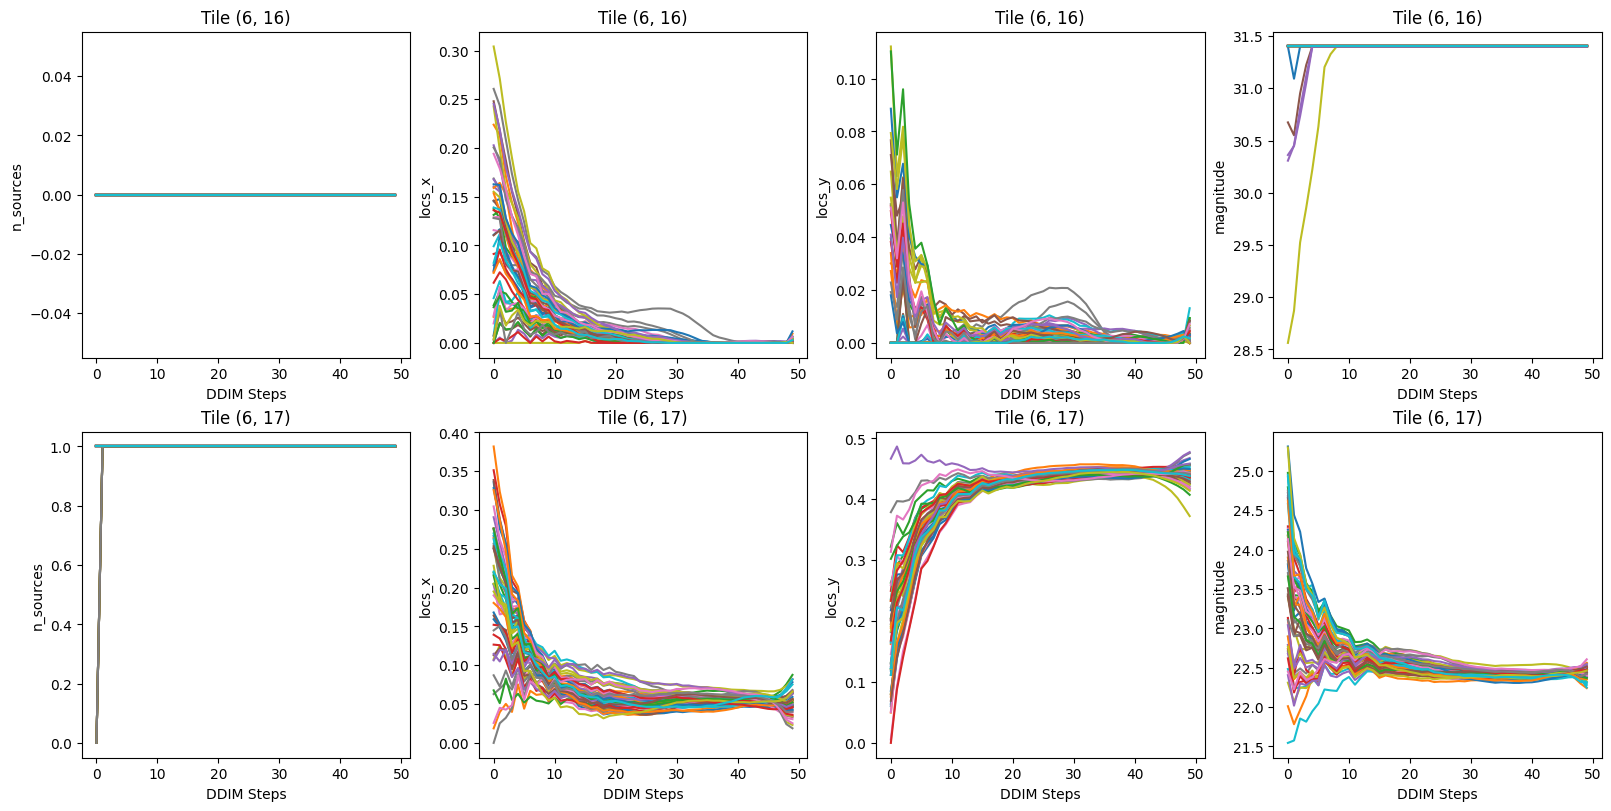

In [20]:
plot_trace_for_tiles(20, [(6, 16), (6, 17)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


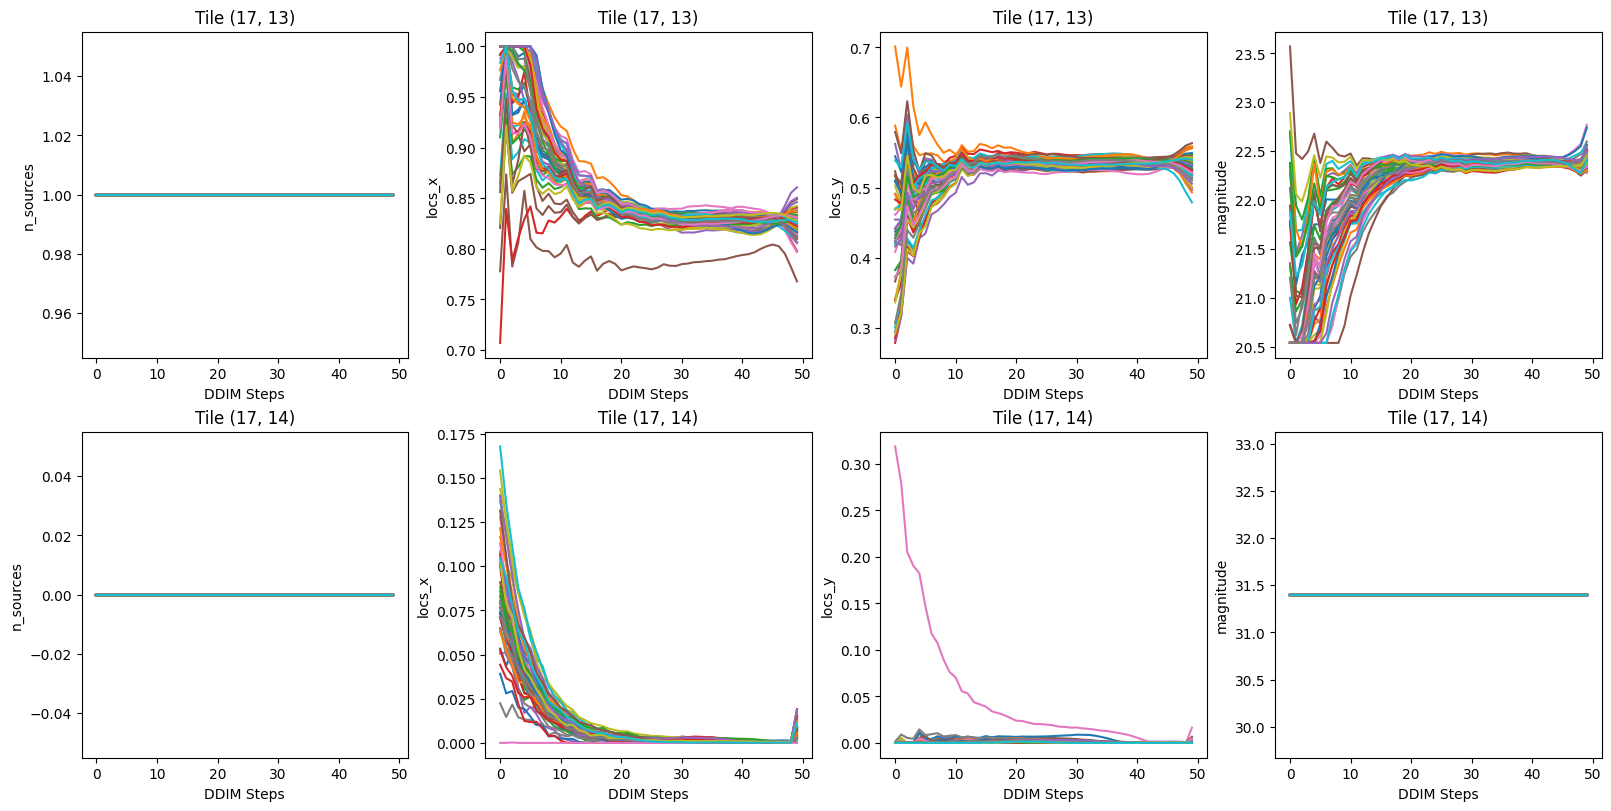

In [21]:
plot_trace_for_tiles(26, [(17, 13), (17, 14)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


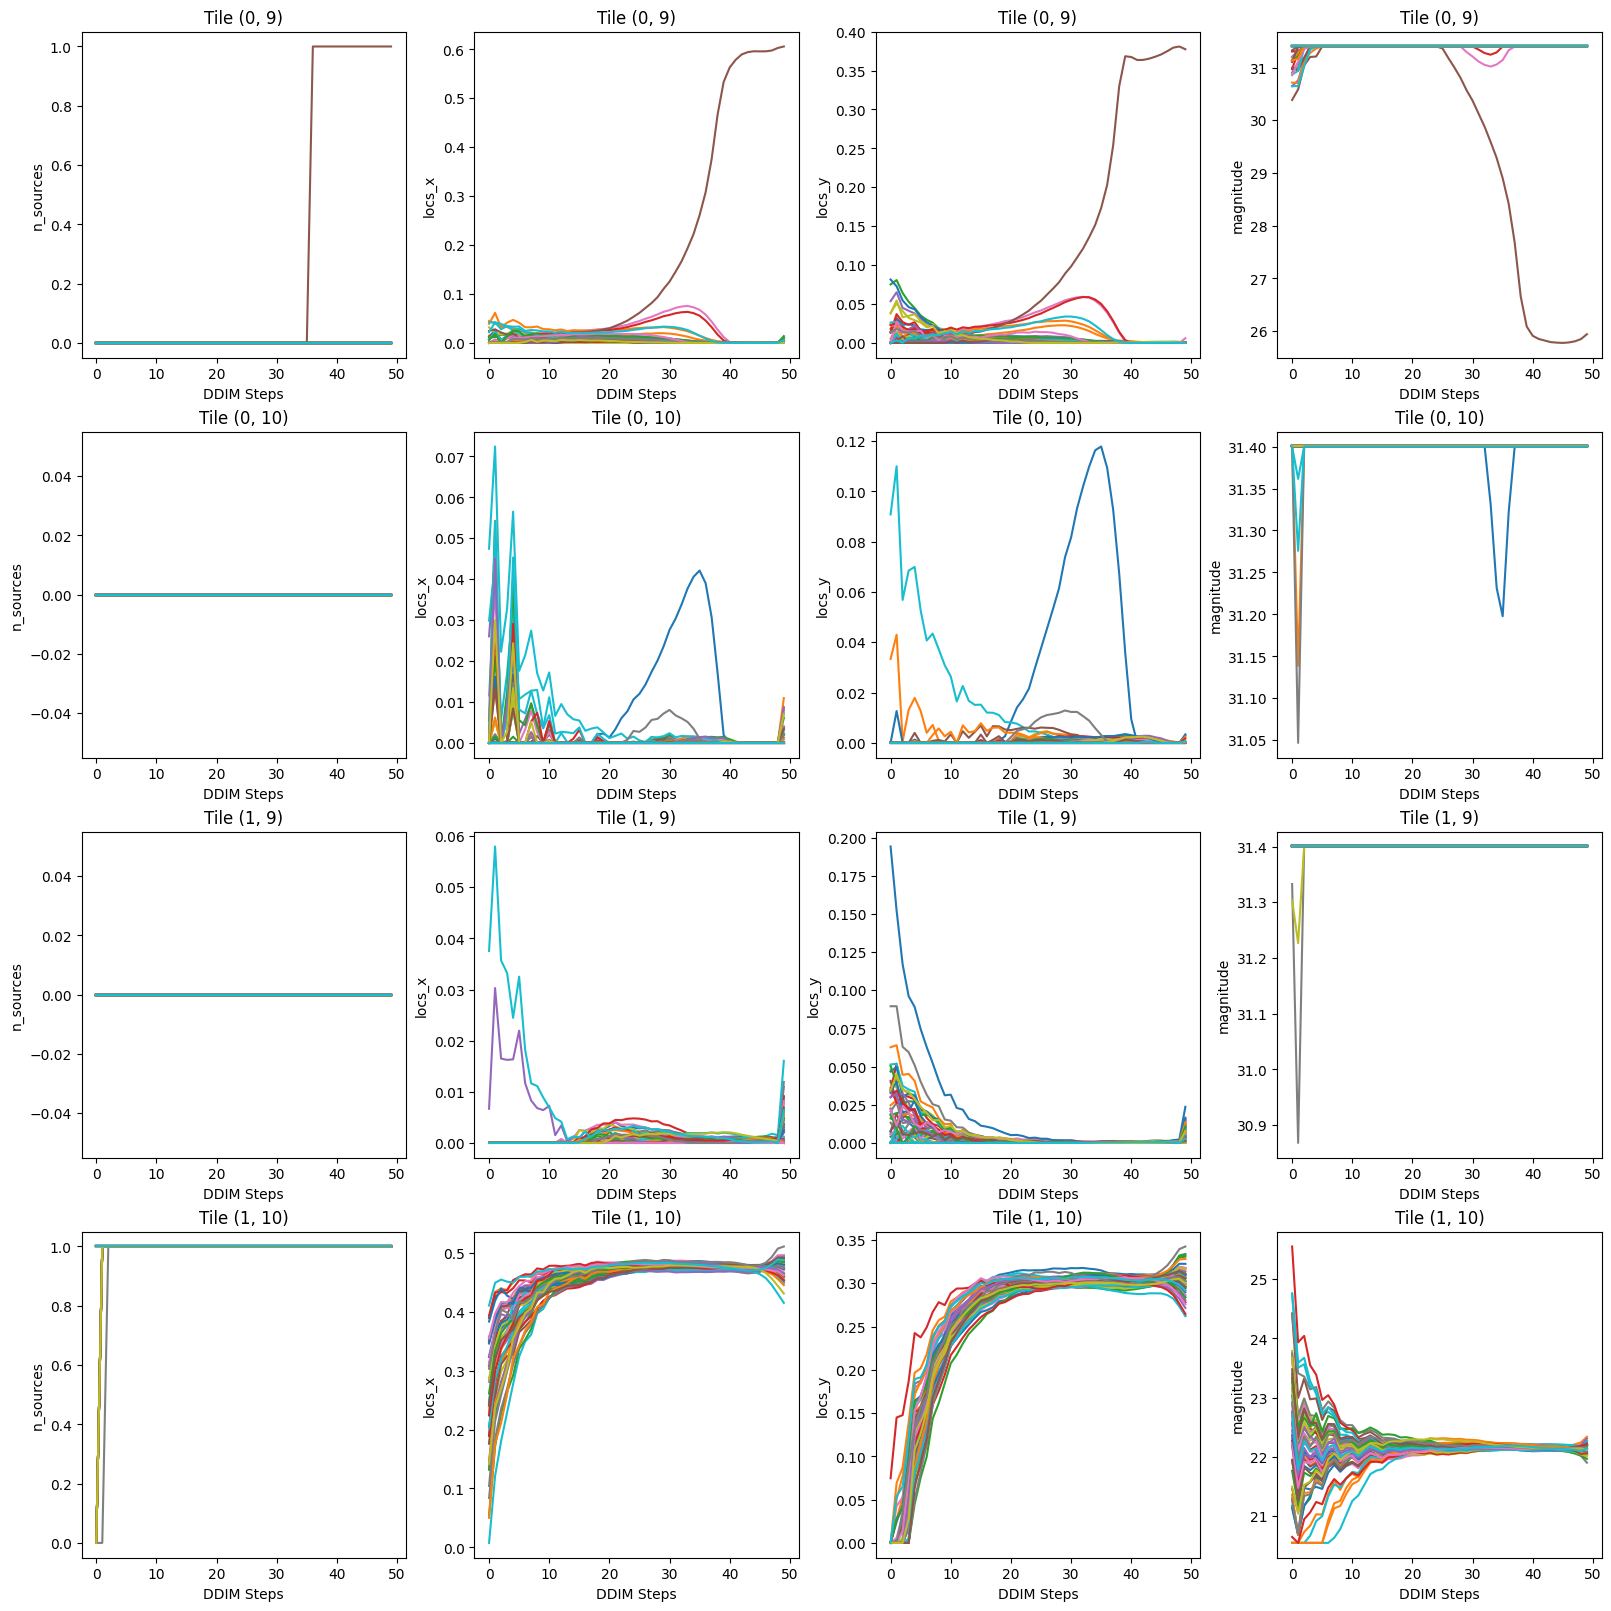

In [22]:
plot_trace_for_tiles(17, [(0, 9), (0, 10), (1, 9), (1, 10)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


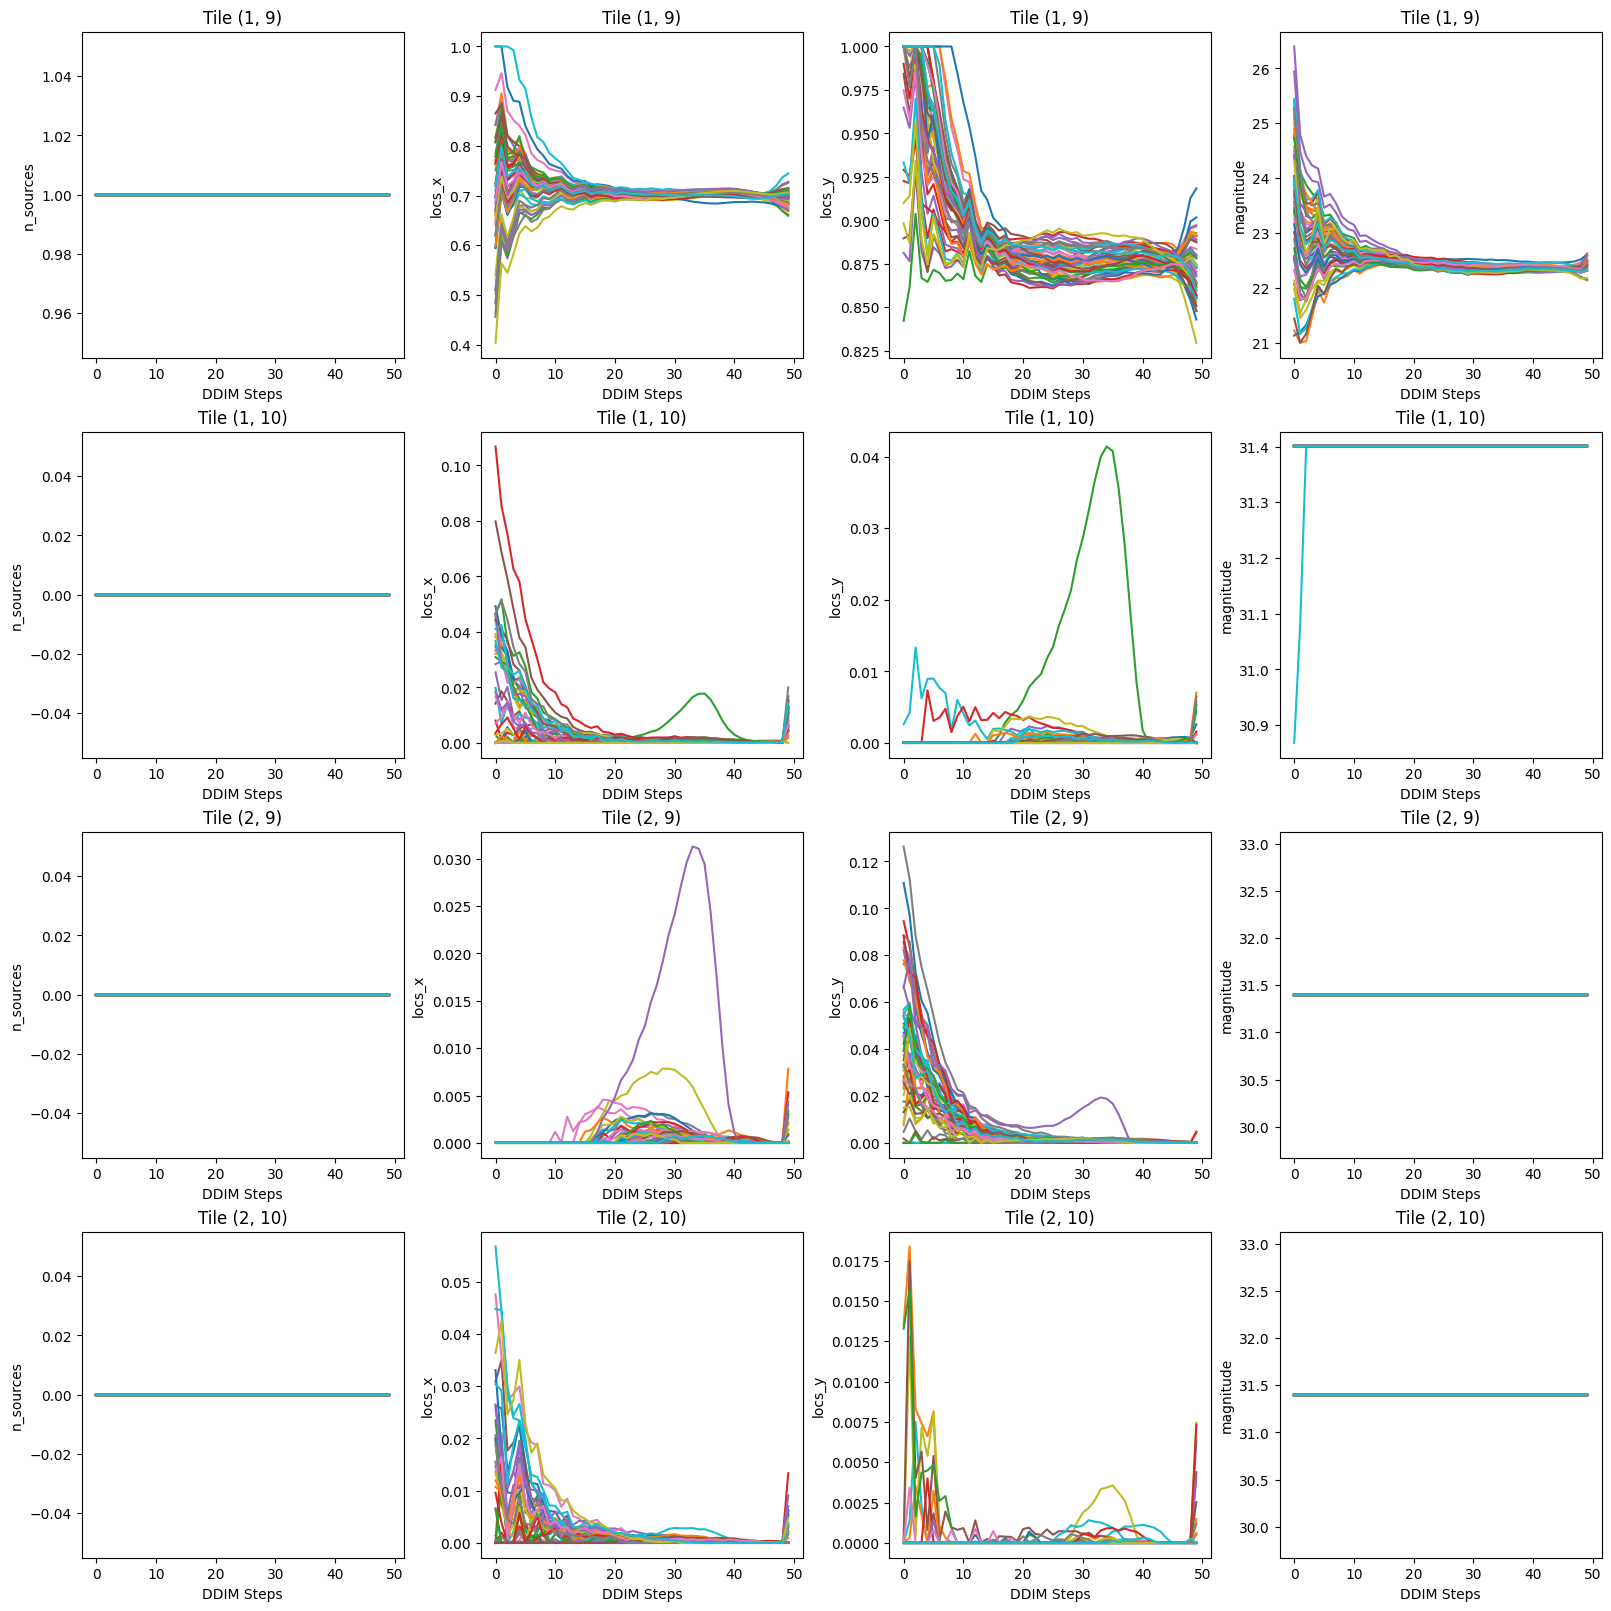

In [23]:
plot_trace_for_tiles(18, [(1, 9), (1, 10), (2, 9), (2, 10)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


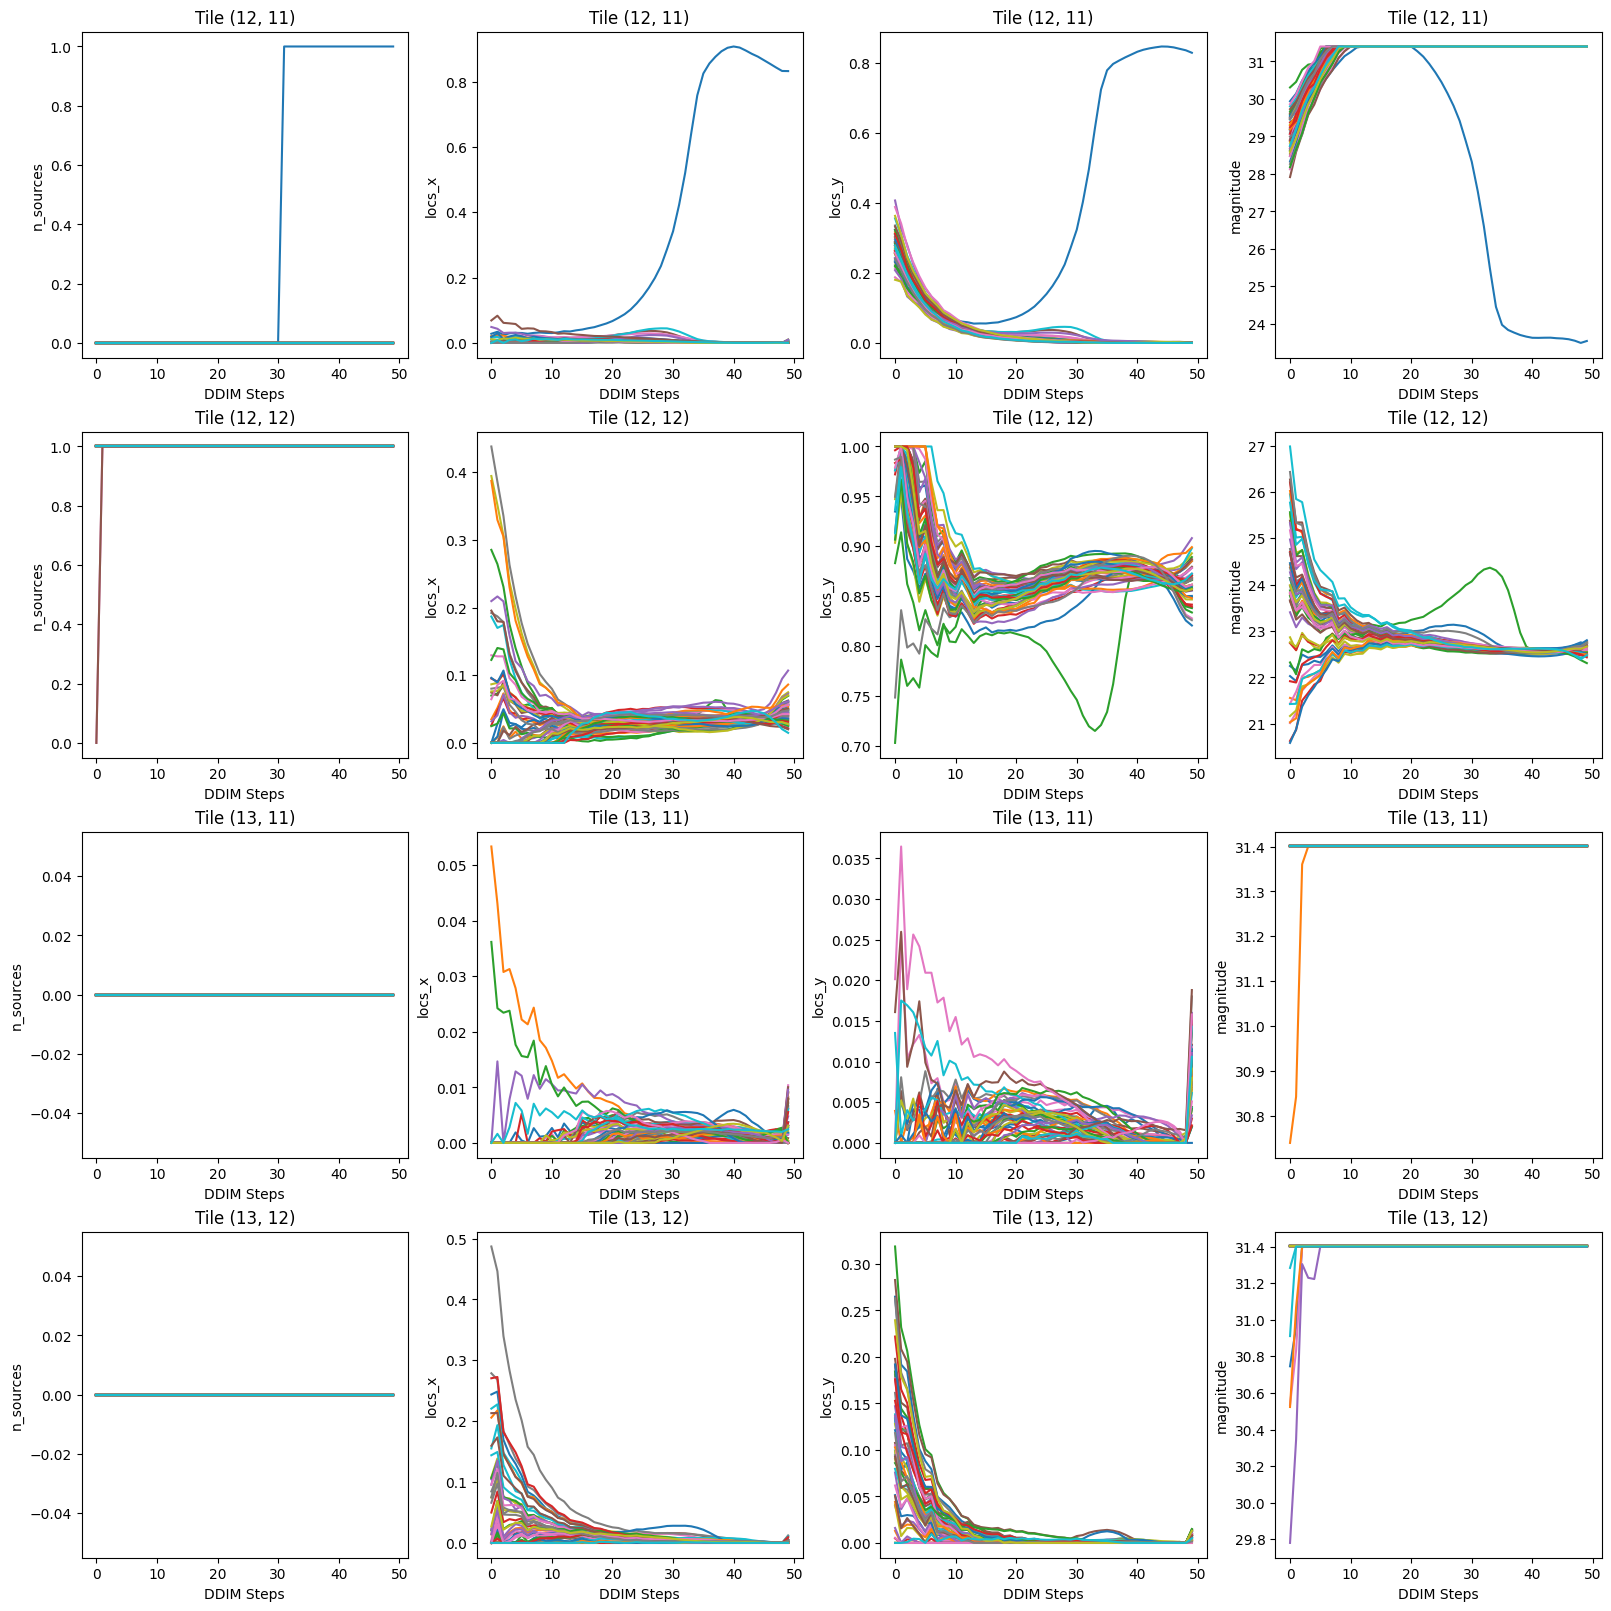

In [24]:
plot_trace_for_tiles(19, [(12, 11), (12, 12), (13, 11), (13, 12)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


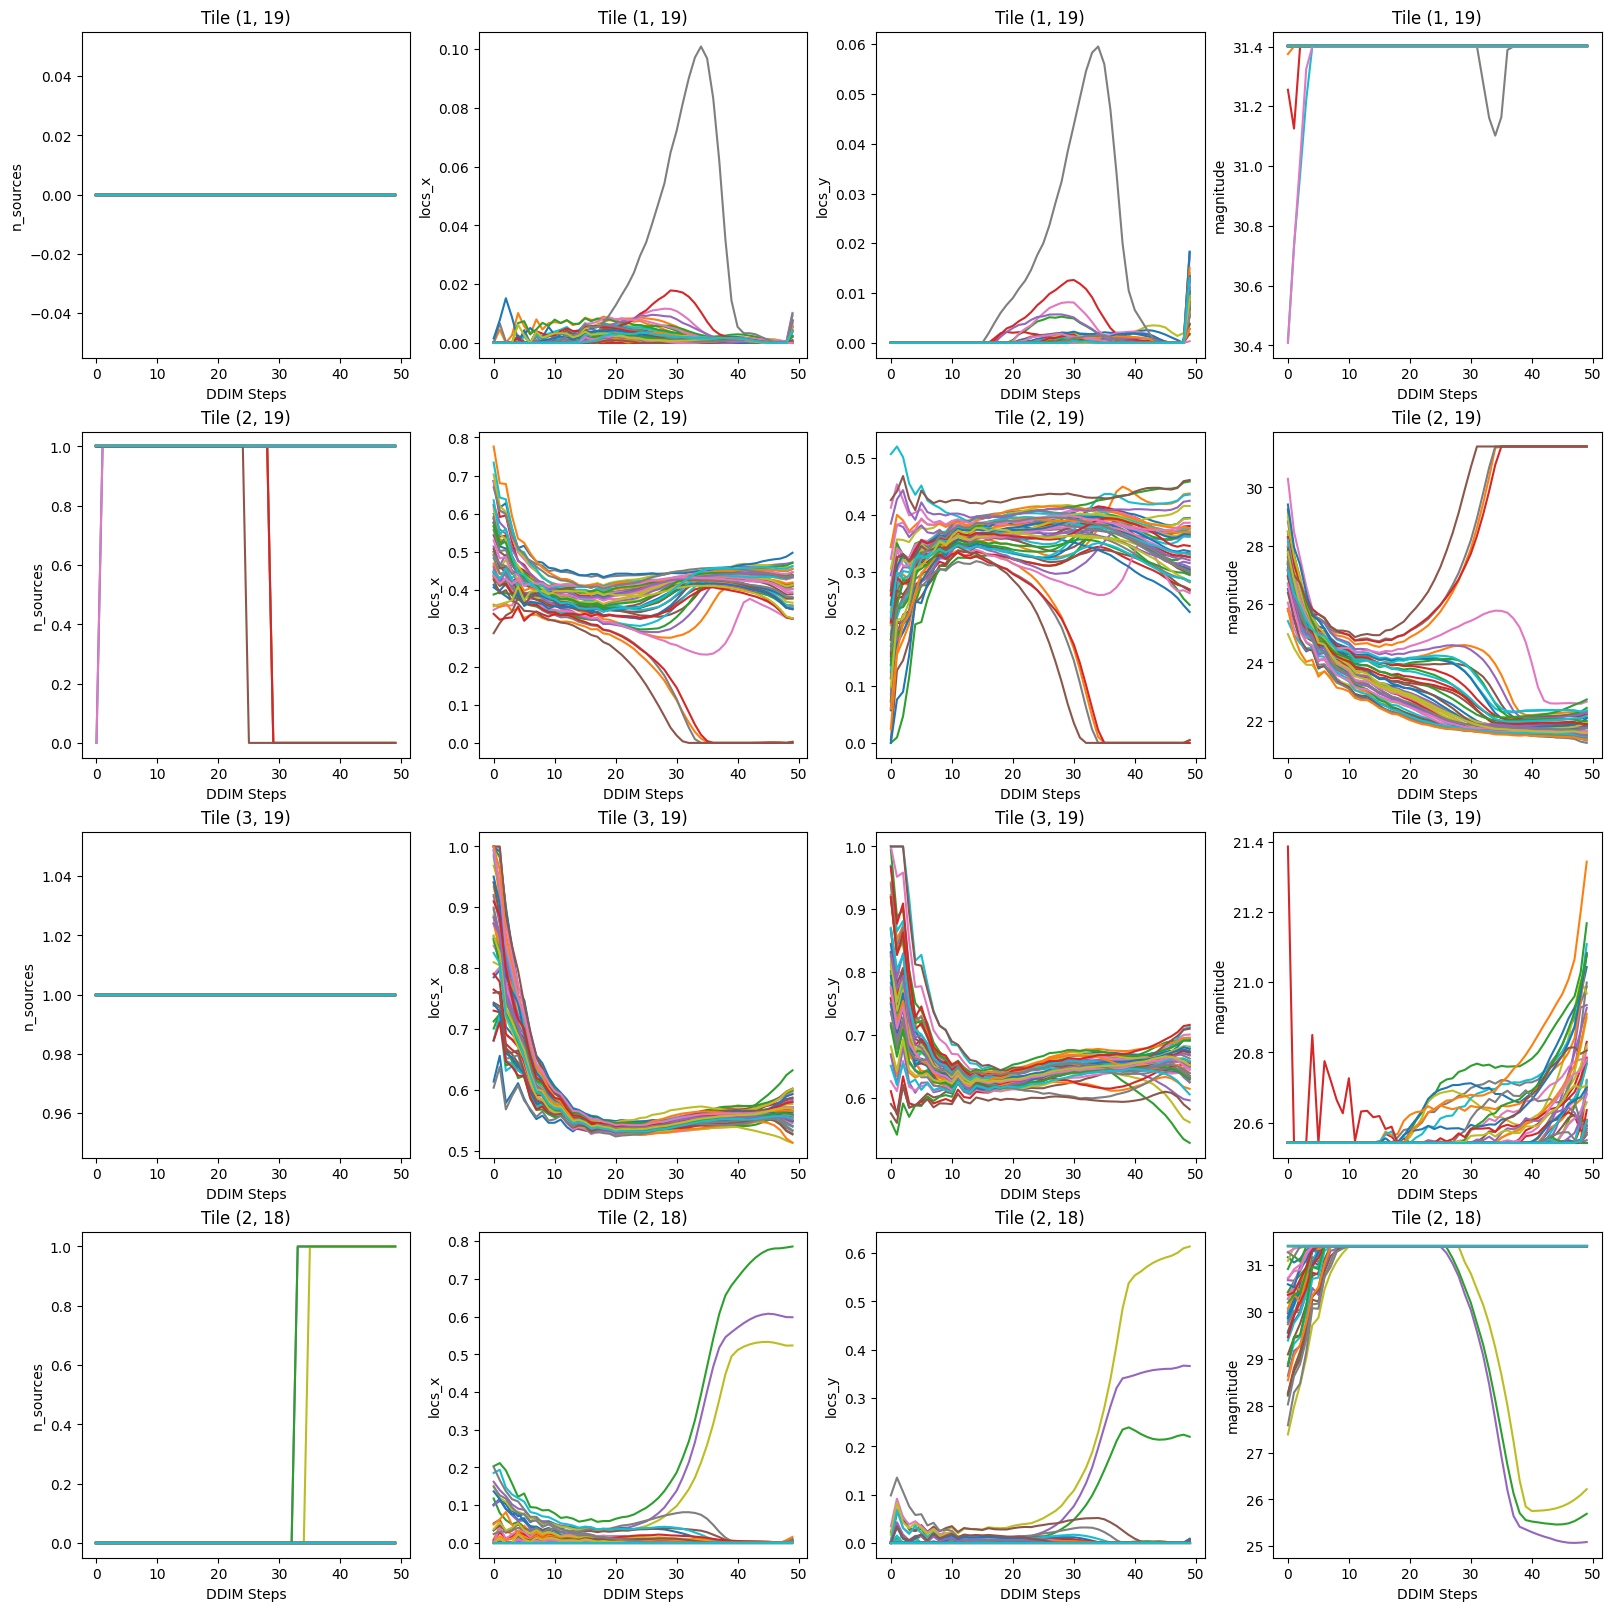

In [25]:
plot_trace_for_tiles(23, [(1, 19), (2, 19), (3, 19), (2, 18)], num_traces=50, seed=7272)

Seed set to 7272
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


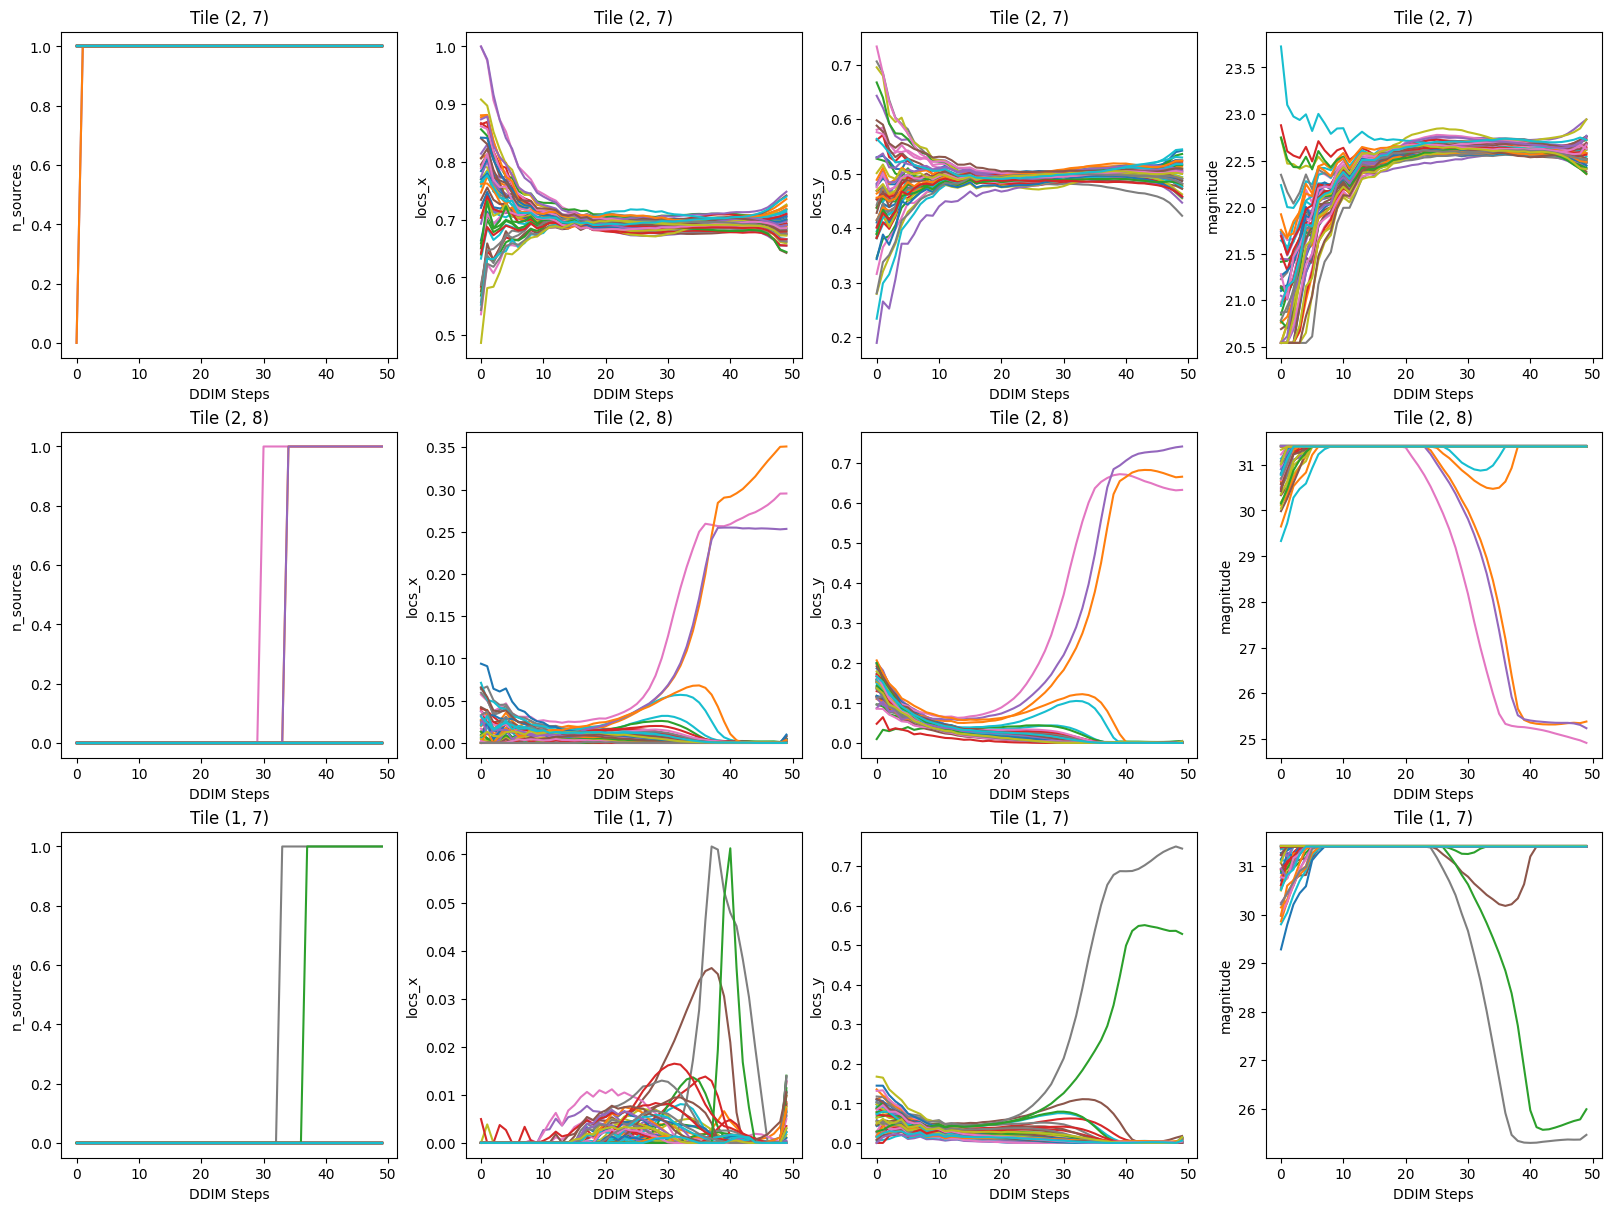

In [26]:
plot_trace_for_tiles(12, [(2, 7), (2, 8), (1, 7)], num_traces=50, seed=7272)